/var/folders/by/26kj85kd3w94p3xv_m2206b40000gn/T/ipykernel_54615/1753392854.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  guo_matches['dist_diff'] = (guo_matches['Dist'] - norm_dist_my).abs()
/var/folders/by/26kj85kd3w94p3xv_m2206b40000gn/T/ipykernel_54615/1753392854.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  guo_matches['dist_diff'] = (guo_matches['Dist'] - norm_dist_my).abs()
/var/folders/by/26kj85kd3w94p3xv_m2206b40000gn/T/ipykernel_54615/1753392854.py:54: SettingWithCopyWarning: 
A valu

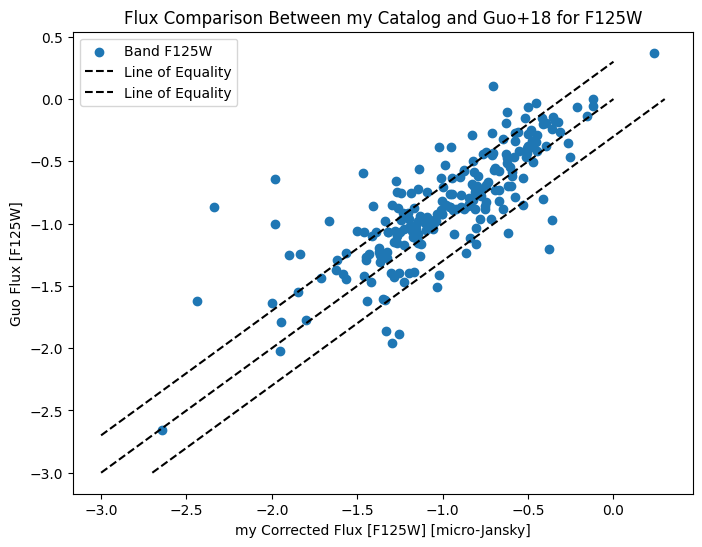

/Users/neal/anaconda3/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/neal/anaconda3/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


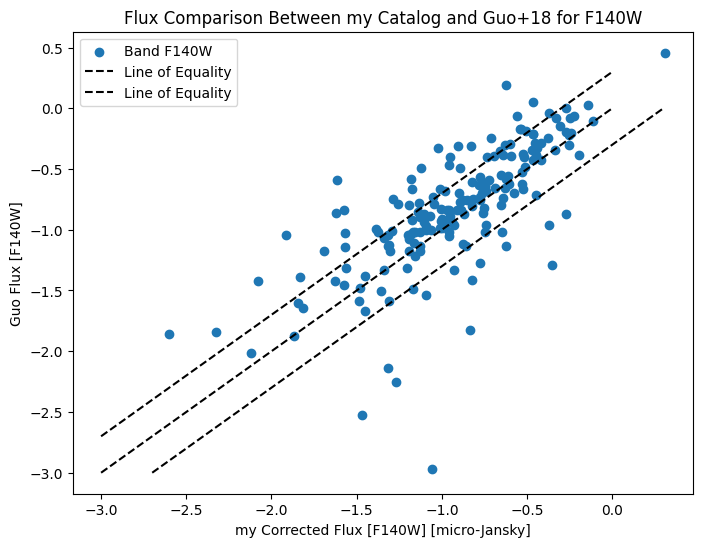

/Users/neal/anaconda3/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


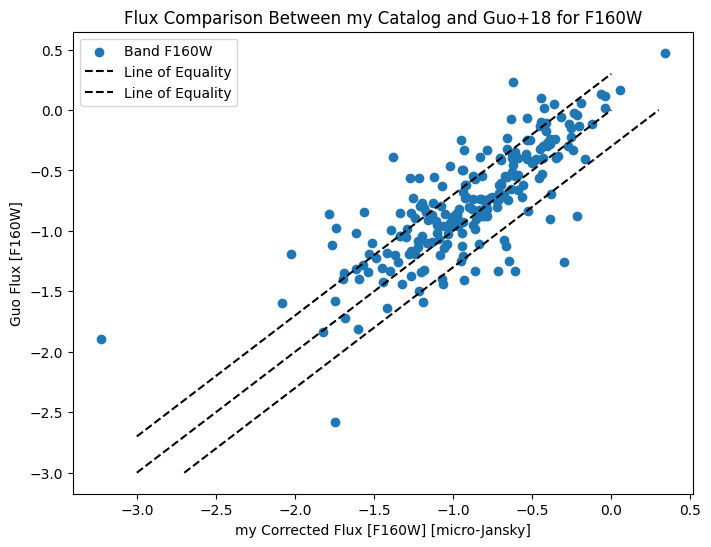

/Users/neal/anaconda3/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


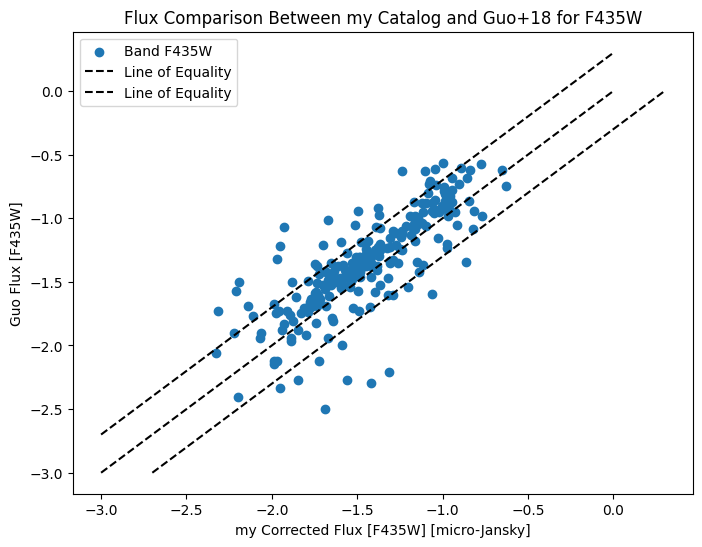

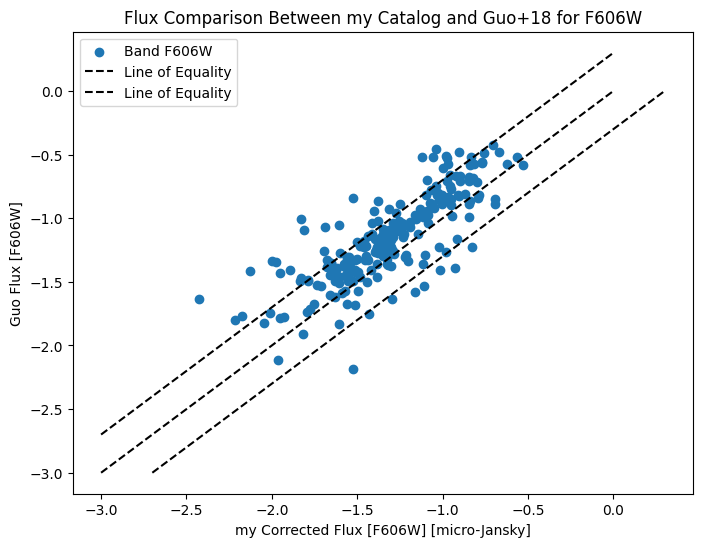

/Users/neal/anaconda3/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


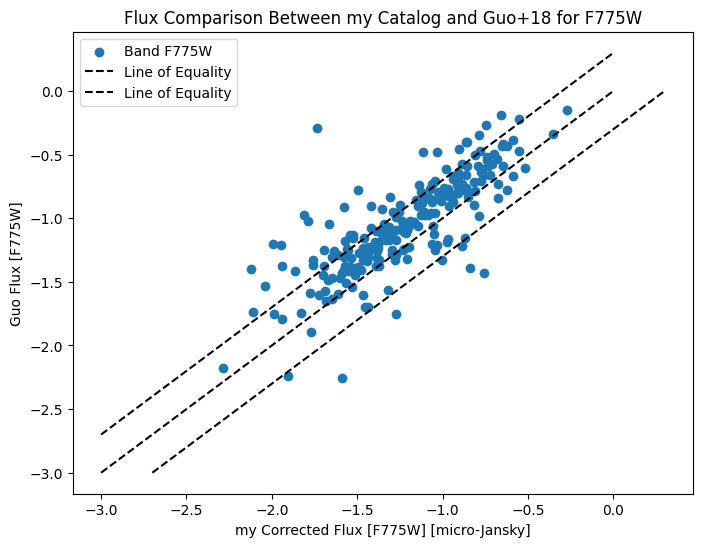

/Users/neal/anaconda3/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


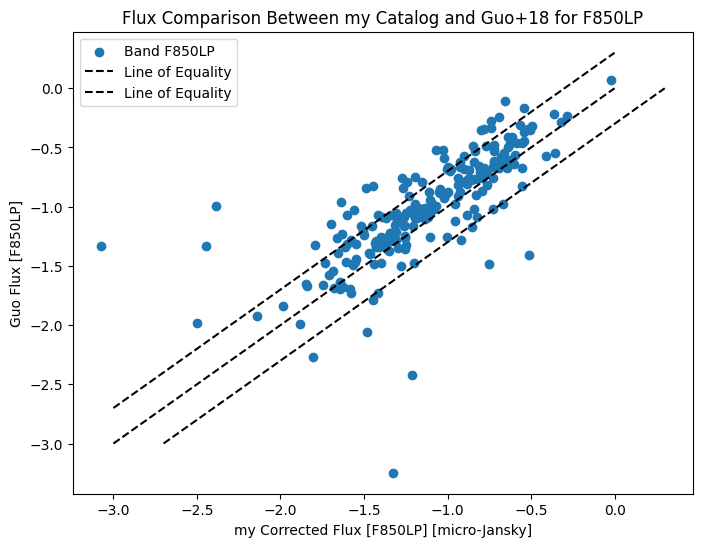

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
from astropy.table import Table
# from astropy.io import ascii

guo_catalog = Table.read('/Users/neal/Downloads/asu-2.fit').to_pandas()

guo_catalog_filtered = guo_catalog.iloc[12772:15967].reset_index(drop=True)

# Define the band suffixes formy catalog and the corresponding column names in Guo+18 catalog
bands = {
    'f125w': 'F125W',
    'f140w': 'F140W',
    'f160w': 'F160W',
    # 'f275w': 'F275W', 
    'f435w': 'F435W',
    'f606w': 'F606W',
    'f775w': 'F775W',
    'f850lp': 'F850LP',
}

# Remove the bands that do not exist in Guo's catalog
bands = {k: v for k, v in bands.items() if v in guo_catalog_filtered.columns}

# Check all bands exist inmy catalog
for band_suffix in bands.keys():
   my_flux_col = f'Corrected_Flux_{band_suffix}_mjy'
   assert my_flux_col in my_vandercat_complete.columns, f"Column '{my_flux_col}' not found in my catalog"

# Continue with the rest of the script for matching and plotting...

# Calculate normalized distance for mycatalog (dist_clump/r)
my_vandercat_complete['norm_dist_clump'] =(0.06* my_vandercat_complete['dist_clump']) / my_vandercat_complete['r']

# Set a threshold for the difference in normalized distances for matching
distance_threshold = 0.05

# Create an empty list to store matches
matches = []

# Iterate over my catalog and find matches in Guo's catalog based on CANDELS ID and normalized distance
for index, my_clump in my_vandercat_complete.iterrows():
    candels_id = my_clump['CANDELS_ID']
    norm_dist_my= my_clump['norm_dist_clump']
    my_flux_ratio = my_clump['flux_ratio']  



    # Only proceed if the flux_ratio is at least 0.05
    if my_flux_ratio >= 0.05:

        # Find potential matches in Guo's catalog
        guo_matches = guo_catalog_filtered[guo_catalog_filtered['Gal'] == candels_id]
        guo_matches['dist_diff'] = (guo_matches['Dist'] - norm_dist_my).abs()

        # Identify the closest match within the threshold
        close_matches = guo_matches[guo_matches['dist_diff'] <= distance_threshold]
        if not close_matches.empty:
            closest_match = close_matches.loc[close_matches['dist_diff'].idxmin()]
            matches.append({
                'my_Catalog_Galaxy_ID': candels_id,
                'my_Clump_ID': index,
                'Guo_Clump_ID': closest_match.name,
                'my_Dist_Norm': norm_dist_my,
                'Guo_Dist_Norm': closest_match['Dist'],
                'Distance_Difference': closest_match['dist_diff']
            })


matches_df = pd.DataFrame(matches)

# Plot the flux comparison for each band
for band_suffix, guo_col_name in bands.items():
    my_flux_col = f'Corrected_Flux_{band_suffix}_mjy'
    
    # Merge matched flux data
    matched_fluxes = pd.merge(matches_df, my_vandercat_complete, left_on='my_Clump_ID', right_index=True)
    matched_fluxes = pd.merge(matched_fluxes, guo_catalog_filtered, left_on='Guo_Clump_ID', right_index=True, suffixes=('_my', '_guo'))

    # Plot myfluxes vs. Guo's for matched clumps
    plt.figure(figsize=(8, 6))
    plt.scatter(np.log10(matched_fluxes[my_flux_col]), np.log10(matched_fluxes[guo_col_name]), label=f'Band {band_suffix.upper()}')
    plt.xlabel(f'my Corrected Flux [{band_suffix.upper()}] [micro-Jansky]')
    plt.ylabel(f'Guo Flux [{guo_col_name}]')
    plt.title(f'Flux Comparison Between my Catalog and Guo+18 for {band_suffix.upper()}')
    plt.plot([-3,0 ], 
             [-3, 0], 'k--', label='Line of Equality')
    plt.plot([-3,0 ], 
             [-2.7, 0.3], 'k--', label='Line of Equality')
    plt.plot([-2.7,0.3 ], 
             [-3, 0], 'k--')
    plt.legend()
    plt.show()



In [19]:
[print(col) for col in matched_fluxes.columns]


my_Catalog_Galaxy_ID
my_Clump_ID
Guo_Clump_ID
my_Dist_Norm
Guo_Dist_Norm
Distance_Difference
Unnamed: 0
Field
CANDELS_ID
z_my
RA_gal
DEC_gal
A
Clump_ID
dist_clump
flux_ratio
restuv_flux
RA_clump
DEC_clump
Raw_Flux_f125w_mjy
Background_Flux_f125w_mjy
Corrected_Flux_f125w_mjy
Raw_Flux_f160w_mjy
Background_Flux_f160w_mjy
Corrected_Flux_f160w_mjy
Raw_Flux_f275w_mjy
Background_Flux_f275w_mjy
Corrected_Flux_f275w_mjy
Raw_Flux_f435w_mjy
Background_Flux_f435w_mjy
Corrected_Flux_f435w_mjy
Raw_Flux_f606w_mjy
Background_Flux_f606w_mjy
Corrected_Flux_f606w_mjy
Raw_Flux_f775w_mjy
Background_Flux_f775w_mjy
Corrected_Flux_f775w_mjy
Raw_Flux_f850lp_mjy
Background_Flux_f850lp_mjy
Corrected_Flux_f850lp_mjy
Raw_Flux_f140w_mjy
Background_Flux_f140w_mjy
Corrected_Flux_f140w_mjy
Fld
F
ID
W
RAJ2000_my
DEJ2000_my
Q
mag
e_mag
r
e_r
n
e_n
q_lc
e_q
PA
e_PA
S_N
COSMOS
GOODS
recno
GroupID
GroupSize
Separation
norm_dist_clump
Gal
RAGdeg
DEGdeg
z_guo
logM_
e_logM_
logSFR
e_logSFR
GUmag
GVmag
GJmag
Rad
e_Rad
CID
RAJ2

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [22]:
matched_fluxes

my_Catalog_Galaxy_ID  my_Clump_ID  Guo_Clump_ID  my_Dist_Norm  \
0                      40            6           996      0.431139   
1                      79           14             0      0.989545   
2                      79           15             0      0.994684   
3                      79           16             2      1.859950   
4                     171           32            11      0.706213   
..                    ...          ...           ...           ...   
220                 26255         3940          2716      1.344909   
221                 26355         3971          2720      1.435678   
222                 26355         3973          2723      0.843449   
223                 26554         4002          2732      1.673125   
224                 26732         4036          3188      0.712896   

     Guo_Dist_Norm  Distance_Difference  Unnamed: 0   Field  CANDELS_ID  \
0            0.447             0.015861           6  goodss          40   
1            1.038             0.048455          14  goodss          79   
2            1.038             0.043316          15  goodss          79   
3            1.904             0.044050          16  goodss          79   
4            0.711             0.004787          32  goodss         171   
..             ...                  ...         ...     ...         ...   
220          1.347             0.002091        3940  goodss       26255   
221          1.438             0.002322        3971  goodss       26355   
222          0.869             0.025551        3973  goodss       26355   
223          1.692             0.018875        4002  goodss       26554   
224          0.736             0.023104        4036  goodss       26732   

       z_my  ...  e_CBmag   CVmag  e_CVmag  logUVSFR  e_logUVSFR  \
0    1.0560  ...    0.064 -19.100    0.033   0.00000     0.00000   
1    1.0120  ...    0.184 -17.410    0.083   0.00000     0.00000   
2    1.0120  ...    0.184 -17.410    0.083   0.00000     0.00000   
3    1.0120  ...    0.095 -17.637    0.066   0.00000     0.00000   
4    0.6202  ...    0.042 -17.234    0.045   0.00000     0.00000   
..      ...  ...      ...     ...      ...       ...         ...   
220  1.0421  ...    0.070 -17.916    0.046   0.00000     0.00000   
221  1.8100  ...    0.059 -18.932    0.074   0.18287     0.22095   
222  1.8100  ...    0.032 -19.459    0.045   0.63301     0.16433   
223  1.6040  ...    0.256 -17.120    0.484  -0.63909     5.11410   
224  2.6170  ...    0.133 -19.275    0.133  -0.14630     5.93160   

         UVE_B-V_  e_UVE_B-V_  VRFlag  BMFlag  EFlag  
0    0.000000e+00    0.000000       0       0      0  
1    0.000000e+00    0.000000       0       0      0  
2    0.000000e+00    0.000000       0       0      0  
3    0.000000e+00    0.000000       0       0      0  
4    0.000000e+00    0.000000       0       0      0  
..            ...         ...     ...     ...    ...  
220  0.000000e+00    0.000000       0       0      0  
221  1.686800e-01    0.063165       0       0      0  
222  2.610200e-01    0.047531       0       0      0  
223  4.831600e-02    0.091687       0       0      0  
224 -6.758200e-07    0.043031       0       0      0  

[225 rows x 136 columns]

# COMPARRE SEDs for 30 random matched clumps:

In [7]:
my_vandercat_complete.columns

Index(['Unnamed: 0', 'Field', 'CANDELS_ID', 'z', 'RA_gal', 'DEC_gal', 'A',
       'Clump_ID', 'dist_clump', 'flux_ratio', 'restuv_flux', 'RA_clump',
       'DEC_clump', 'Raw_Flux_f125w_mjy', 'Background_Flux_f125w_mjy',
       'Corrected_Flux_f125w_mjy', 'Raw_Flux_f160w_mjy',
       'Background_Flux_f160w_mjy', 'Corrected_Flux_f160w_mjy',
       'Raw_Flux_f275w_mjy', 'Background_Flux_f275w_mjy',
       'Corrected_Flux_f275w_mjy', 'Raw_Flux_f435w_mjy',
       'Background_Flux_f435w_mjy', 'Corrected_Flux_f435w_mjy',
       'Raw_Flux_f606w_mjy', 'Background_Flux_f606w_mjy',
       'Corrected_Flux_f606w_mjy', 'Raw_Flux_f775w_mjy',
       'Background_Flux_f775w_mjy', 'Corrected_Flux_f775w_mjy',
       'Raw_Flux_f850lp_mjy', 'Background_Flux_f850lp_mjy',
       'Corrected_Flux_f850lp_mjy', 'Raw_Flux_f140w_mjy',
       'Background_Flux_f140w_mjy', 'Corrected_Flux_f140w_mjy', 'Fld', 'F',
       'ID', 'W', 'RAJ2000', 'DEJ2000', 'Q', 'mag', 'e_mag', 'r', 'e_r', 'n',
       'e_n', 'q_lc', 'e_q', 

In [4]:
# Randomly select 30 matched clumps
selected_matches = matches_df.sample(n=30, random_state=1)

In [5]:
matches_df

my_Catalog_Galaxy_ID  my_Clump_ID  Guo_Clump_ID  my_Dist_Norm  \
0                      40            6           996      0.431139   
1                      79           14             0      0.989545   
2                      79           15             0      0.994684   
3                      79           16             2      1.859950   
4                     171           32            11      0.706213   
..                    ...          ...           ...           ...   
220                 26255         3940          2716      1.344909   
221                 26355         3971          2720      1.435678   
222                 26355         3973          2723      0.843449   
223                 26554         4002          2732      1.673125   
224                 26732         4036          3188      0.712896   

     Guo_Dist_Norm  Distance_Difference  
0            0.447             0.015861  
1            1.038             0.048455  
2            1.038             0.043316  
3            1.904             0.044050  
4            0.711             0.004787  
..             ...                  ...  
220          1.347             0.002091  
221          1.438             0.002322  
222          0.869             0.025551  
223          1.692             0.018875  
224          0.736             0.023104  

[225 rows x 6 columns]

In [39]:
matched_fluxes.columns

Index(['my_Catalog_Galaxy_ID', 'my_Clump_ID', 'Guo_Clump_ID', 'my_Dist_Norm',
       'Guo_Dist_Norm', 'Distance_Difference', 'Unnamed: 0', 'Field',
       'CANDELS_ID', 'z_my',
       ...
       'e_CBmag', 'CVmag', 'e_CVmag', 'logUVSFR', 'e_logUVSFR', 'UVE_B-V_',
       'e_UVE_B-V_', 'VRFlag', 'BMFlag', 'EFlag'],
      dtype='object', length=136)

In [30]:
import random
import matplotlib.pyplot as plt
import pandas as pd

# Assuming `matched_fluxes` is the DataFrame that contains the matched clumps
# Define the band wavelengths in nanometers
band_wavelengths = {
    'F435W': 435,
    'F606W': 606,
    'F775W': 775,
    'F850LP': 850,
    'F125W': 1250,
    'F140W': 1400,
    'F160W': 1600,
    # Add any additional bands here
}

# Sample 30 random clumps
random_clumps = matched_fluxes.sample(n=30, random_state=1)  # Use a fixed random state for reproducibility

# Loop over each random clump to plot SEDs
for idx, clump in random_clumps.iterrows():
    wavelengths = []  # List to store wavelengths for plotting
    my_fluxes = []    # List to store your catalog fluxes for plotting
    guo_fluxes = []   # List to store Guo catalog fluxes for plotting

    # Collect flux data for your catalog and Guo's catalog
    for band, wl in band_wavelengths.items():
        my_flux_col = f'Corrected_Flux_{band}_mjy'
        guo_flux_col = band

        # Check if the columns exist and if the value is not NaN
        if my_flux_col in matched_fluxes.columns and not pd.isnull(clump[my_flux_col]):
            wavelengths.append(wl)
            my_fluxes.append(clump[my_flux_col] * 1e-6)  # Assuming the flux is in microjanskys, convert to janskys
            if guo_flux_col in matched_fluxes.columns and not pd.isnull(clump[guo_flux_col]):
                guo_fluxes.append(clump[guo_flux_col])

    # Plot the SED for the clump if there are enough points
    if wavelengths:
        plt.figure(figsize=(10, 5))
        plt.plot(wavelengths, my_fluxes, 'o-', label='My Catalog')
        plt.plot(wavelengths, guo_fluxes, 'o-', label='Guo Catalog')
        plt.xlabel('Wavelength (nm)')
        plt.ylabel('Flux (Jansky)')
        plt.title(f'SED Comparison for Clump {idx}')
        plt.legend()
        plt.grid(True)
        plt.show()
        # Close the figure to free up memory
        plt.close()
    else:
        print(f"No data available for Clump {idx}")


No data available for Clump 39
No data available for Clump 166
No data available for Clump 93
No data available for Clump 62
No data available for Clump 195
No data available for Clump 119
No data available for Clump 38
No data available for Clump 184
No data available for Clump 160
No data available for Clump 89
No data available for Clump 4
No data available for Clump 124
No data available for Clump 191
No data available for Clump 95
No data available for Clump 98
No data available for Clump 106
No data available for Clump 31
No data available for Clump 105
No data available for Clump 67
No data available for Clump 214
No data available for Clump 110
No data available for Clump 34
No data available for Clump 162
No data available for Clump 168
No data available for Clump 44
No data available for Clump 163
No data available for Clump 188
No data available for Clump 218
No data available for Clump 18
No data available for Clump 152


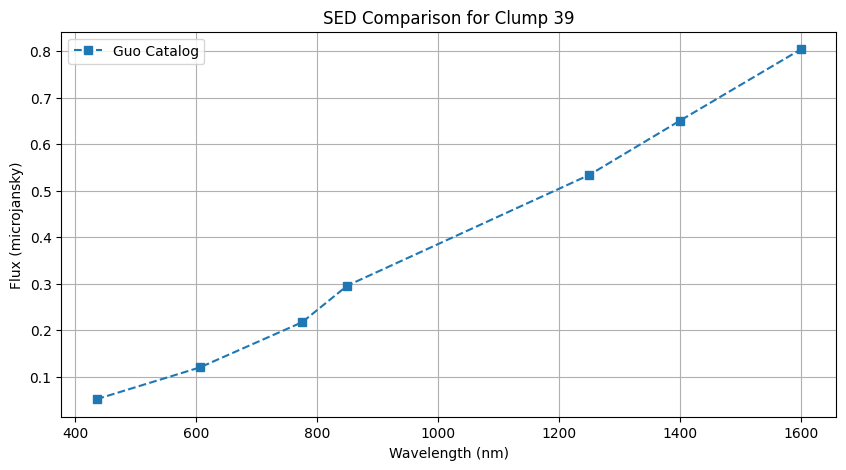

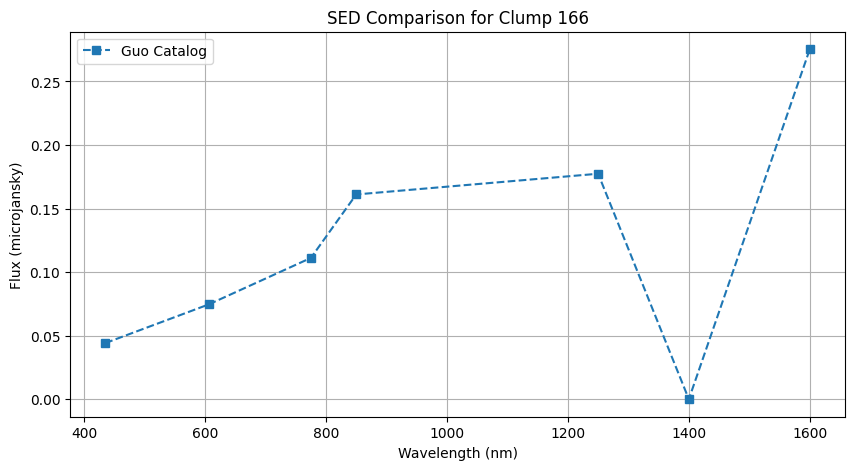

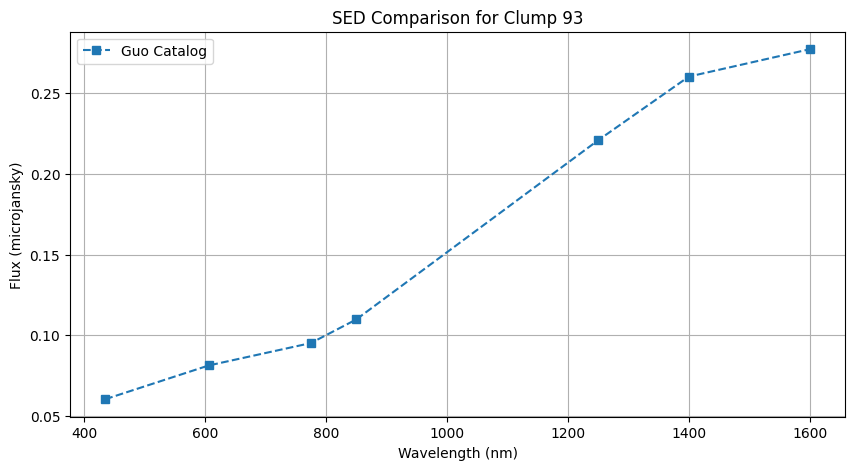

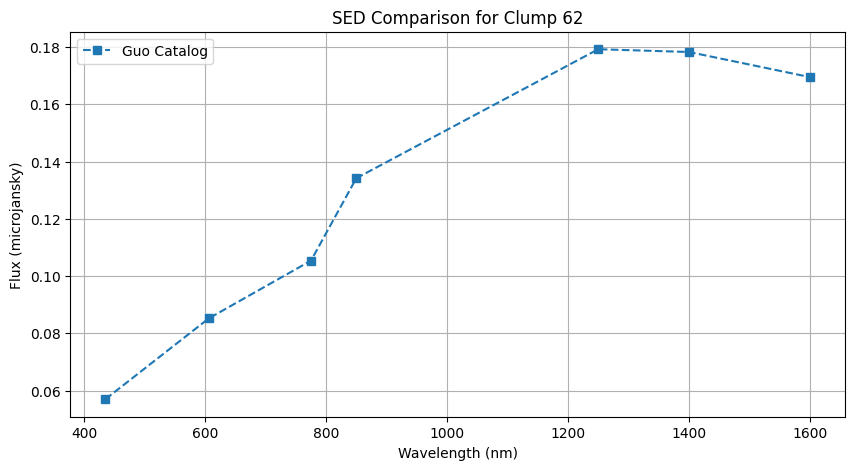

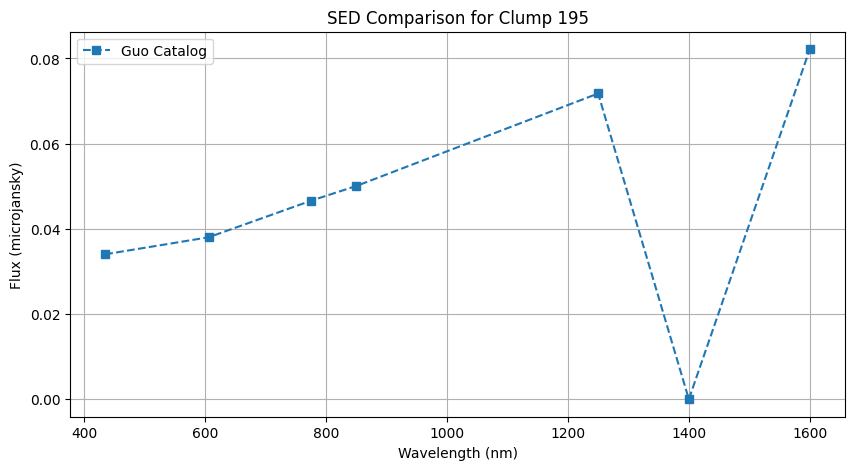

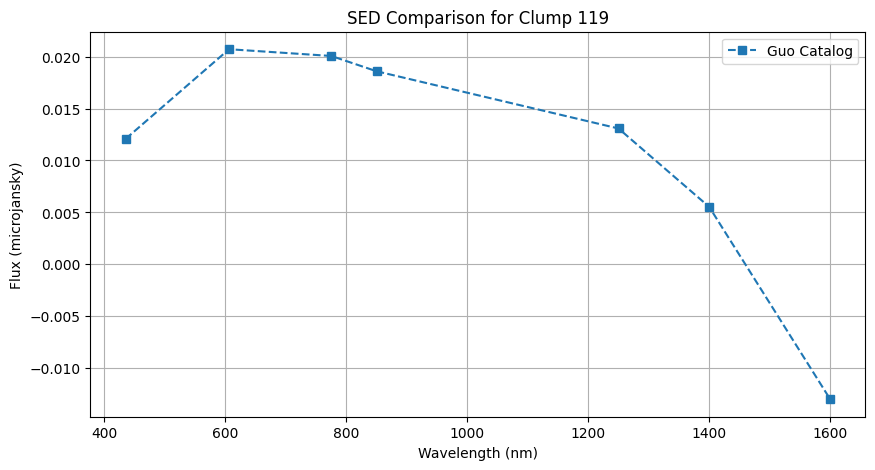

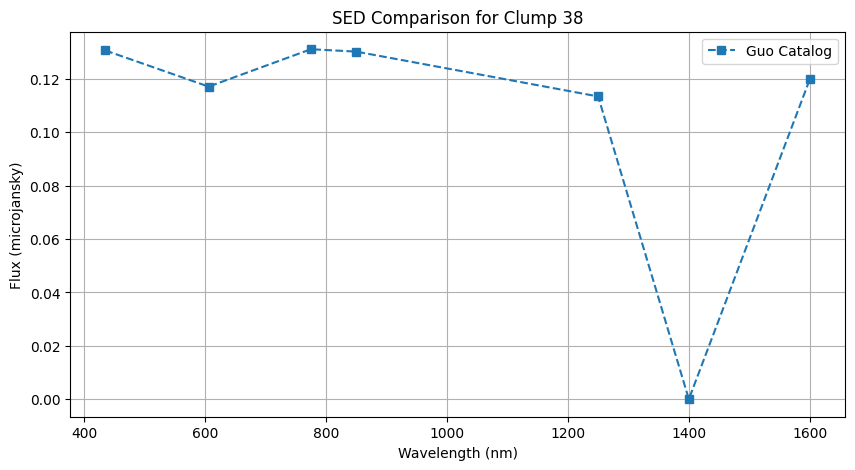

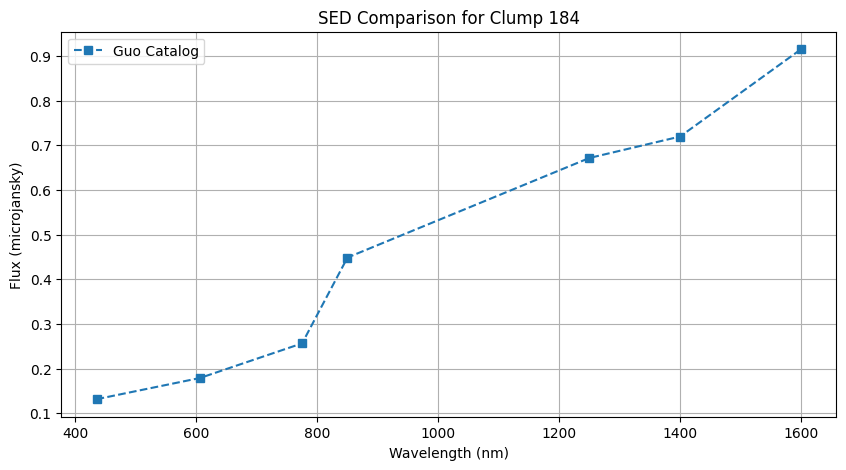

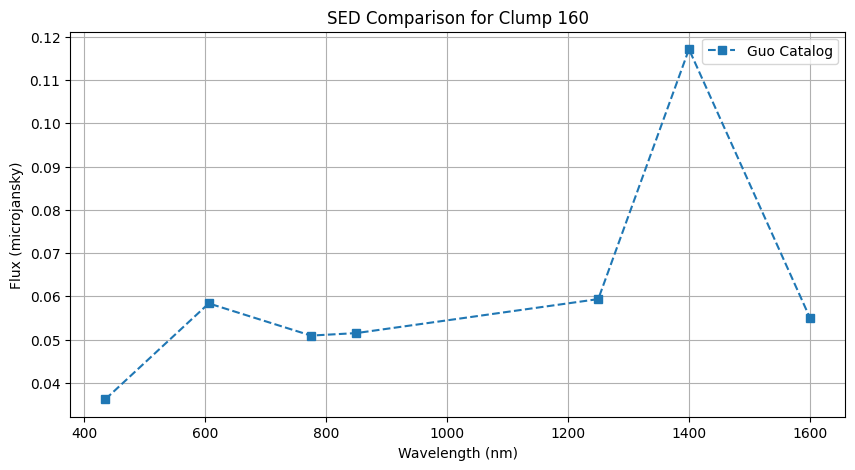

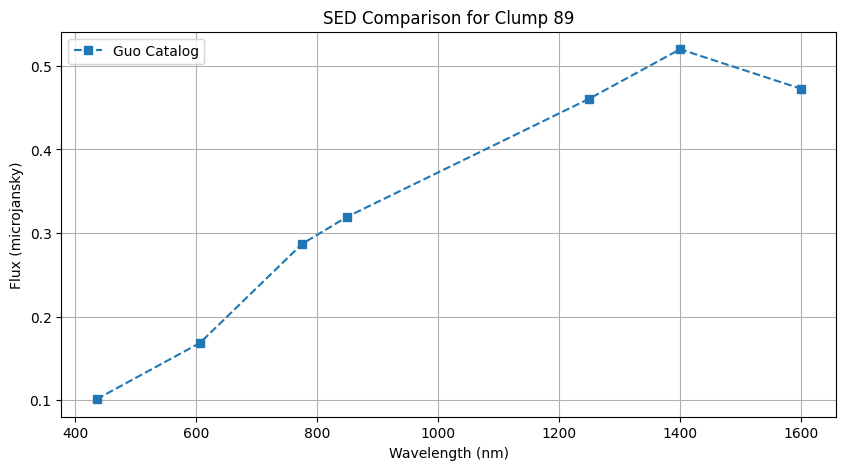

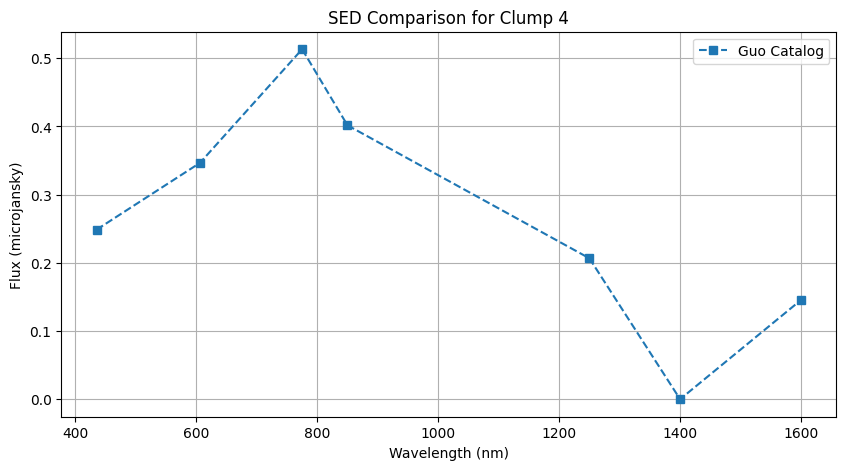

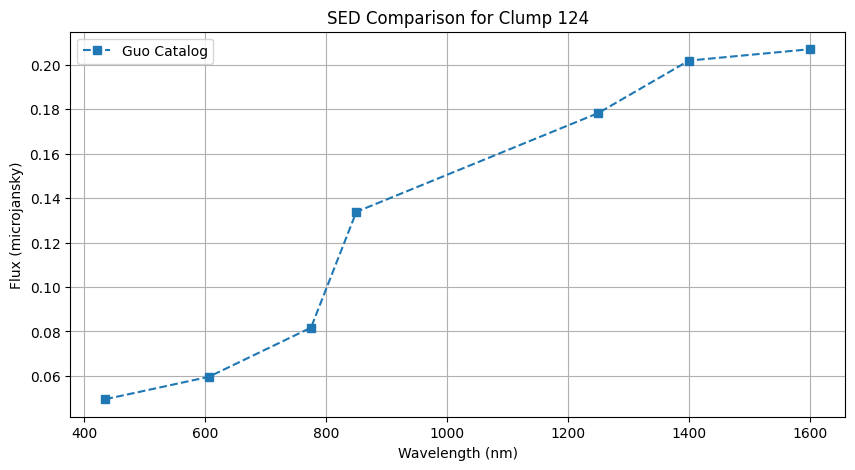

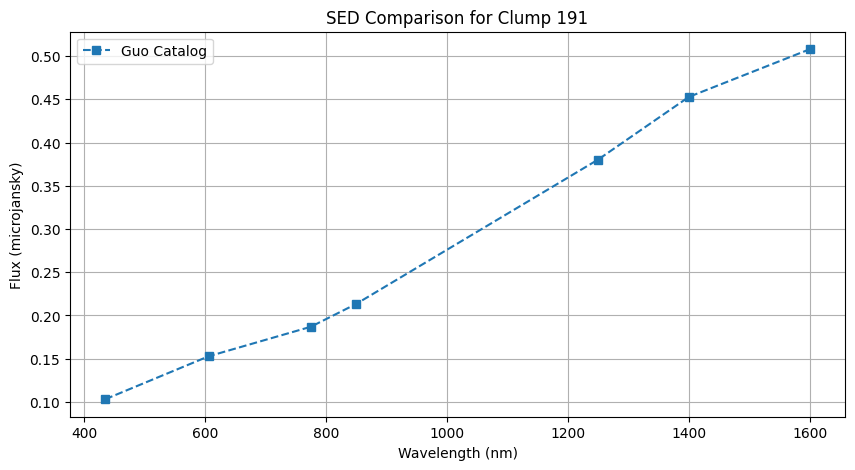

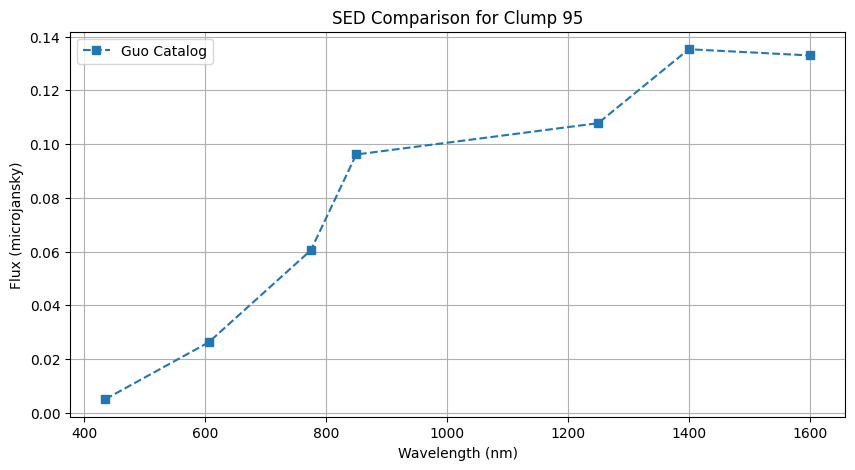

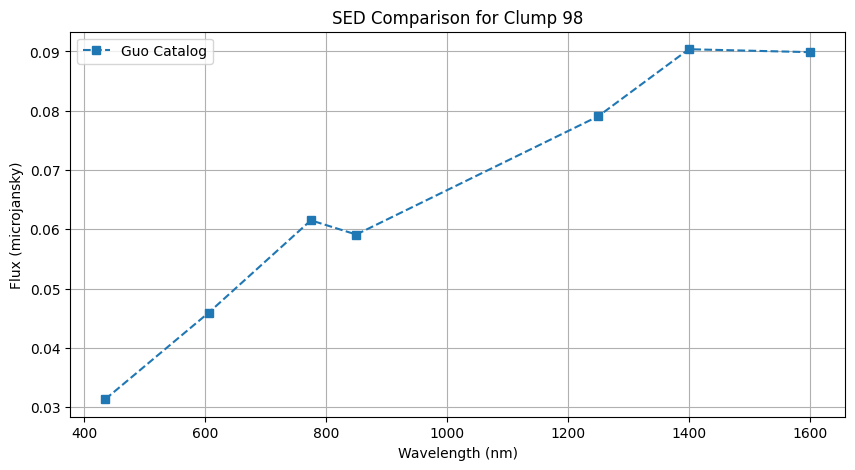

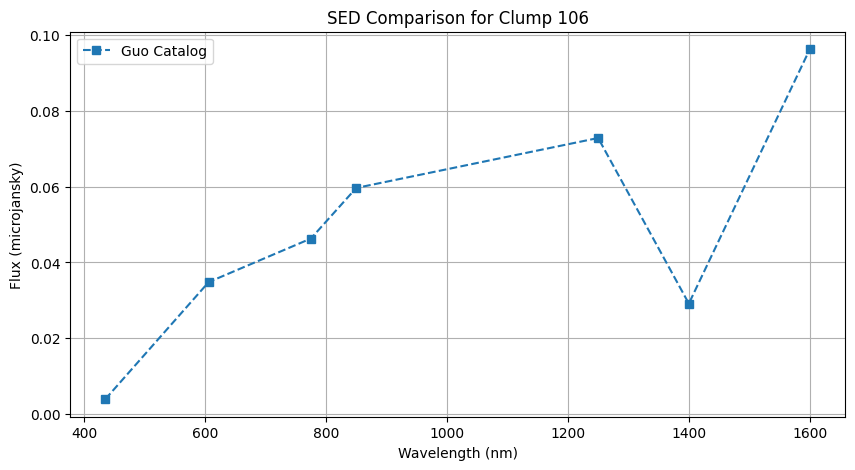

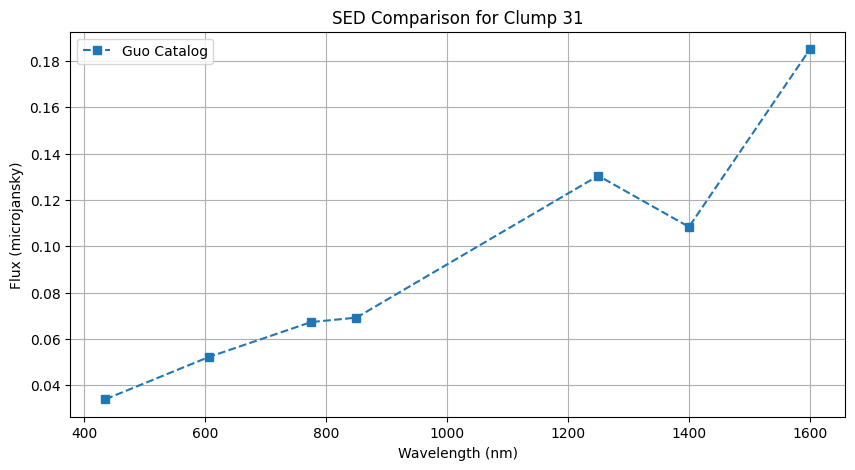

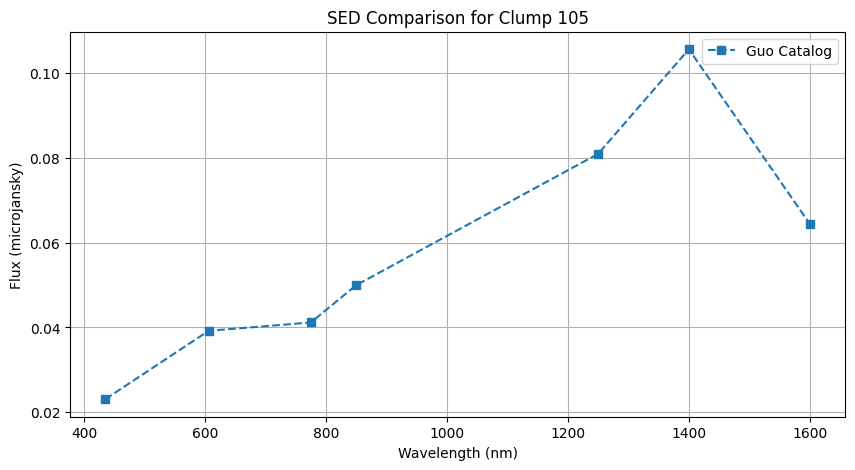

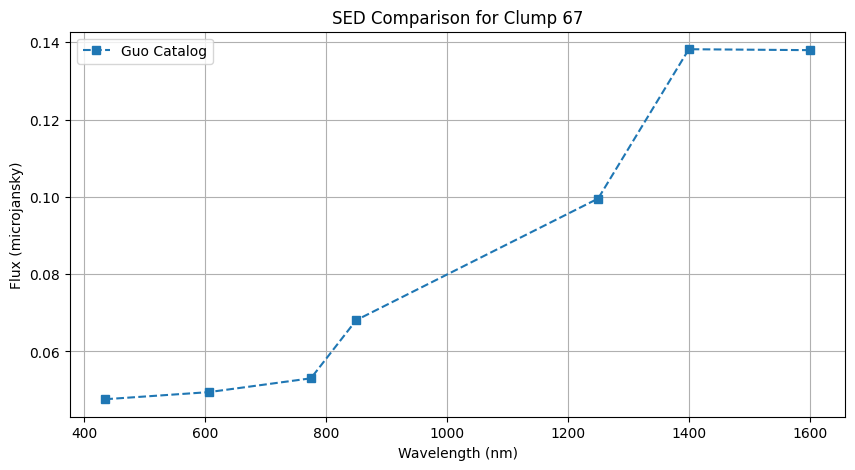

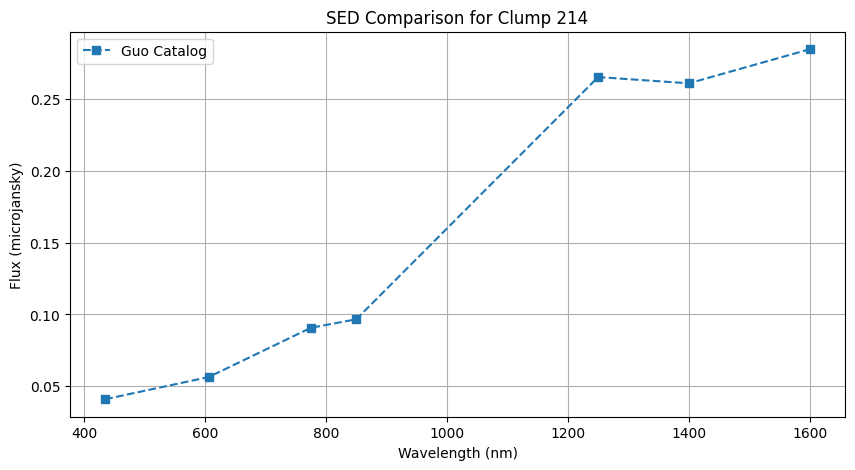

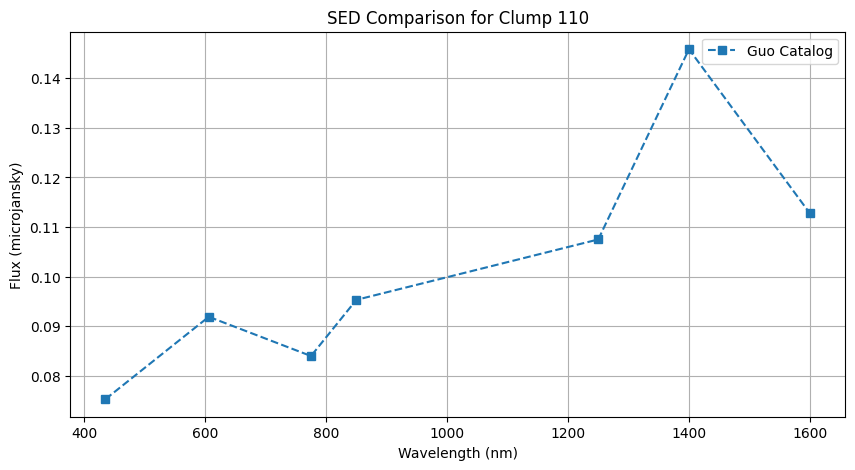

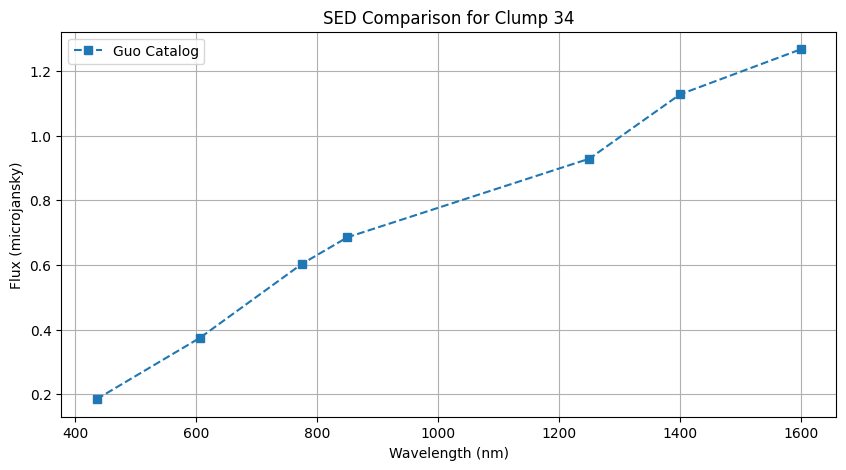

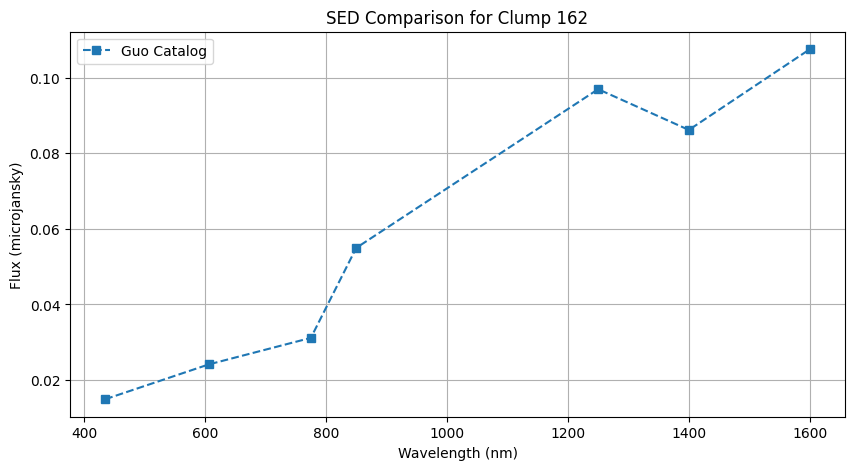

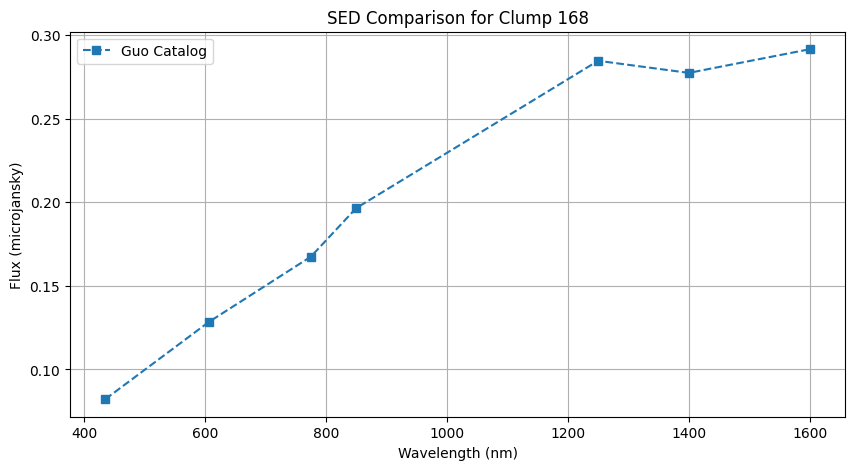

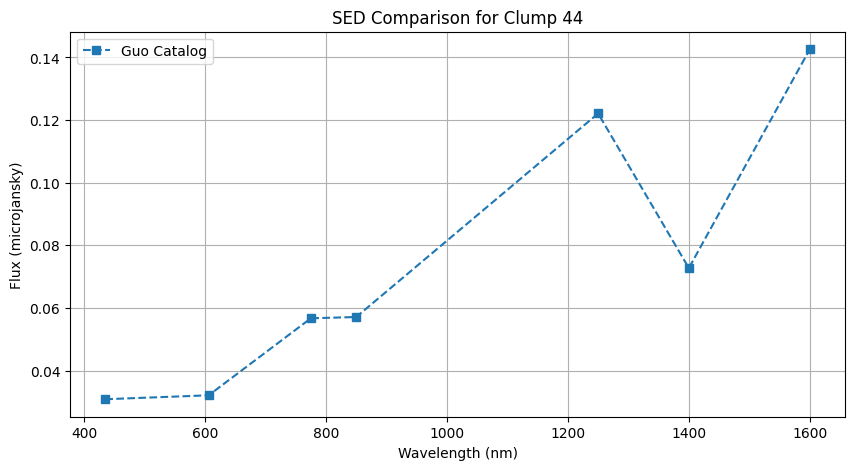

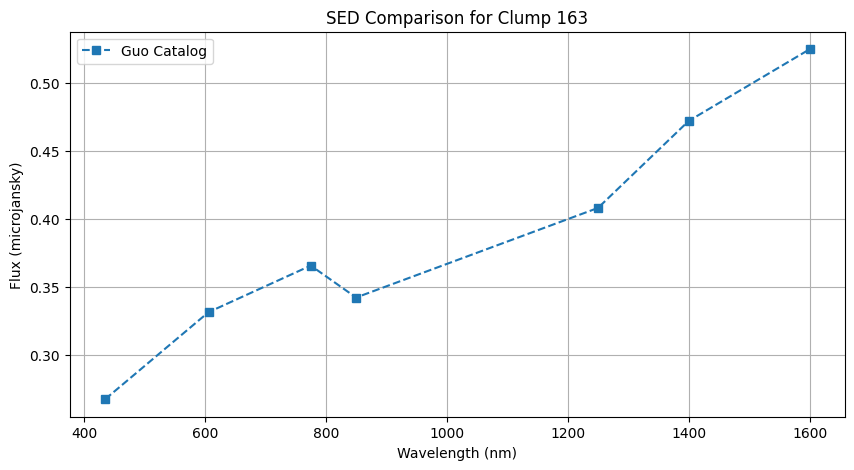

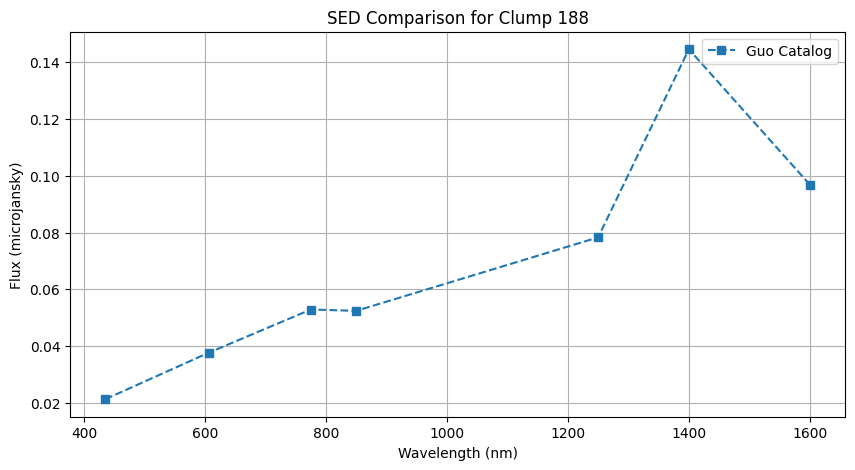

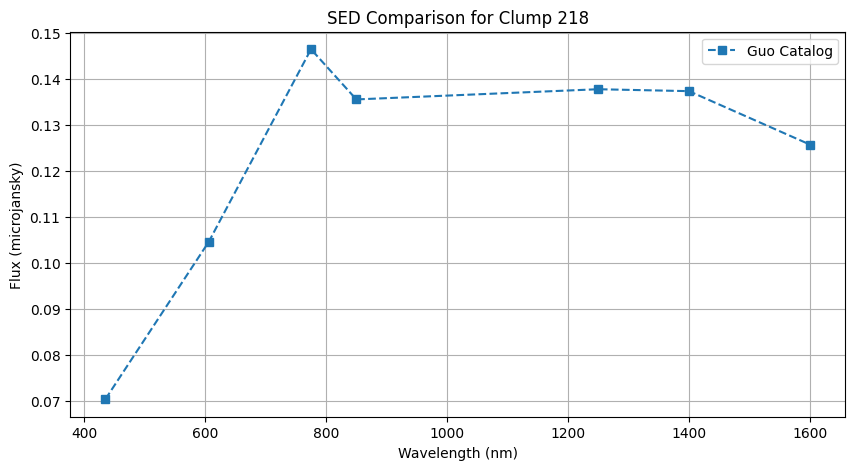

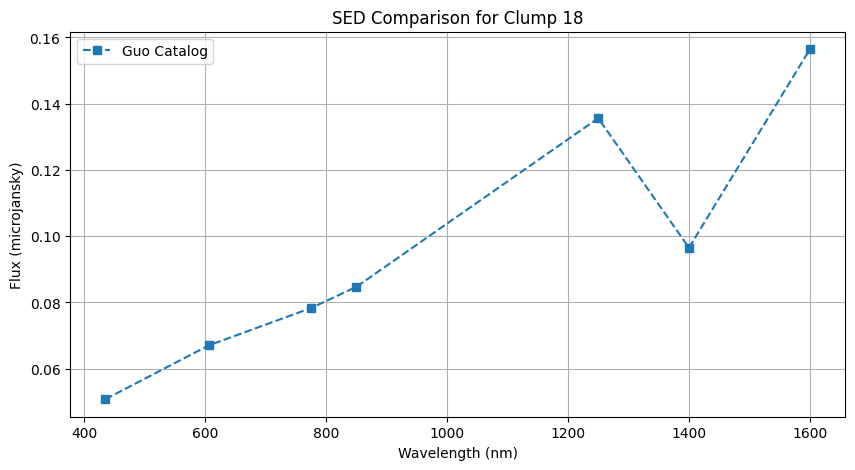

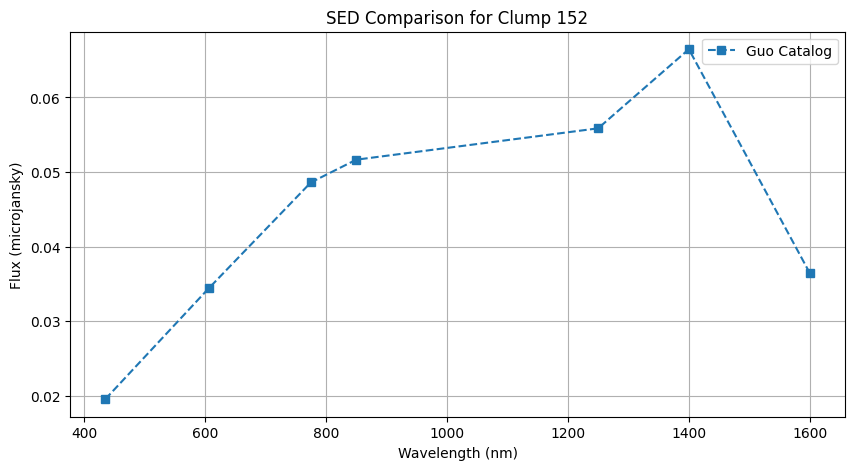

In [36]:
import random
import matplotlib.pyplot as plt
import pandas as pd

# Define the band wavelengths in nanometers
band_wavelengths = {
    'F435W': 435,
    'F606W': 606,
    'F775W': 775,
    'F850LP': 850,
    'F125W': 1250,
    'F140W': 1400,
    'F160W': 1600,
    # Add other bands as needed
}

# Assuming `matched_fluxes` contains your final matched DataFrame
# Sample 30 random clumps
random_clumps = matched_fluxes.sample(n=30, random_state=1)  # Added a random_state for reproducibility

# Loop over each random clump to plot SEDs
for idx, clump in random_clumps.iterrows():
    wavelengths_my = []
    fluxes_my = []
    wavelengths_guo = []
    fluxes_guo = []

    # Collect flux data for your catalog and Guo's catalog
    for band in band_wavelengths:
        my_flux_col = f'Corrected_Flux_{band}_mjy'
        guo_flux_col = band
        
        # Collect your catalog data
        if my_flux_col in matched_fluxes.columns and not pd.isna(clump[my_flux_col]):
            wavelengths_my.append(band_wavelengths[band])
            fluxes_my.append(clump[my_flux_col])  # Keep the flux in microjansky

        # Collect Guo's catalog data
        if guo_flux_col in matched_fluxes.columns and not pd.isna(clump[guo_flux_col]):
            wavelengths_guo.append(band_wavelengths[band])
            fluxes_guo.append(clump[guo_flux_col])

    # Plot the SED for the clump
    plt.figure(figsize=(10, 5))
    if fluxes_my:
        plt.plot(wavelengths_my, fluxes_my, 'o-', label='My Catalog')
    if fluxes_guo:
        plt.plot(wavelengths_guo, fluxes_guo, 's--', label='Guo Catalog')

    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Flux (microjansky)')
    plt.title(f'SED Comparison for Clump {idx}')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Close the figure to free up memory
    plt.close()


/var/folders/by/26kj85kd3w94p3xv_m2206b40000gn/T/ipykernel_54615/1708951301.py:21: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  random_clumps_indices = random.sample(set(matched_fluxes.index), min(30, len(matched_fluxes)))


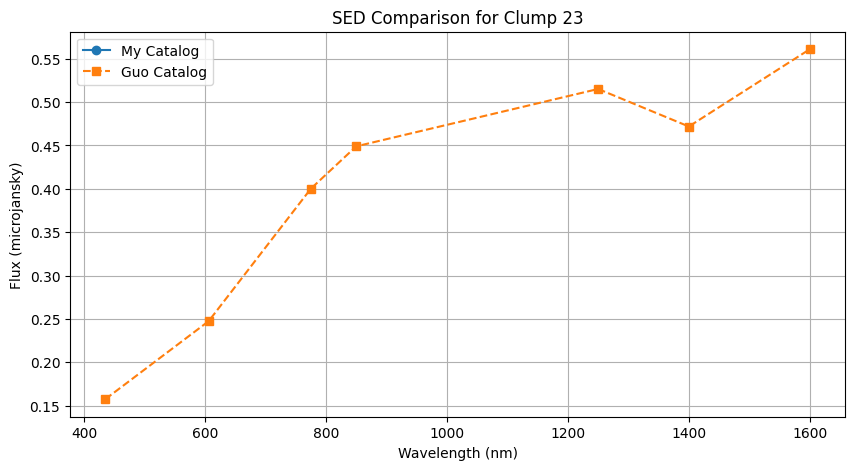

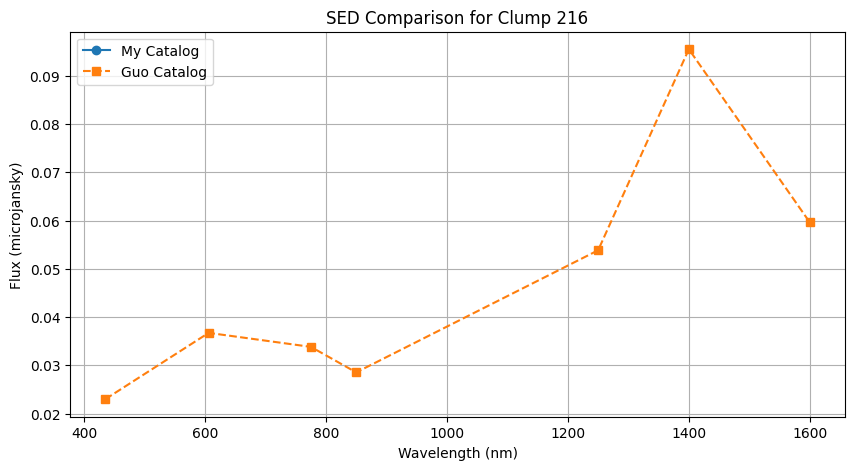

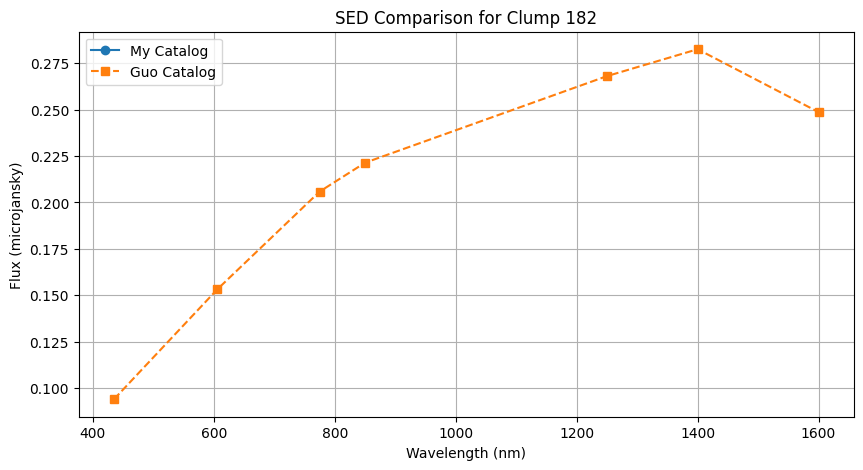

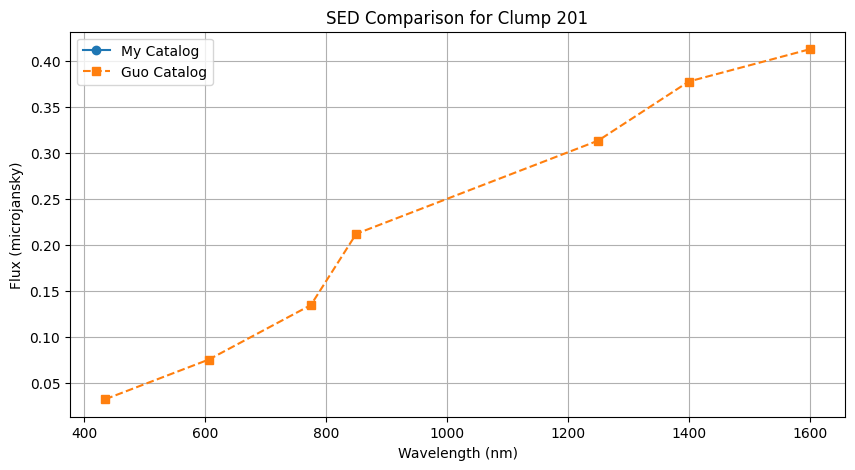

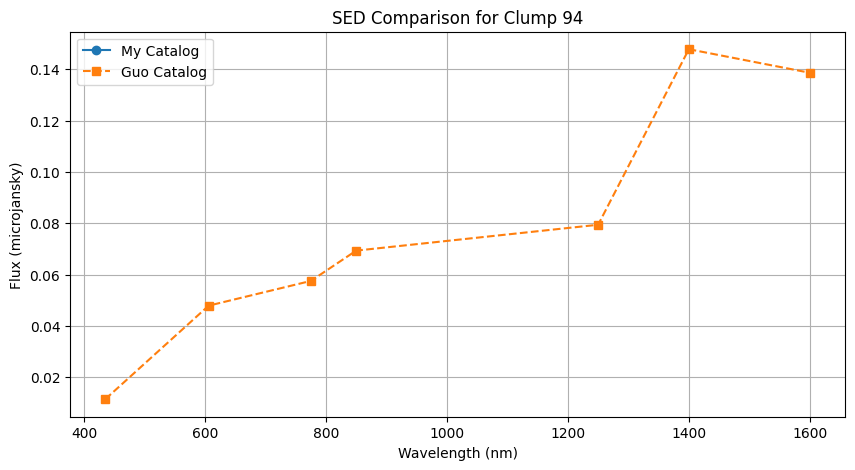

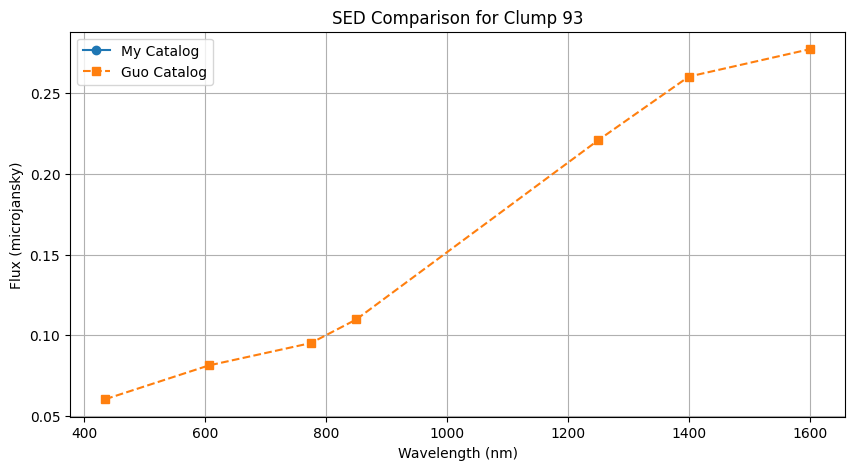

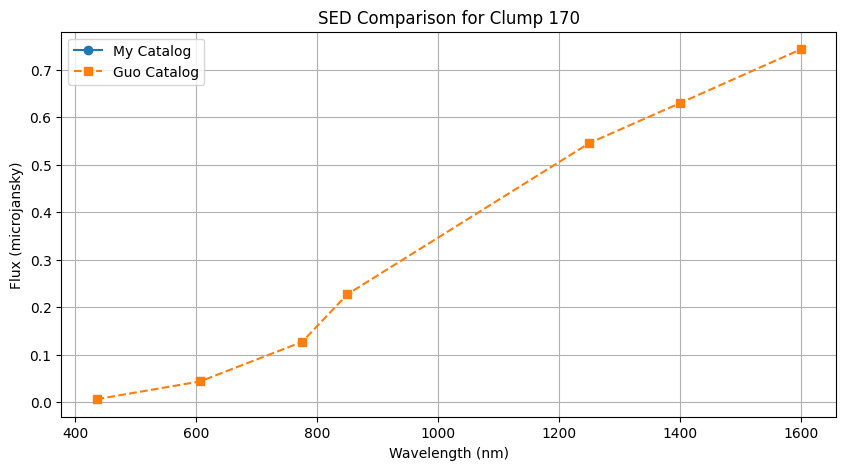

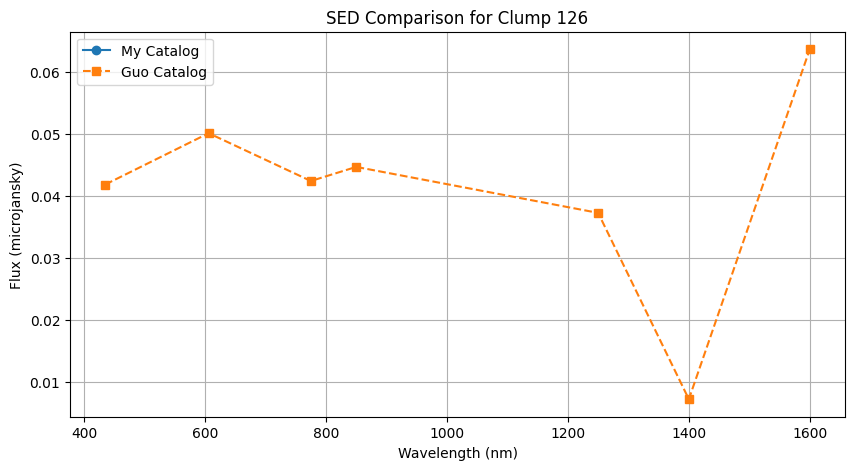

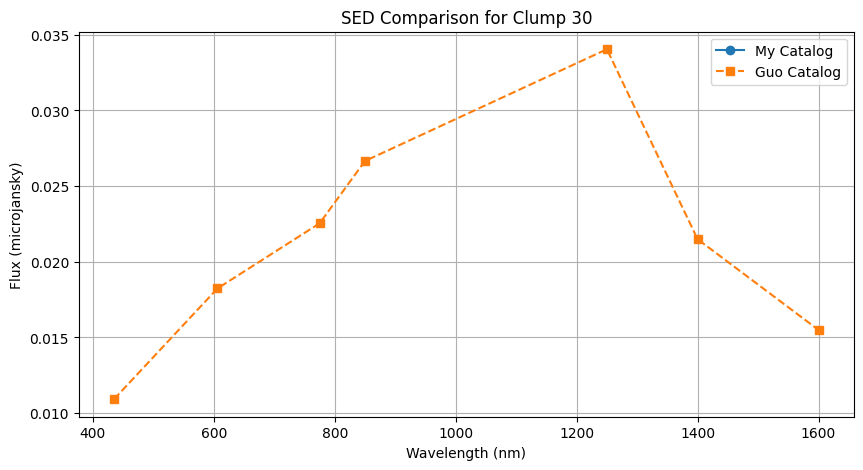

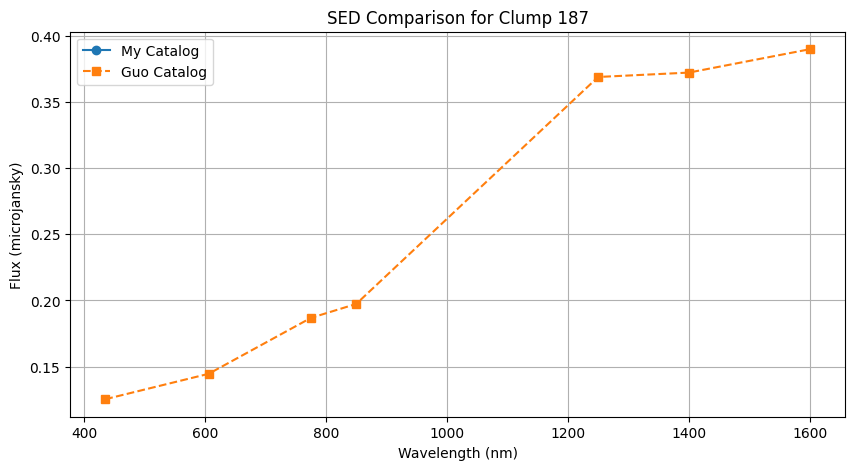

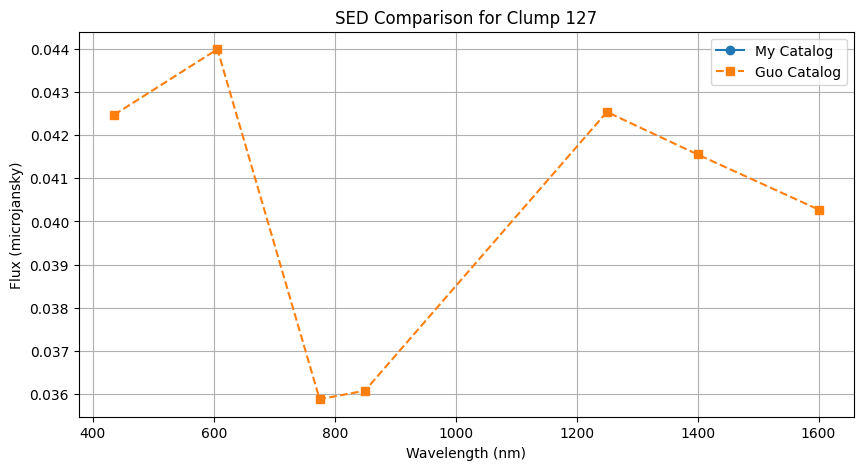

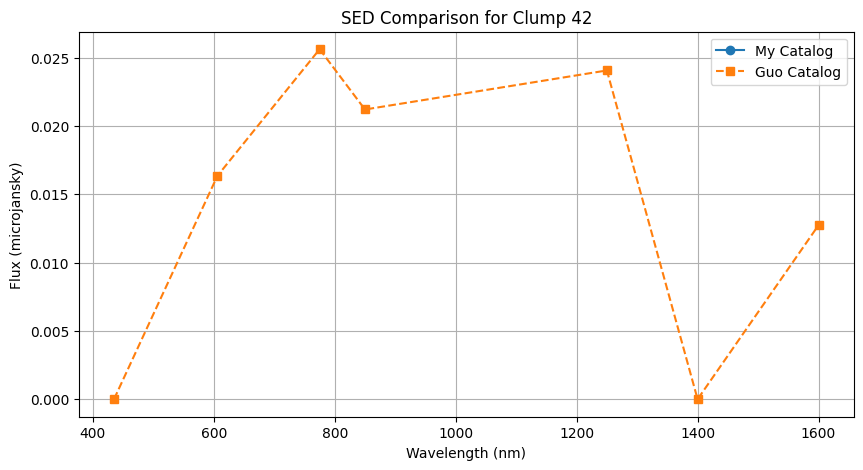

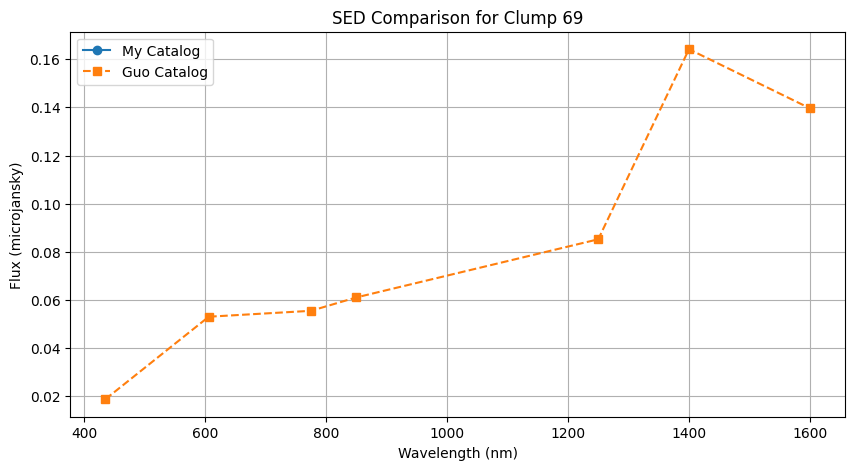

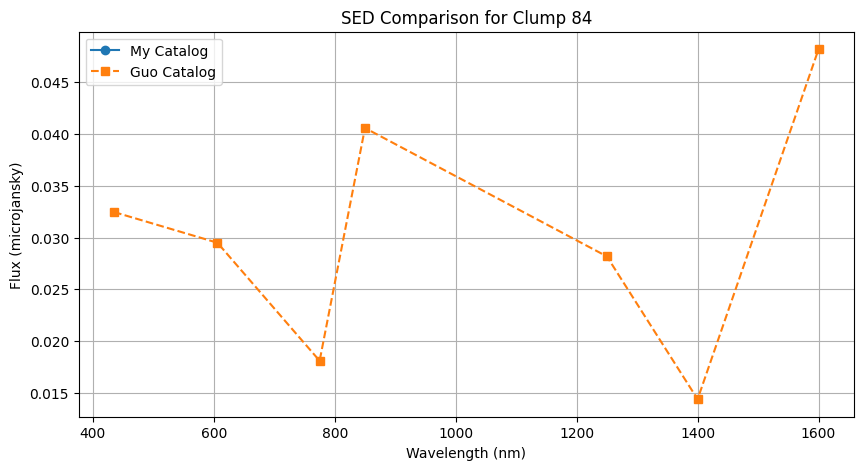

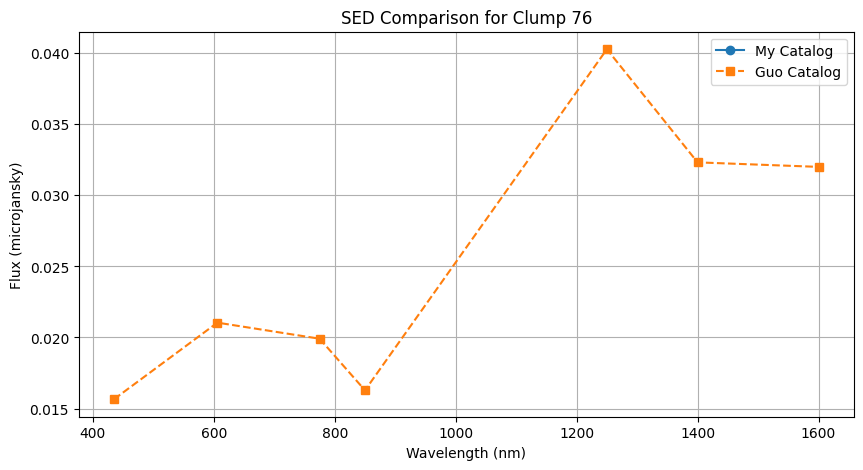

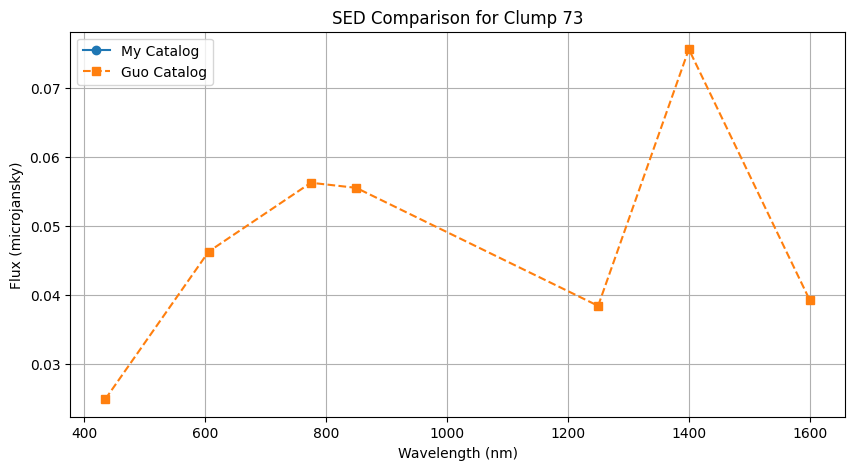

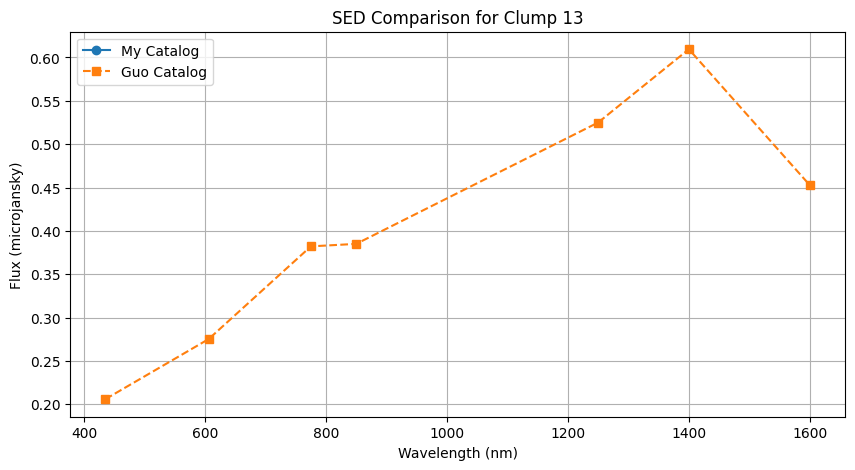

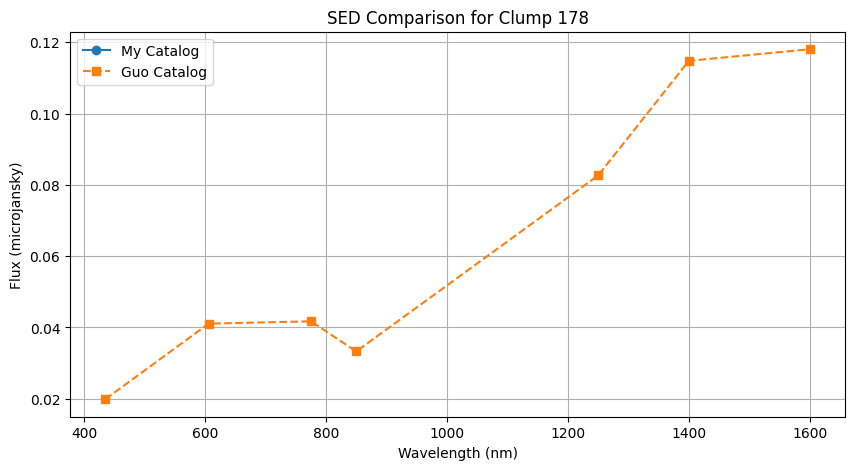

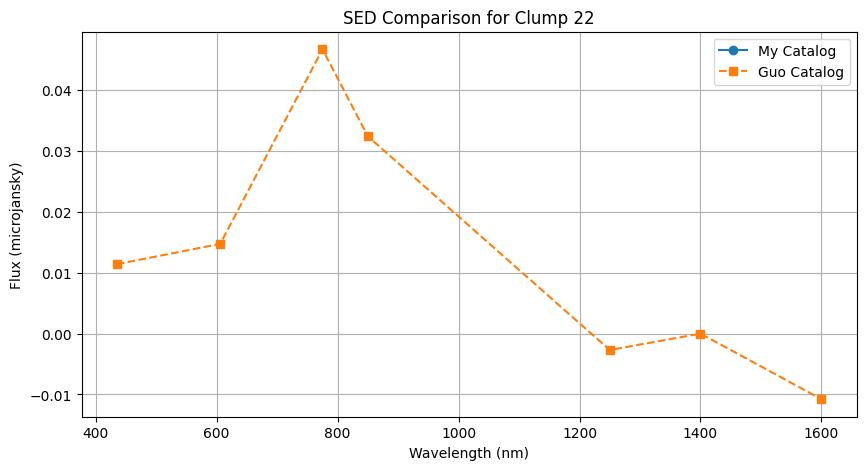

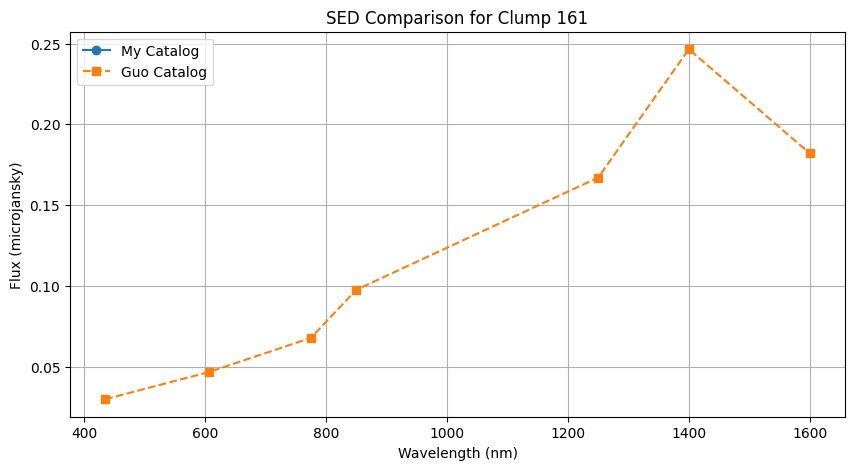

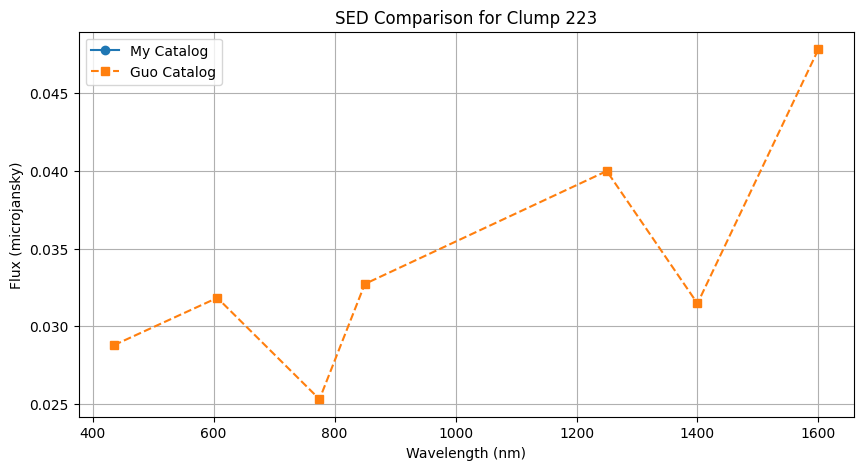

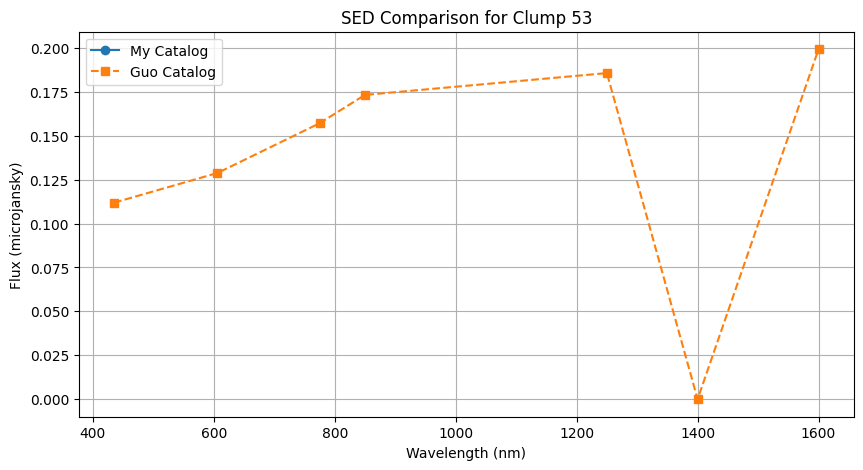

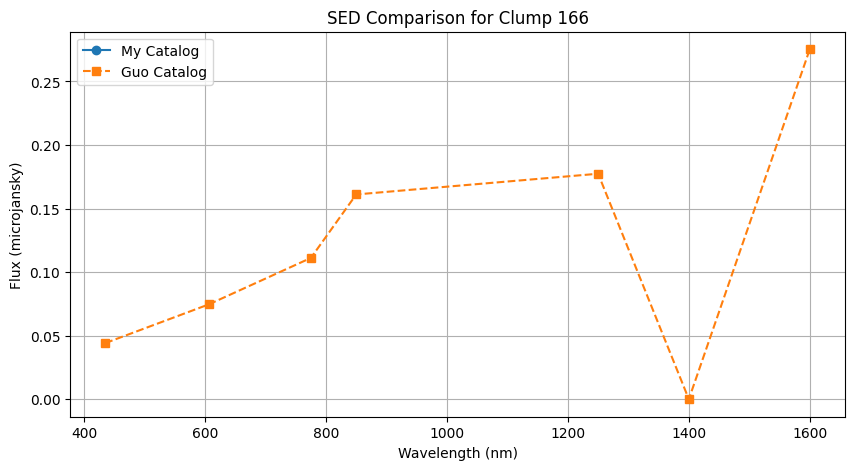

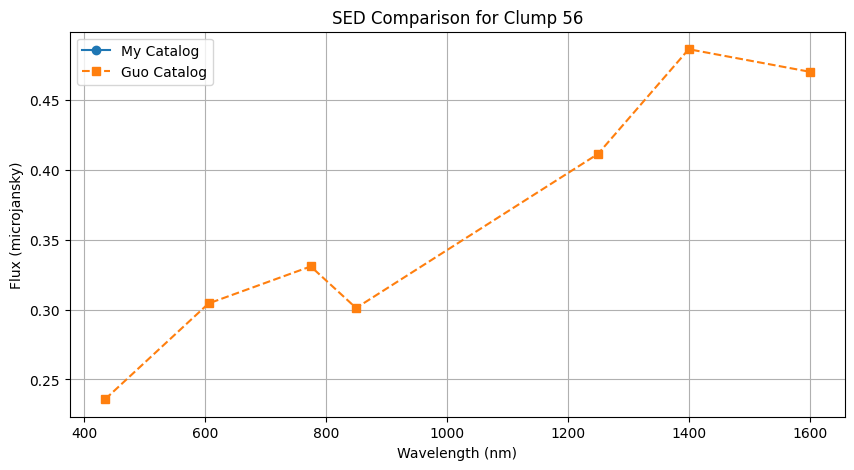

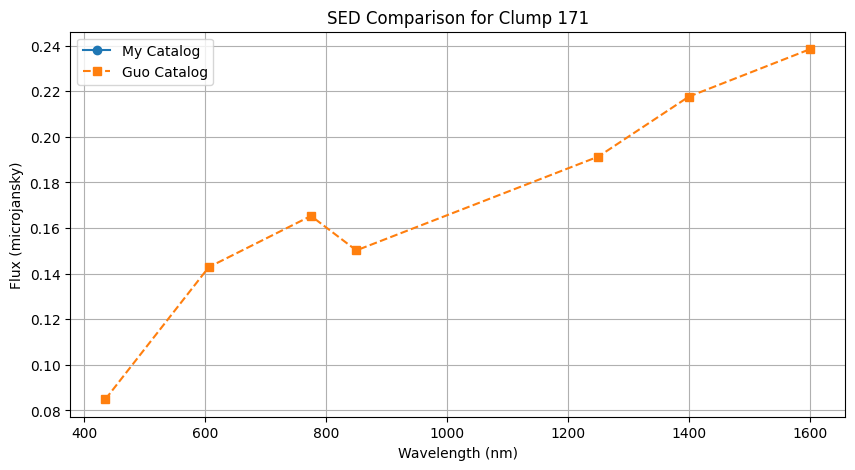

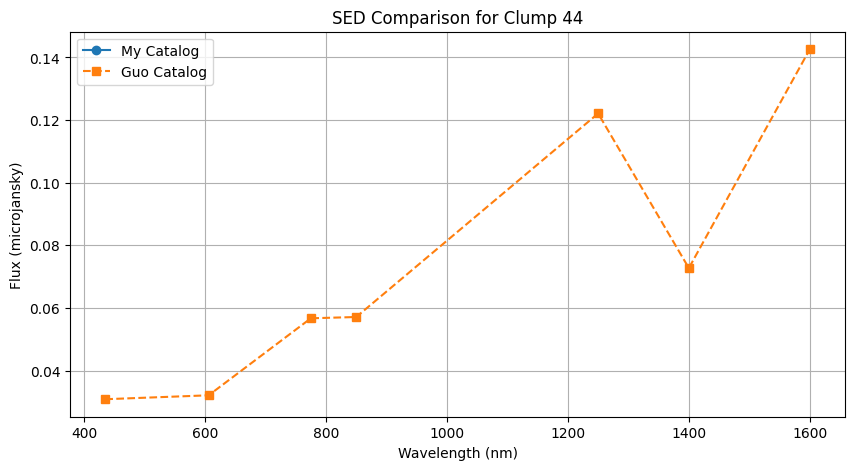

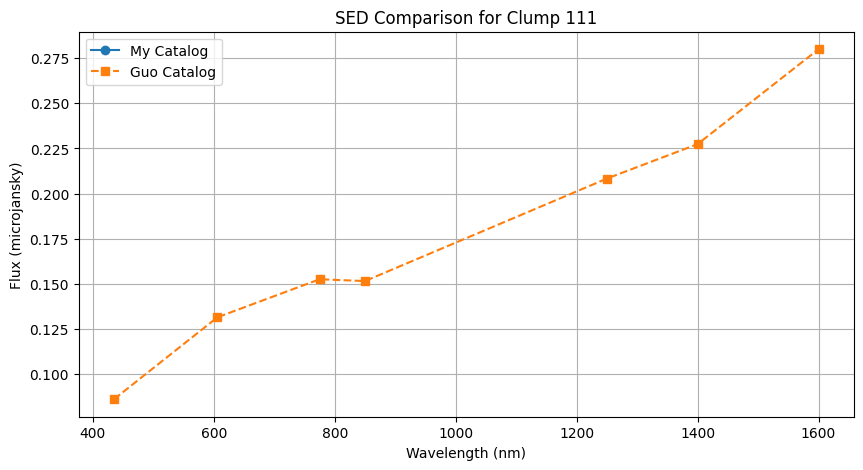

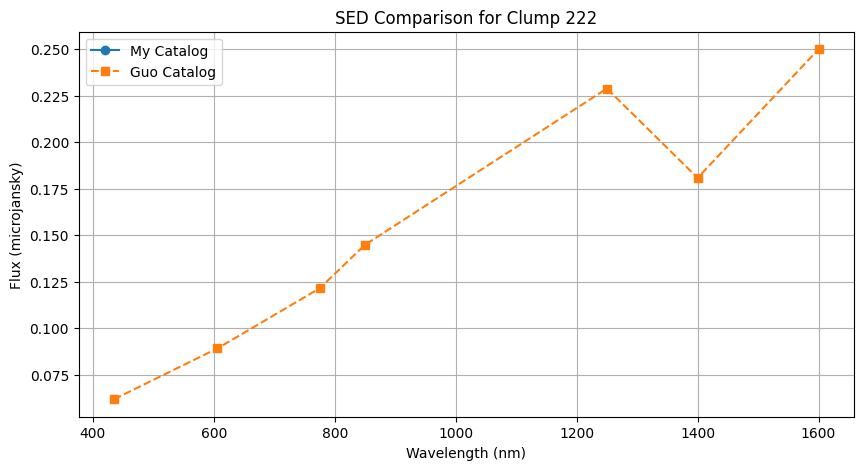

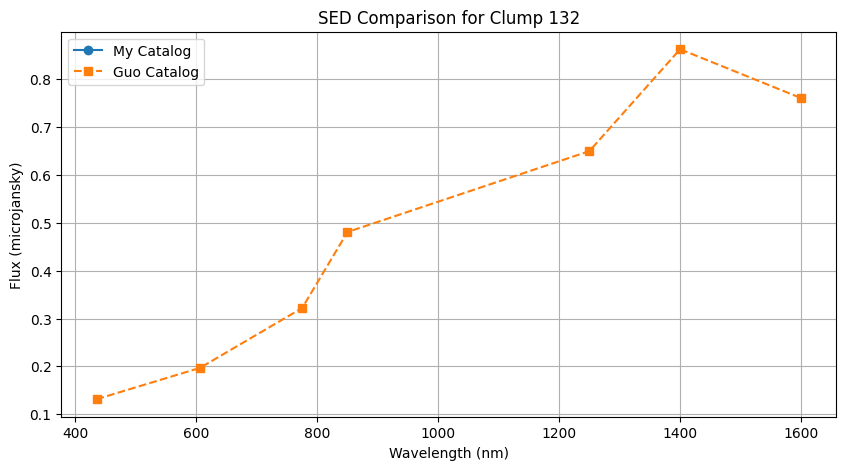

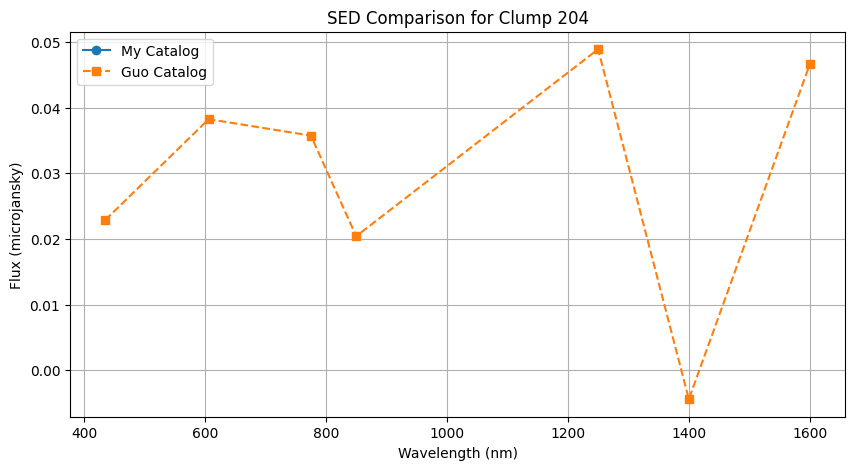

In [40]:
import random
import matplotlib.pyplot as plt
import pandas as pd

# Define the band wavelengths in nanometers for Guo's catalog
guo_band_wavelengths = {
    'F435W': 435,
    'F606W': 606,
    'F775W': 775,
    'F850LP': 850,
    'F125W': 1250,
    'F140W': 1400,
    'F160W': 1600,
    # Add other bands as needed
}

# Define the band suffixes for your catalog
my_band_suffixes = ['f125w', 'f160w', 'f275w', 'f435w', 'f606w', 'f775w', 'f850lp', 'f140w']

# Sample 30 random clumps ensuring they are within the matched_fluxes index range
random_clumps_indices = random.sample(set(matched_fluxes.index), min(30, len(matched_fluxes)))
random_clumps = matched_fluxes.loc[random_clumps_indices]

# Loop over each random clump to plot SEDs
for idx in random_clumps_indices:
    clump = matched_fluxes.loc[idx]
    wavelengths_my = []
    fluxes_my = []
    wavelengths_guo = []
    fluxes_guo = []

    # Collect flux data for your catalog
    for band_suffix in my_band_suffixes:
        my_flux_col = f'Corrected_Flux_{band_suffix}_mjy'
        
        # Check if the column exists in your catalog and if the value is not NaN
        if my_flux_col in clump and not pd.isna(clump[my_flux_col]):
            # Assume the wavelength for your catalog's band is the same as Guo's for simplicity
            wavelengths_my.append(guo_band_wavelengths.get(f'F{band_suffix.upper()}', None))
            fluxes_my.append(clump[my_flux_col])

    # Collect flux data for Guo's catalog
    for guo_band, wl in guo_band_wavelengths.items():
        guo_flux_col = guo_band
        
        # Check if the column exists in Guo's catalog and if the value is not NaN
        if guo_flux_col in clump and not pd.isna(clump[guo_flux_col]):
            wavelengths_guo.append(wl)
            fluxes_guo.append(clump[guo_flux_col])

    # Plot the SED for the clump
    plt.figure(figsize=(10, 5))
    if wavelengths_my and fluxes_my:
        plt.plot(wavelengths_my, fluxes_my, 'o-', label='My Catalog')
    if wavelengths_guo and fluxes_guo:
        plt.plot(wavelengths_guo, fluxes_guo, 's--', label='Guo Catalog')

    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Flux (microjansky)')
    plt.title(f'SED Comparison for Clump {idx}')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Close the figure to free up memory
    plt.close()


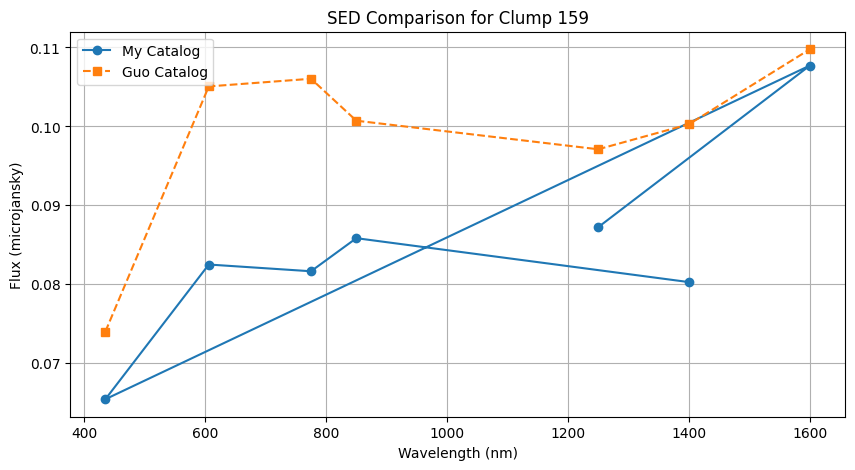

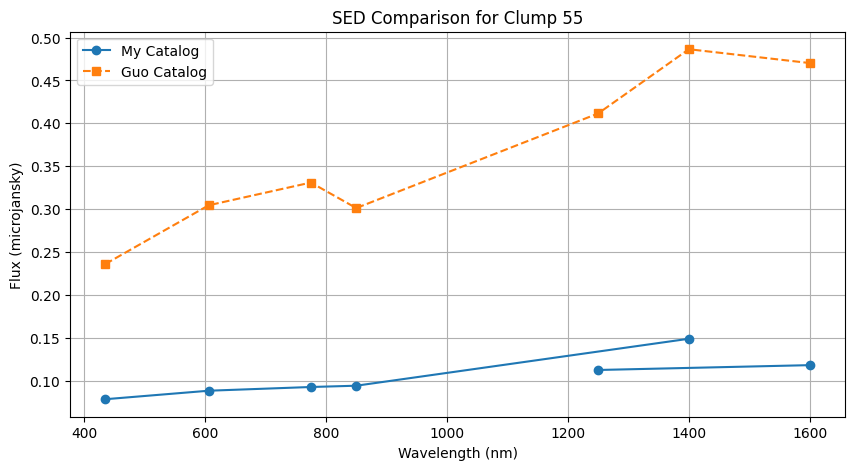

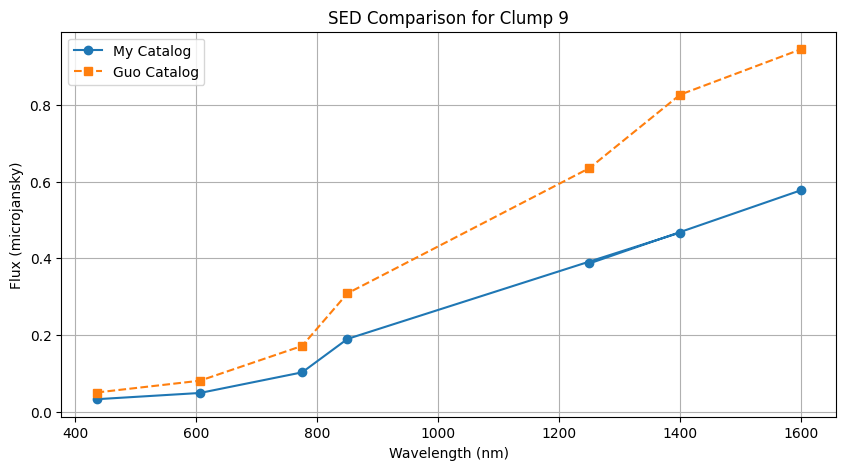

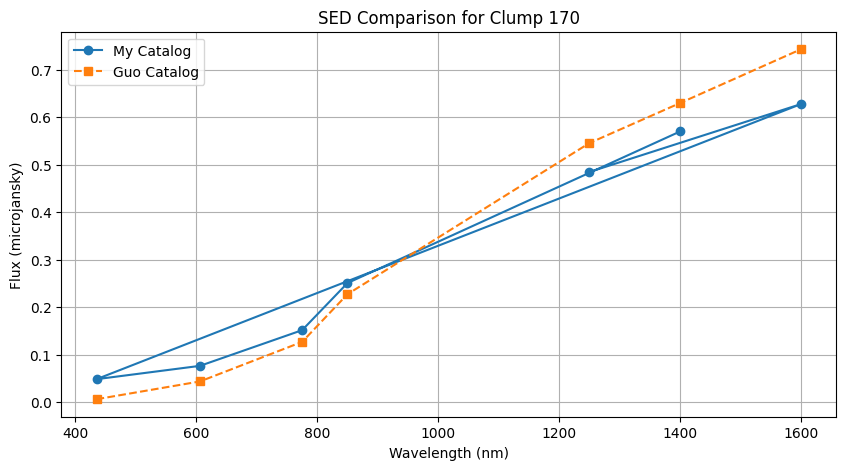

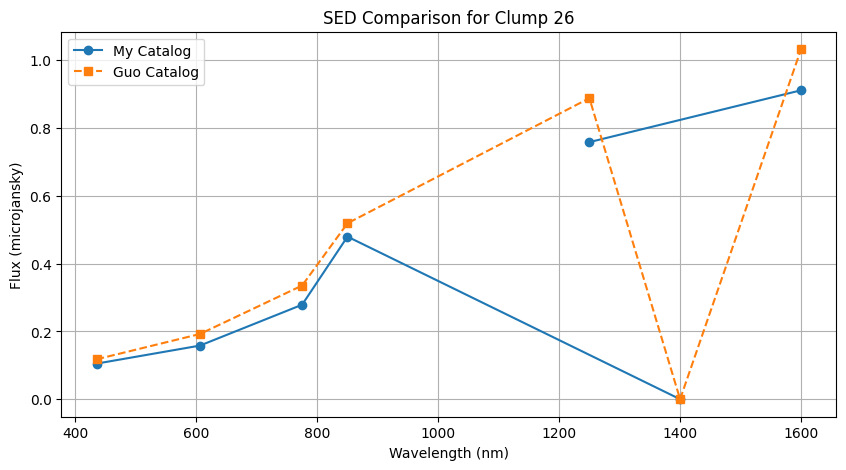

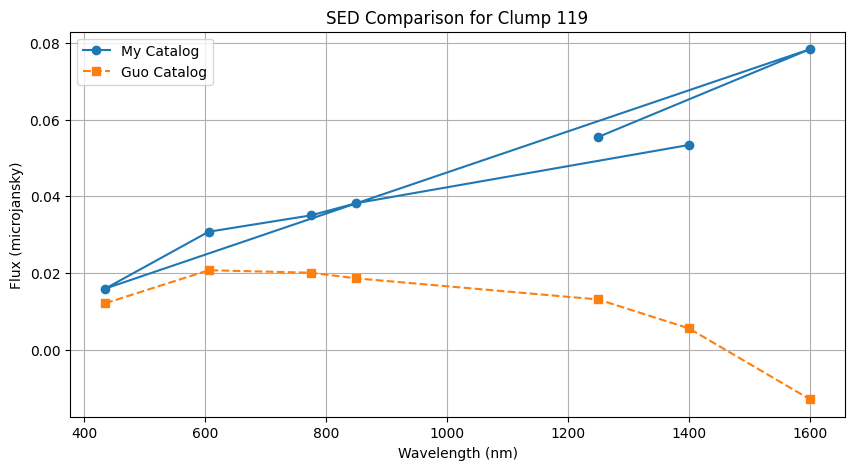

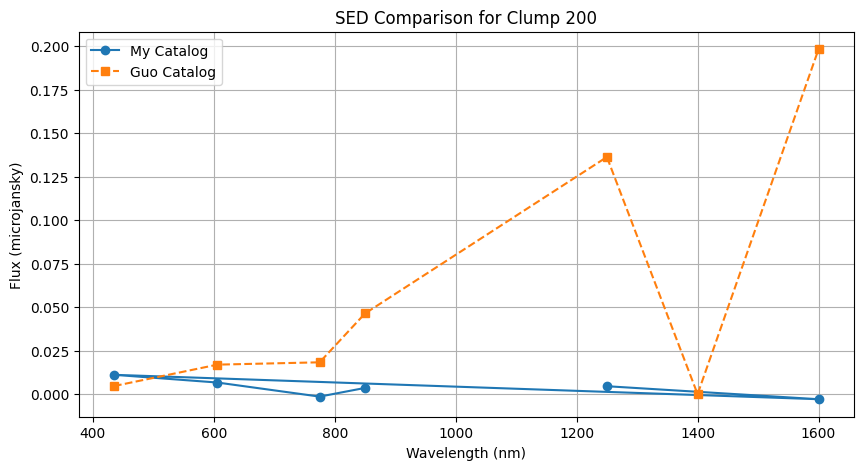

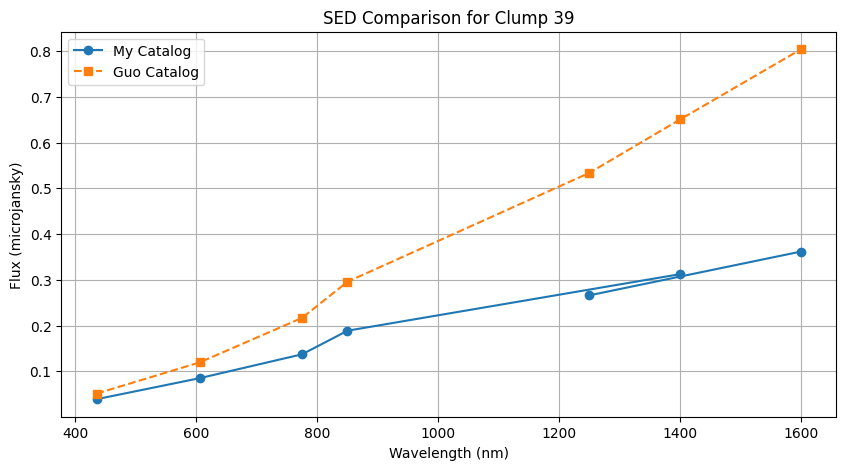

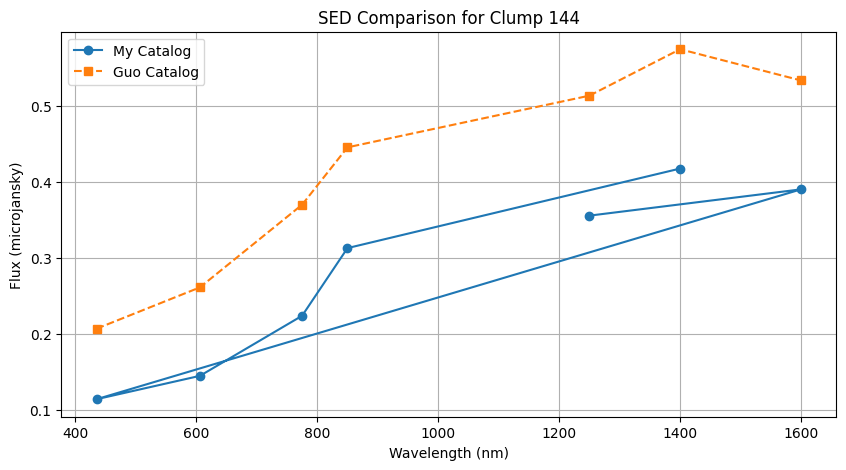

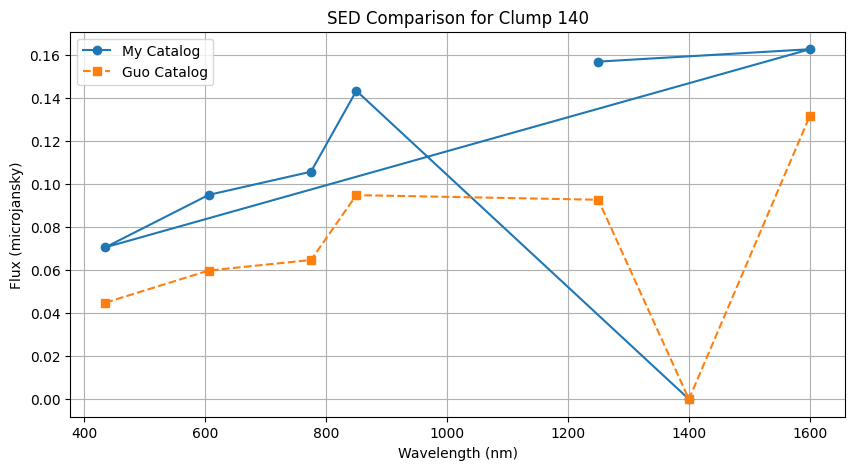

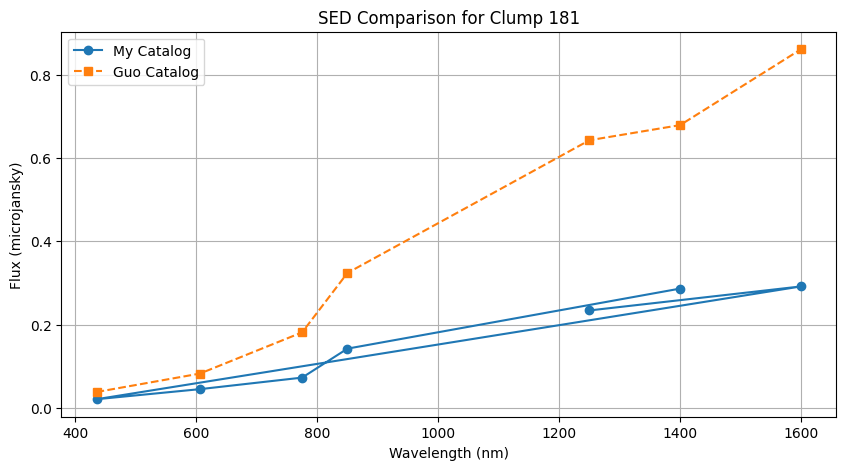

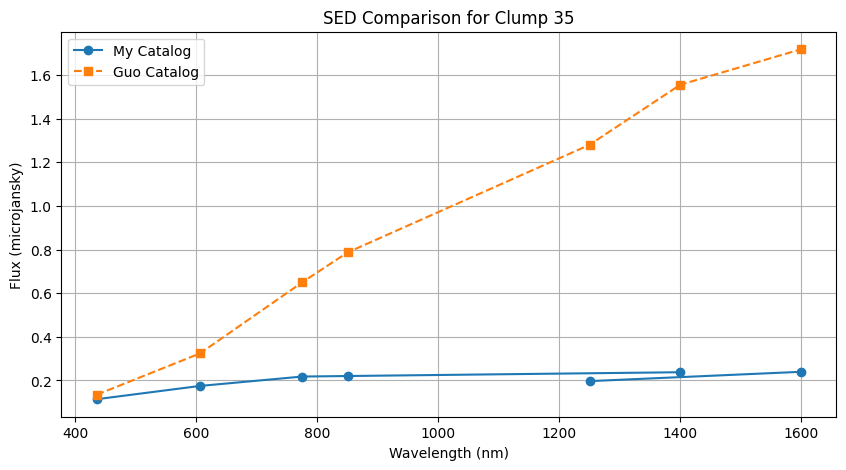

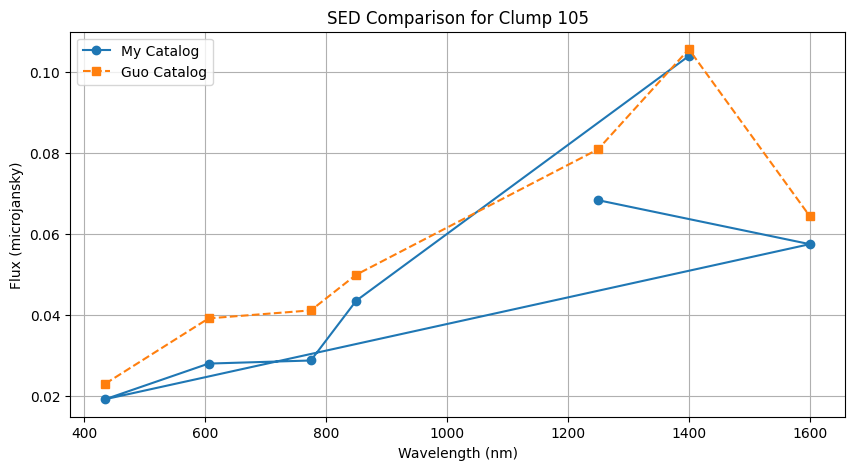

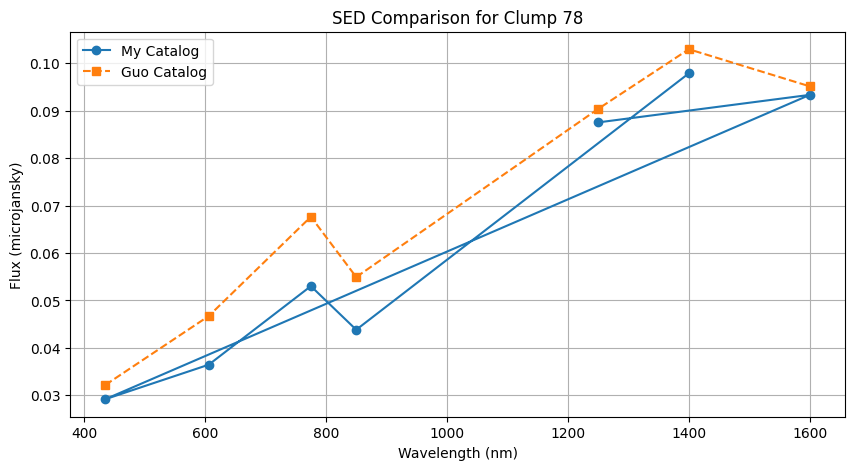

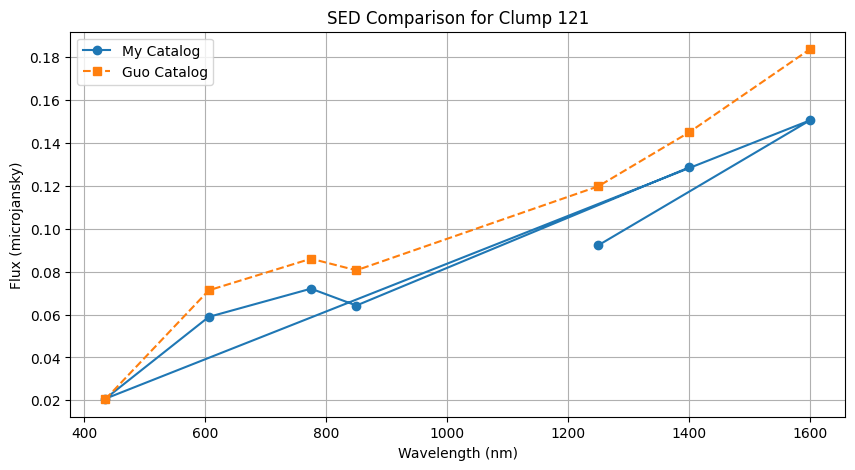

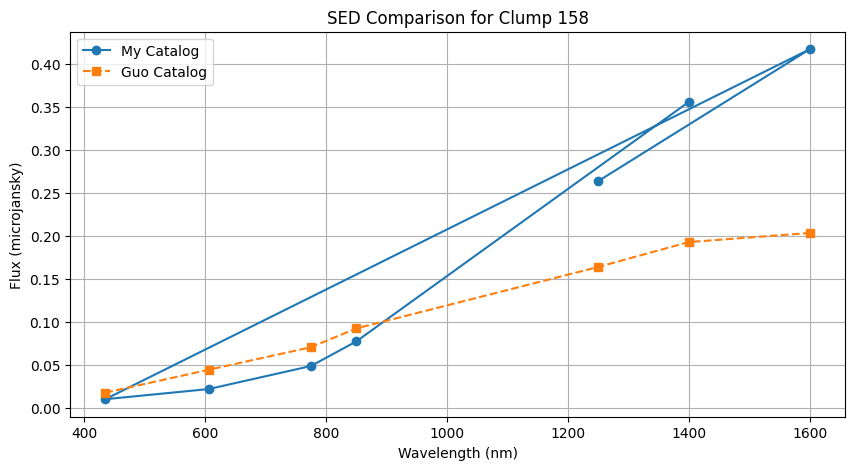

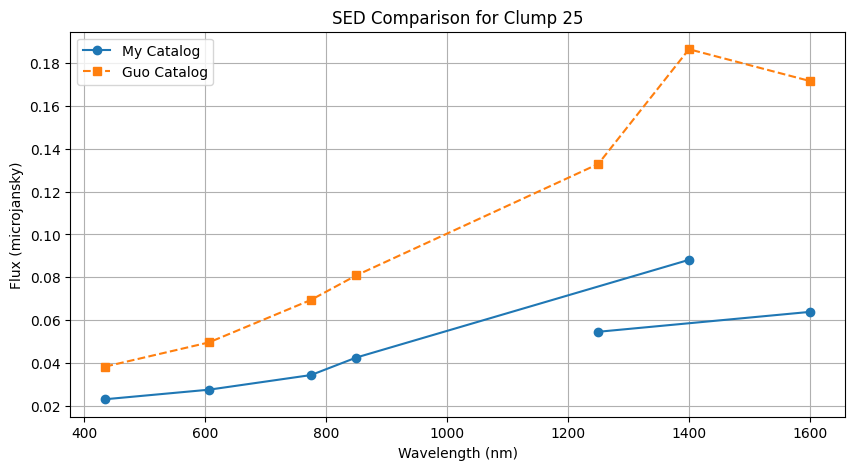

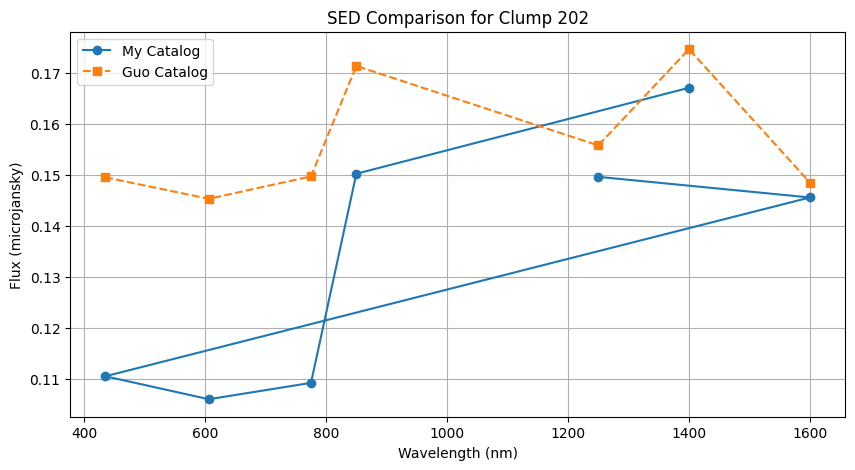

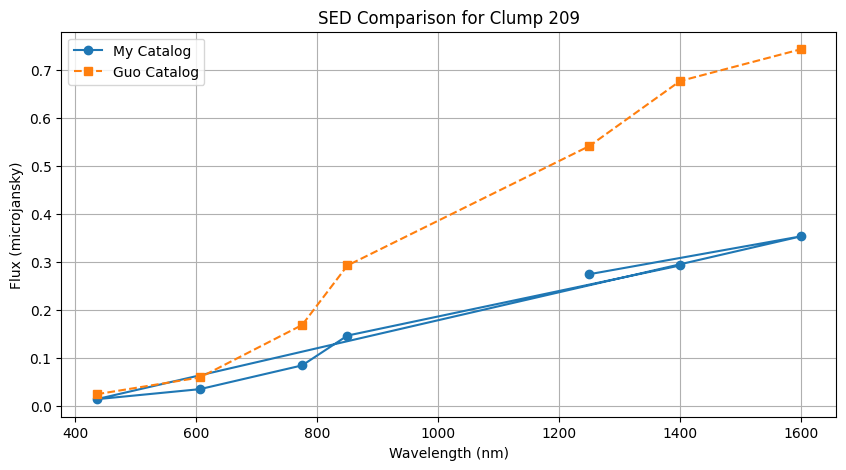

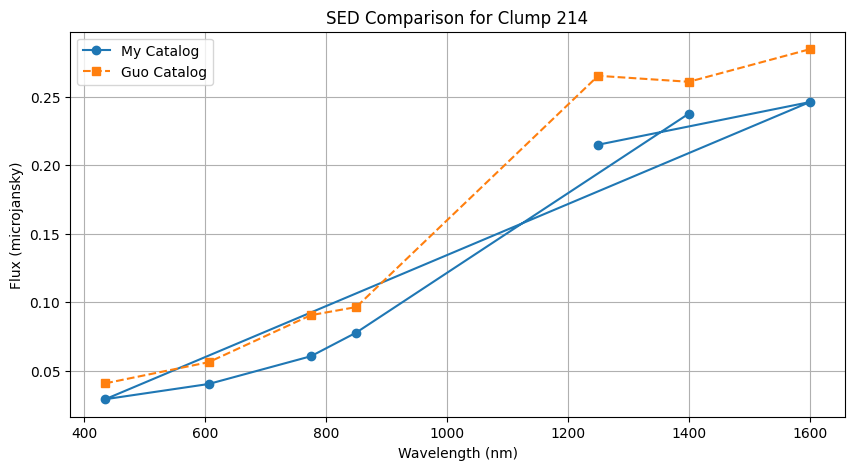

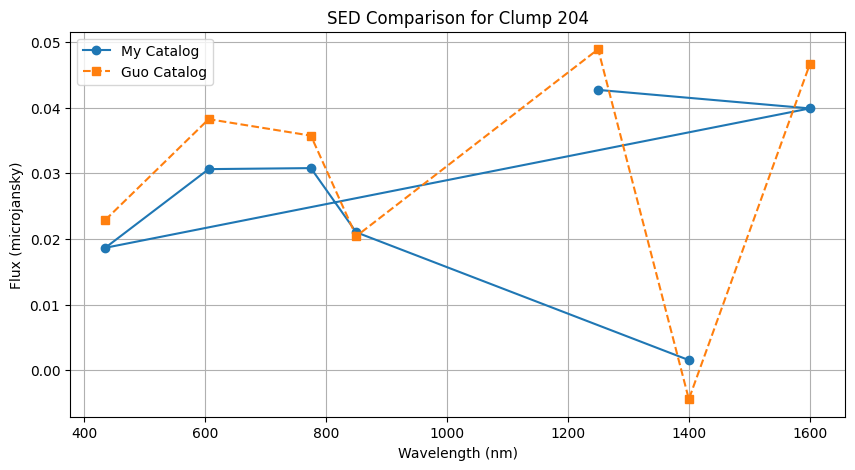

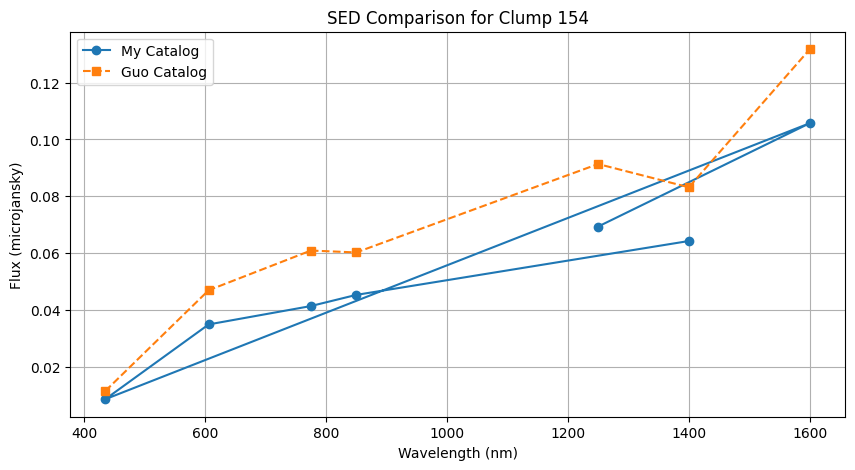

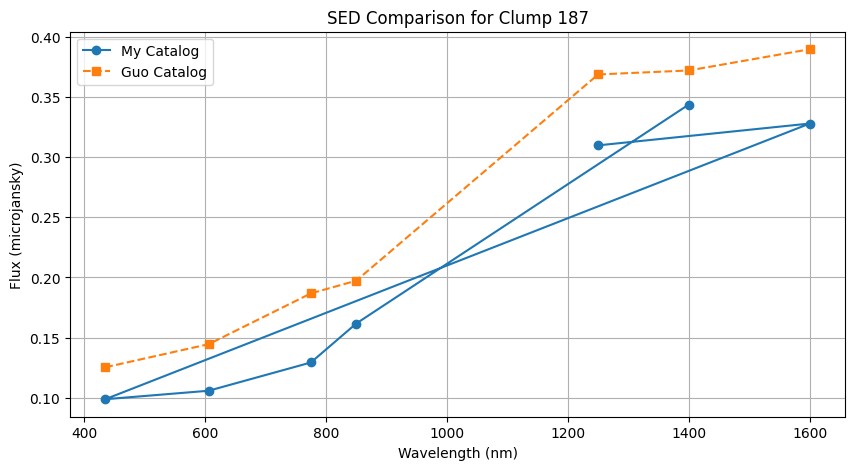

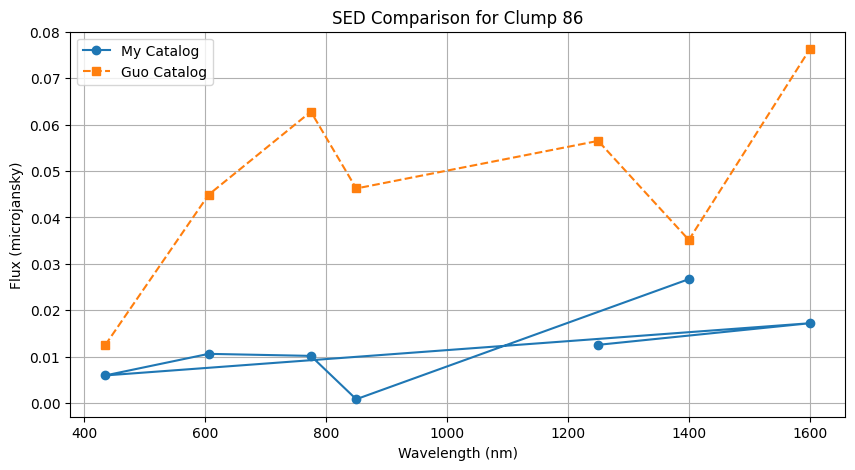

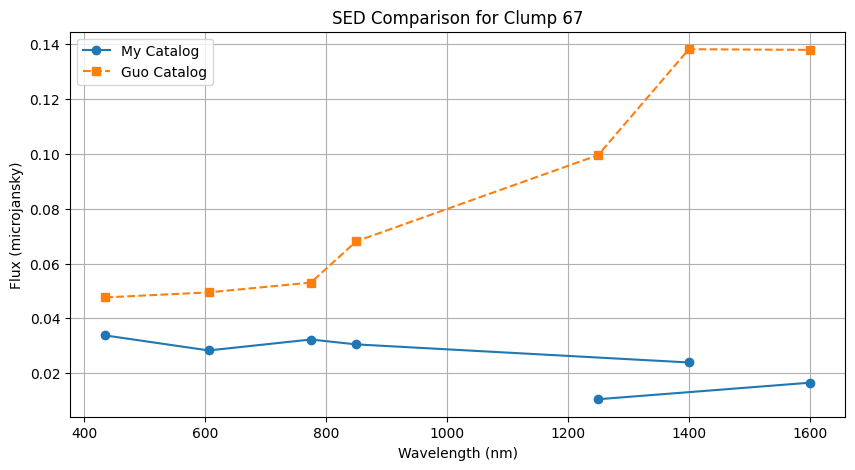

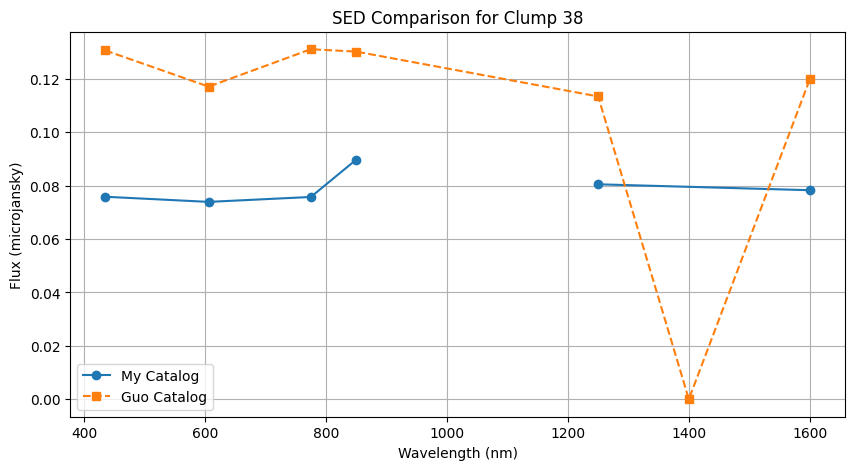

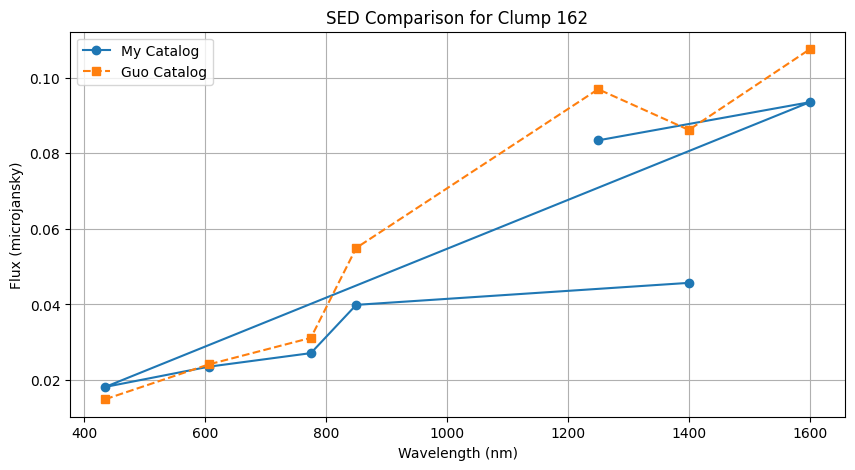

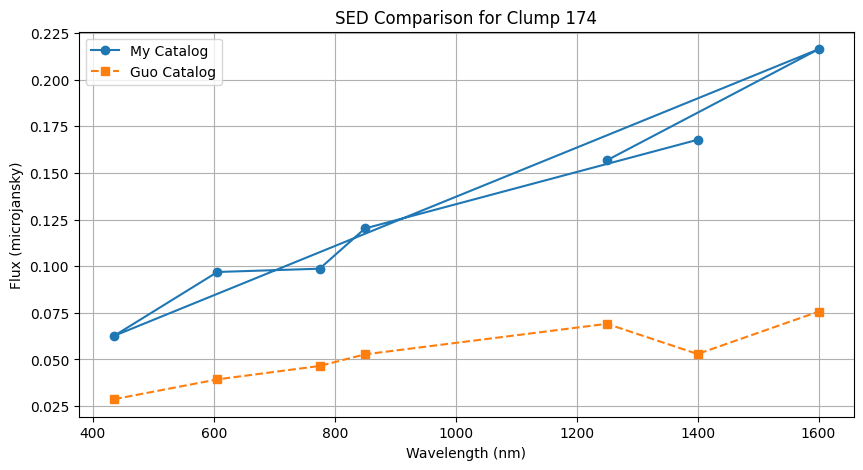

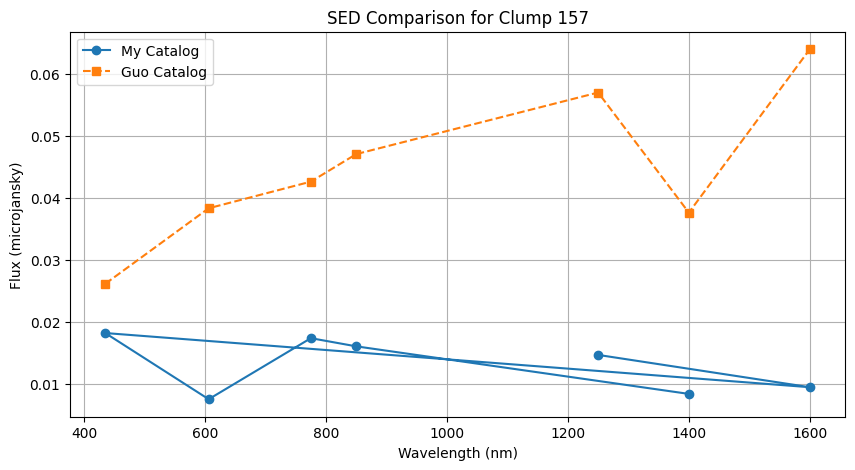

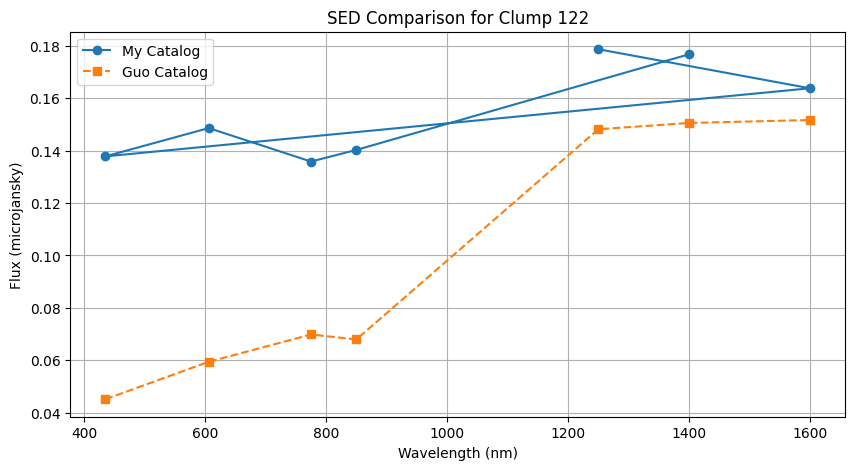

In [41]:
# Sample 30 random clumps
random_clumps_indices = random.sample(list(matched_fluxes.index), min(30, len(matched_fluxes)))
random_clumps = matched_fluxes.loc[random_clumps_indices]

# Loop over each random clump to plot SEDs
for idx in random_clumps_indices:
    clump = matched_fluxes.loc[idx]
    wavelengths_my = []
    fluxes_my = []
    wavelengths_guo = []
    fluxes_guo = []

    # Collect flux data for your catalog and Guo's catalog
    for band_suffix in my_band_suffixes:
        my_flux_col = f'Corrected_Flux_{band_suffix}_mjy'
        
        # Check if the column exists in your catalog and if the value is not NaN
        if my_flux_col in matched_fluxes.columns and not pd.isna(clump[my_flux_col]):
            # Assume the wavelength for your catalog's band is the same as Guo's for simplicity
            wavelengths_my.append(guo_band_wavelengths.get(band_suffix.upper(), None))
            fluxes_my.append(clump[my_flux_col])

    # Collect flux data for Guo's catalog
    for guo_band, wl in guo_band_wavelengths.items():
        guo_flux_col = guo_band
        
        # Check if the column exists in Guo's catalog and if the value is not NaN
        if guo_flux_col in matched_fluxes.columns and not pd.isna(clump[guo_flux_col]):
            wavelengths_guo.append(wl)
            fluxes_guo.append(clump[guo_flux_col])

    # Plot the SED for the clump if there is data
    if wavelengths_my or wavelengths_guo:  # Check if there is any data to plot
        plt.figure(figsize=(10, 5))
        if wavelengths_my:
            plt.plot(wavelengths_my, fluxes_my, 'o-', label='My Catalog')
        if wavelengths_guo:
            plt.plot(wavelengths_guo, fluxes_guo, 's--', label='Guo Catalog')

        plt.xlabel('Wavelength (nm)')
        plt.ylabel('Flux (microjansky)')
        plt.title(f'SED Comparison for Clump {idx}')
        plt.legend()
        plt.grid(True)
        plt.show()
        plt.close()  # Close the figure after showing it
    else:
        print(f'No data available to plot SED for clump {idx}')


/var/folders/by/26kj85kd3w94p3xv_m2206b40000gn/T/ipykernel_54615/2993779142.py:22: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  random_clumps_indices = random.sample(set(matched_fluxes.index), min(30, len(matched_fluxes)))


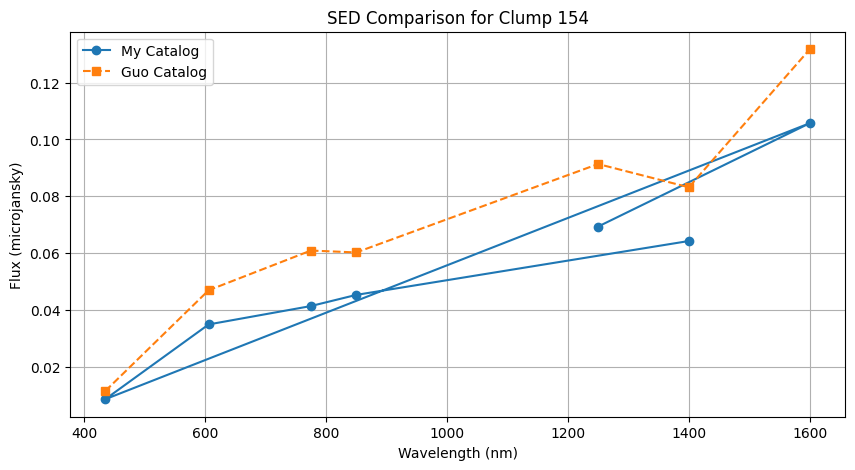

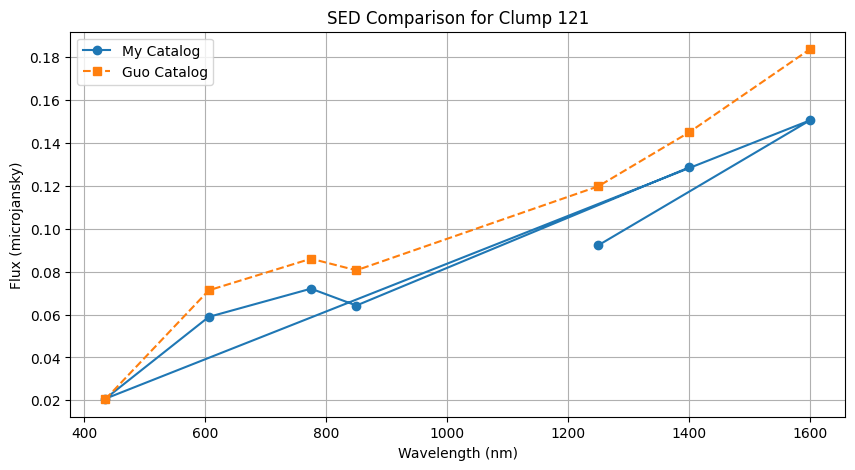

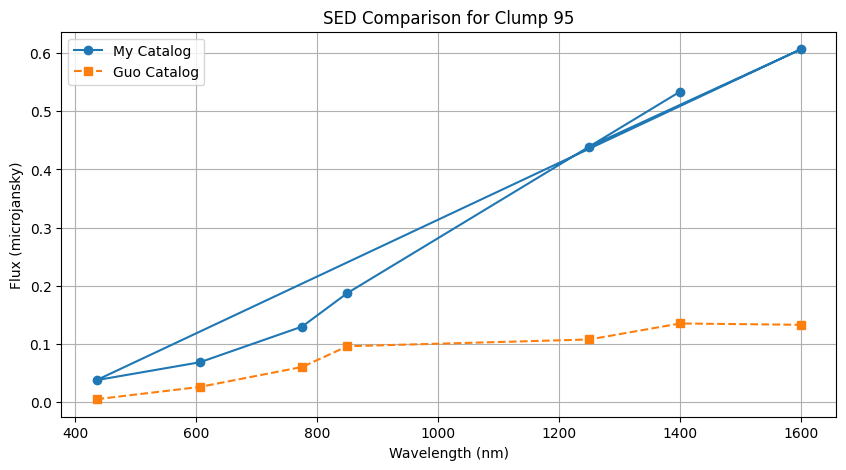

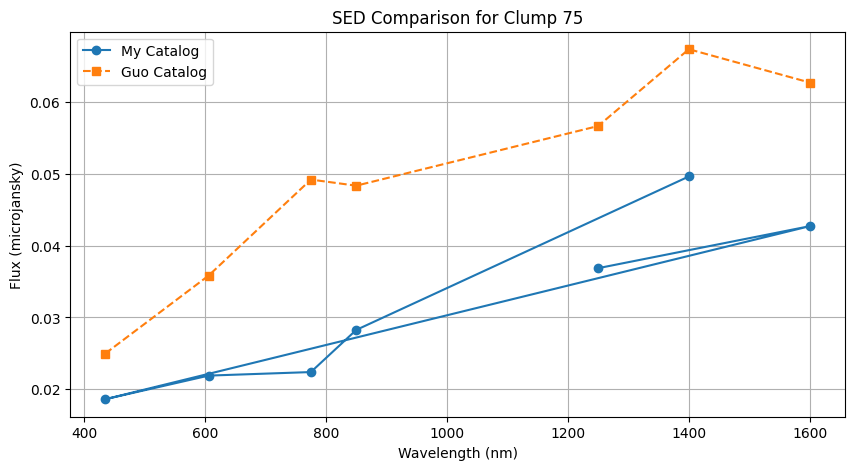

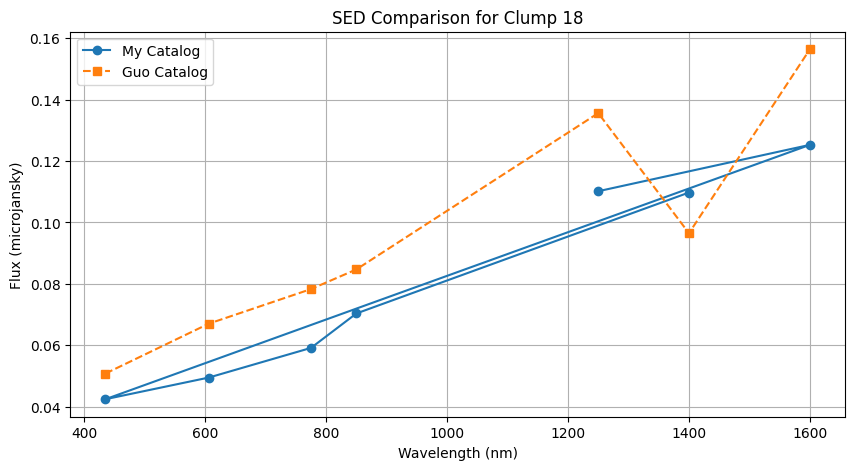

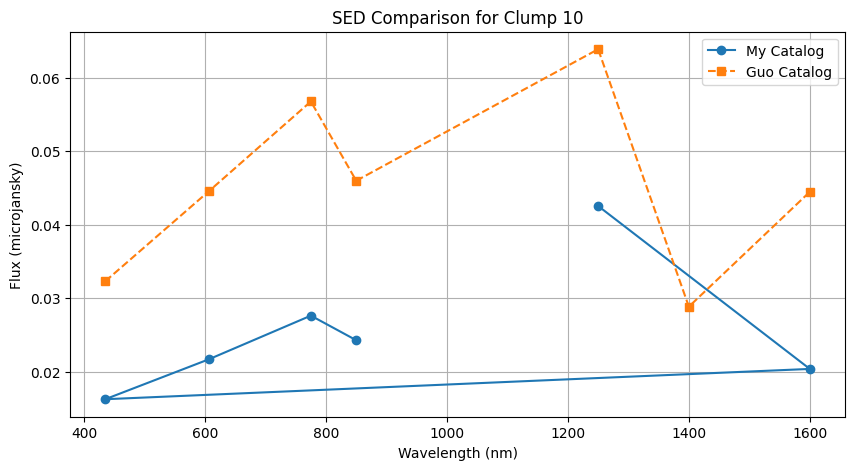

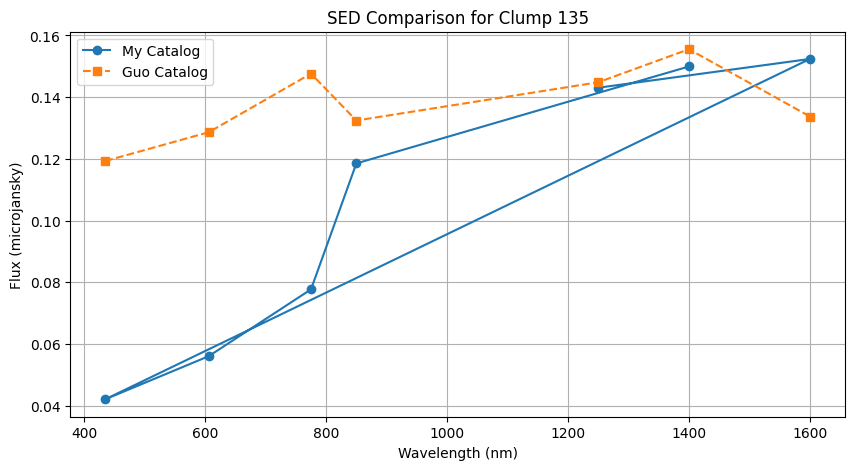

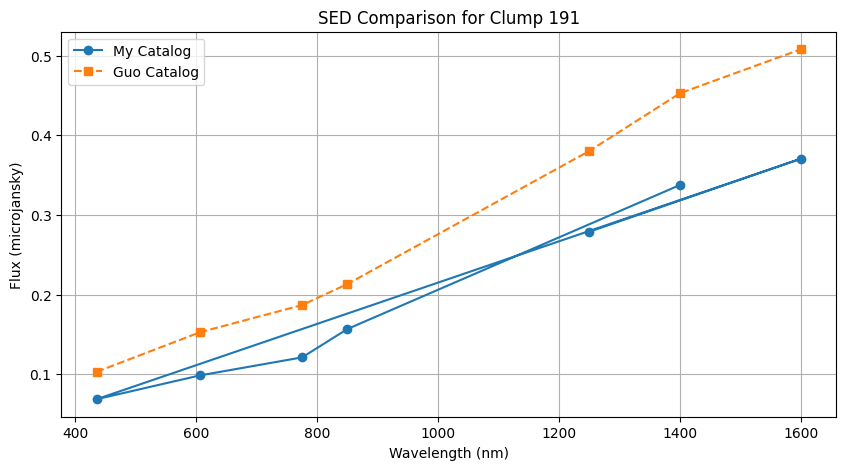

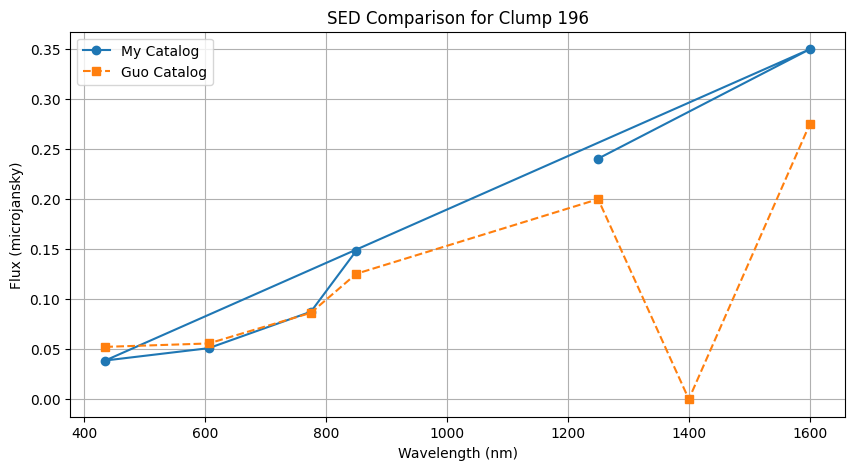

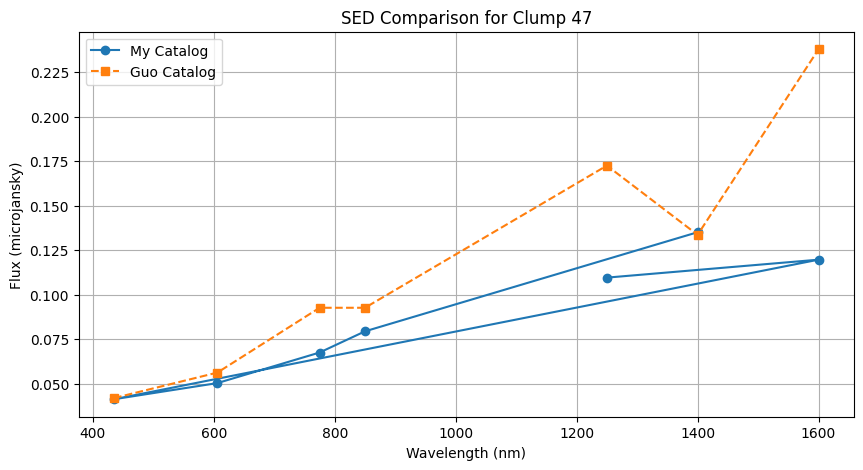

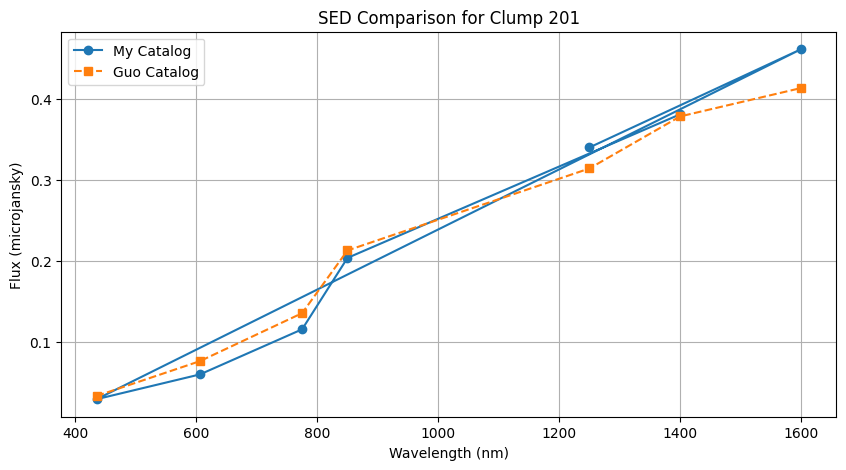

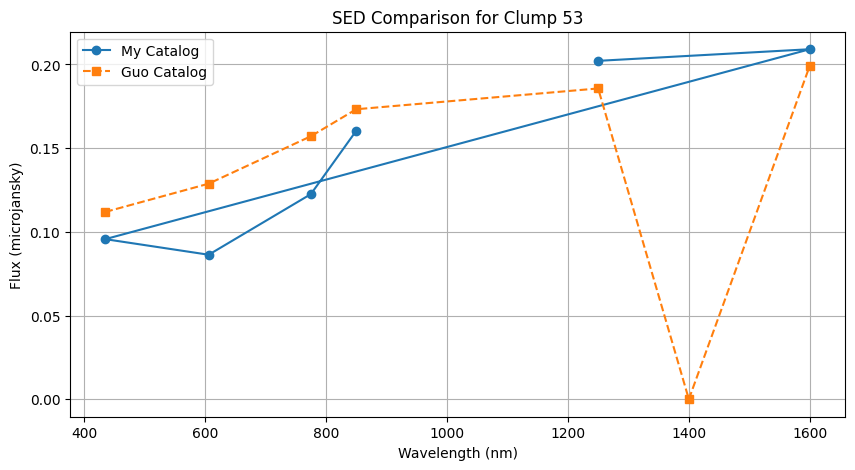

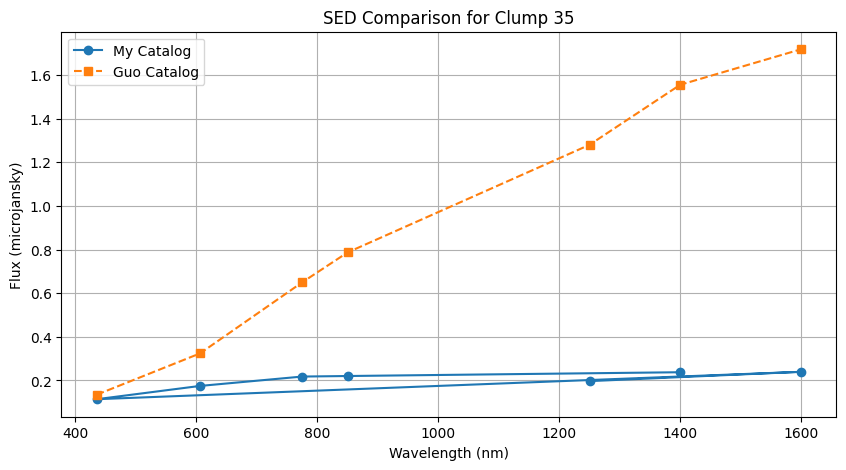

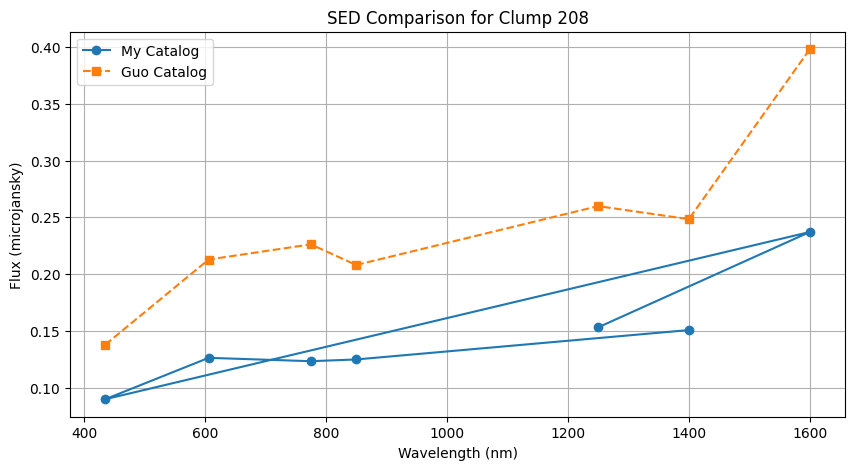

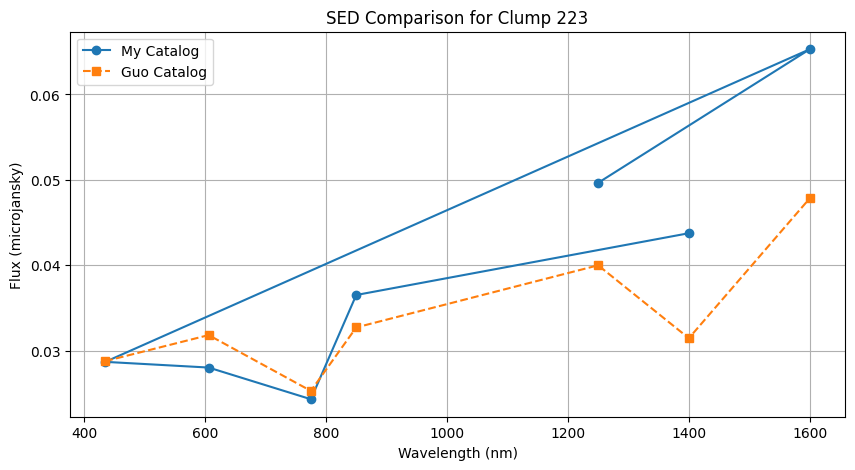

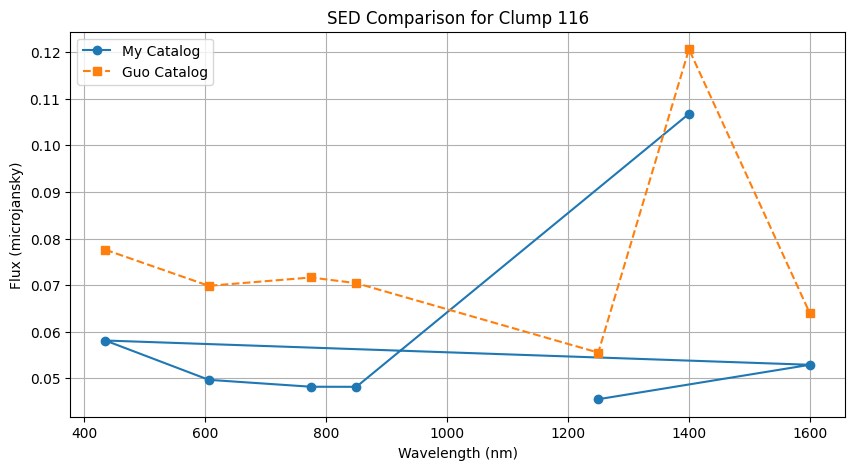

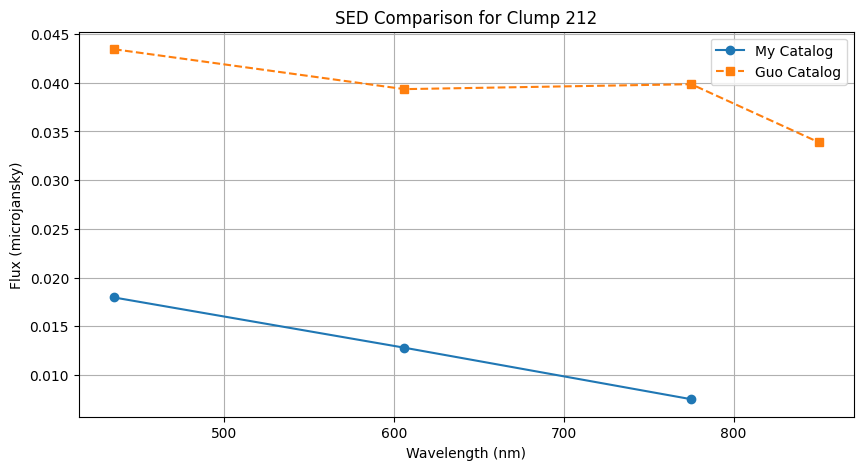

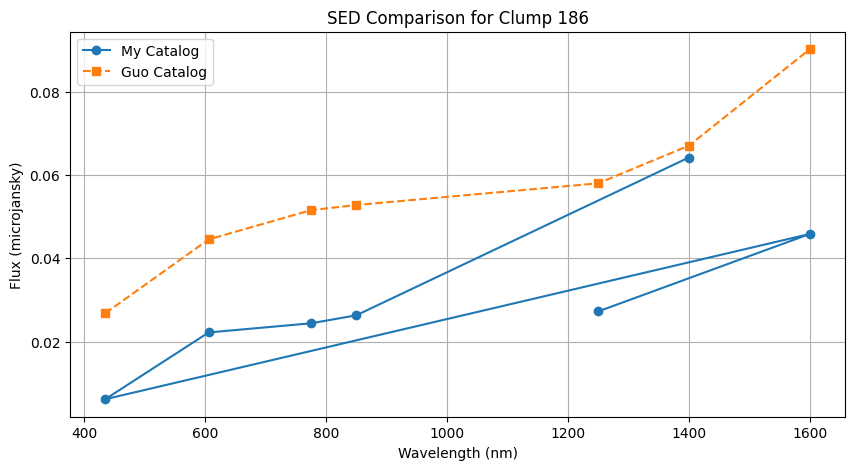

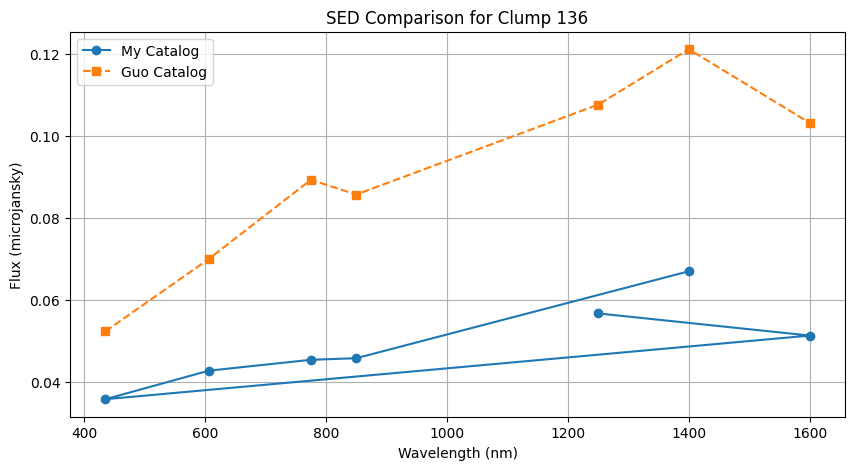

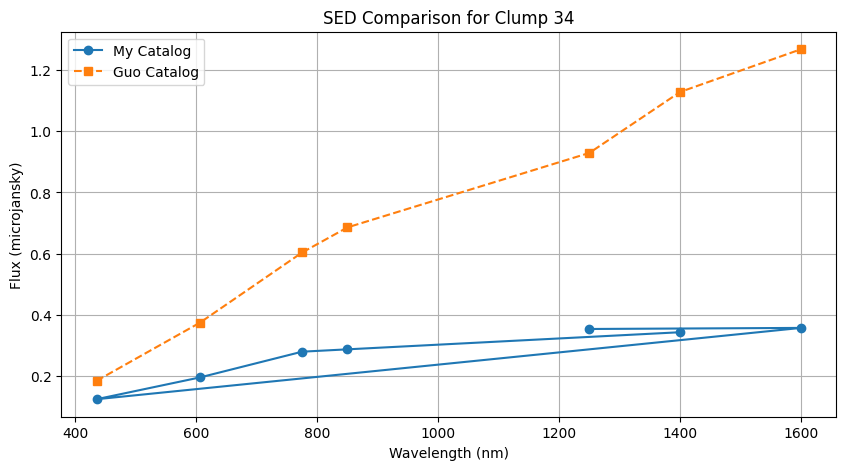

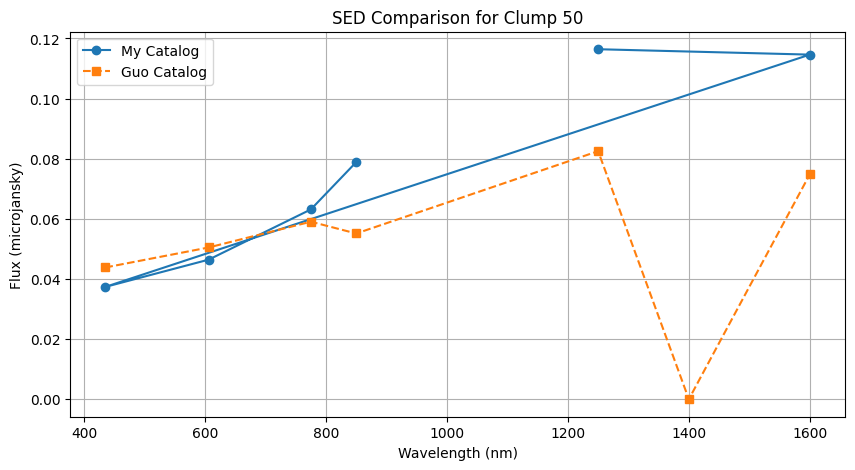

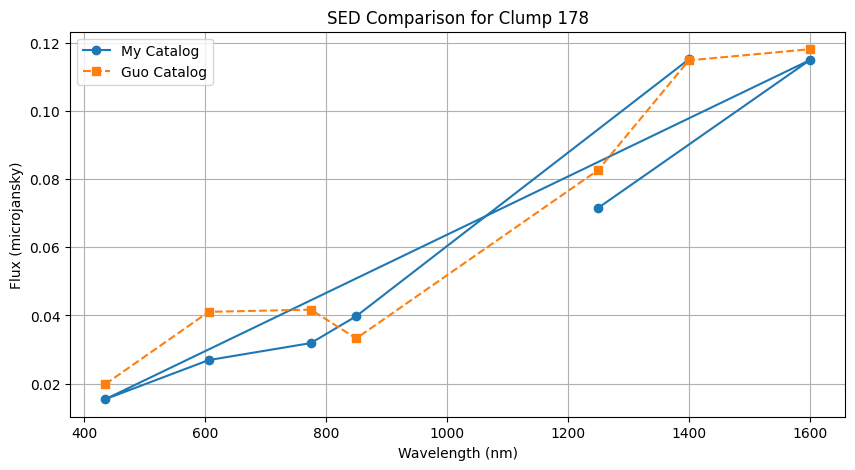

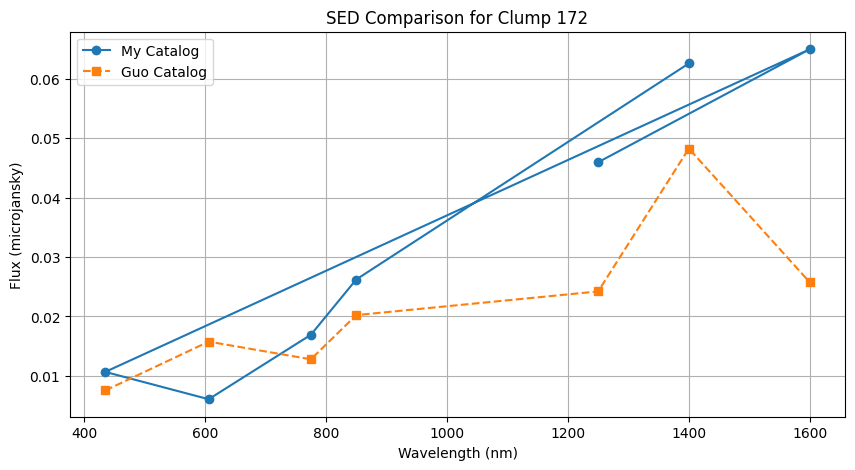

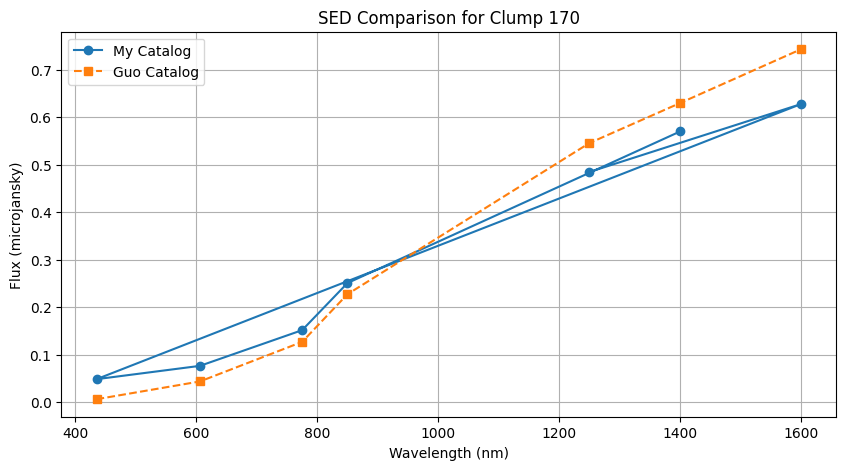

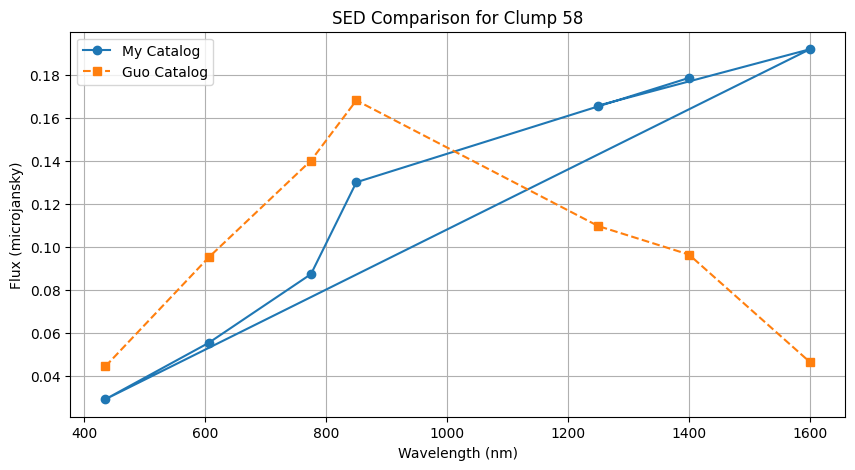

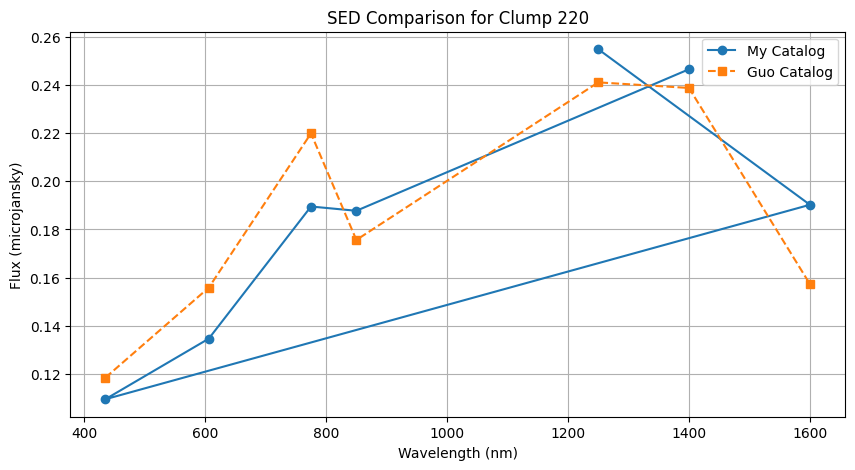

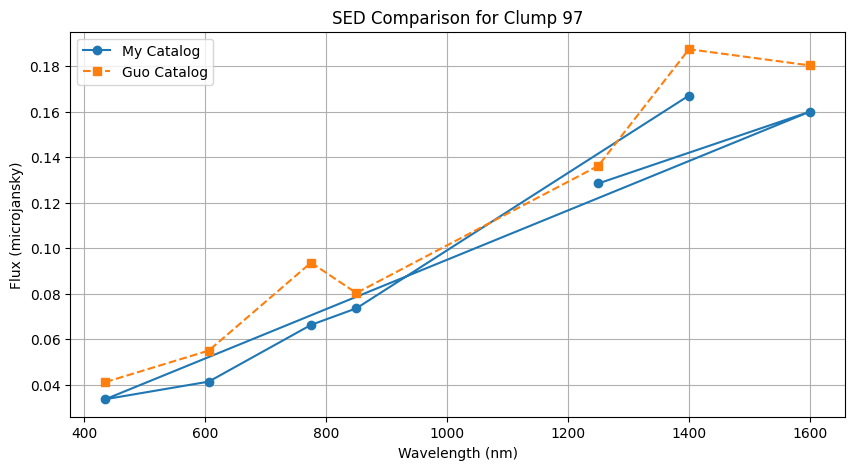

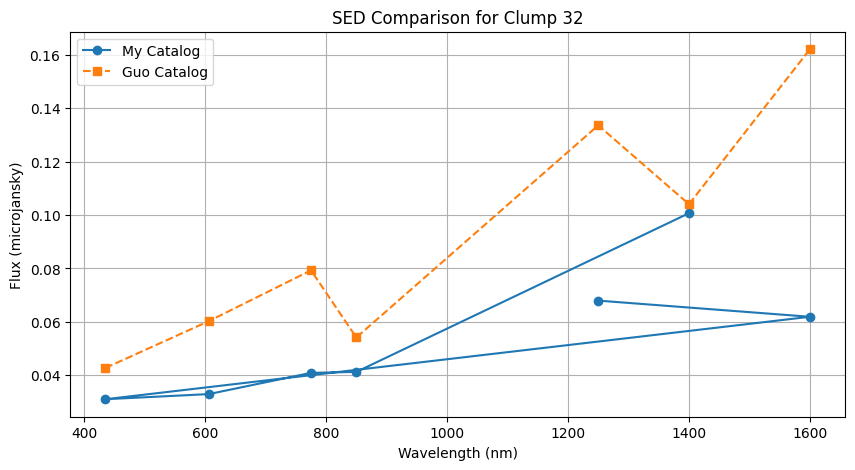

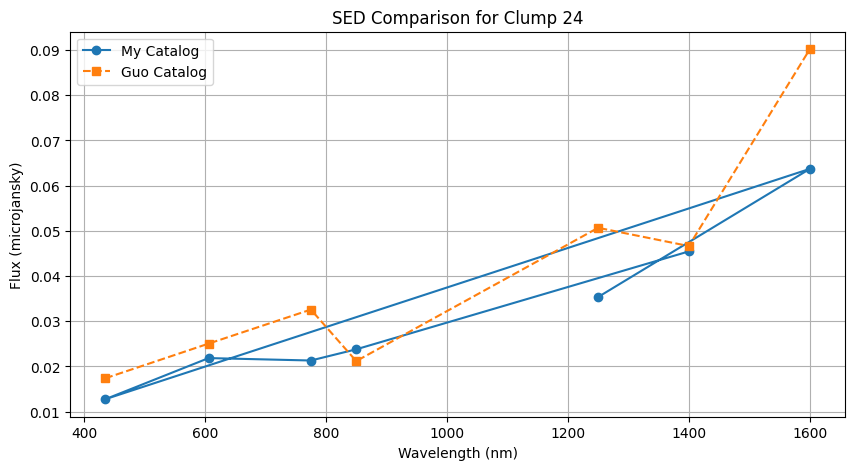

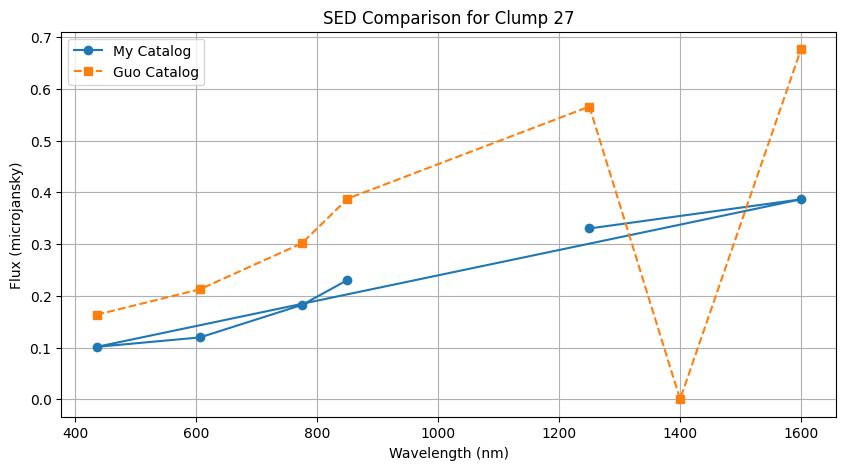

In [42]:
import matplotlib.pyplot as plt
import pandas as pd
import random

# Define the band wavelengths in nanometers for Guo's catalog
guo_band_wavelengths = {
    'F435W': 435,
    'F606W': 606,
    'F775W': 775,
    'F850LP': 850,
    'F125W': 1250,
    'F140W': 1400,
    'F160W': 1600,
    # Add other bands as needed
}

# Define the band suffixes for your catalog including 'f275w'
my_band_suffixes = ['f125w', 'f160w', 'f275w', 'f435w', 'f606w', 'f775w', 'f850lp', 'f140w']

# Assuming 'matched_fluxes' is your DataFrame containing matched clumps
# Sample 30 random clumps ensuring they are within the matched_fluxes index range
random_clumps_indices = random.sample(set(matched_fluxes.index), min(30, len(matched_fluxes)))
random_clumps = matched_fluxes.loc[random_clumps_indices]

# Threshold for minimum flux in microjansky for plotting from your catalog
flux_threshold = 1e-5

# Loop over each random clump to plot SEDs
for idx in random_clumps_indices:
    clump = matched_fluxes.loc[idx]
    wavelengths_my = []
    fluxes_my = []
    wavelengths_guo = []
    fluxes_guo = []

    # Collect flux data for your catalog
    for band_suffix in my_band_suffixes:
        my_flux_col = f'Corrected_Flux_{band_suffix}_mjy'
        # Use the same wavelength mapping for your catalog or define a separate one if needed
        wl = guo_band_wavelengths.get(band_suffix.upper(), None)
        
        # Check if the flux is non-negative and above the threshold, including the 275 nm band
        if wl and my_flux_col in clump and not pd.isna(clump[my_flux_col]) and clump[my_flux_col] >= 0 and clump[my_flux_col] > flux_threshold:
            wavelengths_my.append(wl)
            fluxes_my.append(clump[my_flux_col])

    # Collect flux data for Guo's catalog
    for guo_band, wl in guo_band_wavelengths.items():
        guo_flux_col = guo_band
        
        # Check if the flux is non-negative
        if guo_flux_col in clump and not pd.isna(clump[guo_flux_col]) and clump[guo_flux_col] >= 0:
            wavelengths_guo.append(wl)
            fluxes_guo.append(clump[guo_flux_col])

    # Plot the SED for the clump if there is data
    if wavelengths_my or wavelengths_guo:
        plt.figure(figsize=(10, 5))
        if wavelengths_my:
            plt.plot(wavelengths_my, fluxes_my, 'o-', label='My Catalog')
        if wavelengths_guo:
            plt.plot(wavelengths_guo, fluxes_guo, 's--', label='Guo Catalog')

        plt.xlabel('Wavelength (nm)')
        plt.ylabel('Flux (microjansky)')
        plt.title(f'SED Comparison for Clump {idx}')
        plt.legend()
        plt.grid(True)
        plt.show()
        plt.close()
    else:
        print(f'No data available to plot SED for clump {idx}')


/var/folders/by/26kj85kd3w94p3xv_m2206b40000gn/T/ipykernel_54615/2074523353.py:32: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  random_clumps_indices = random.sample(set(matched_fluxes.index), min(30, len(matched_fluxes)))


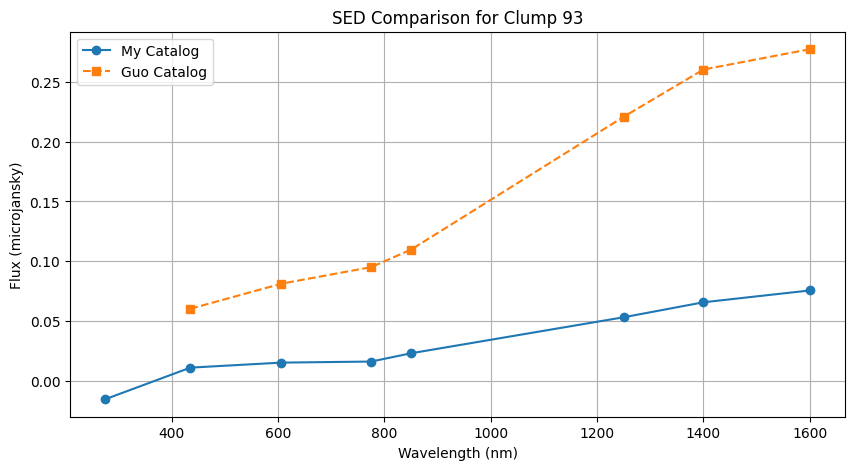

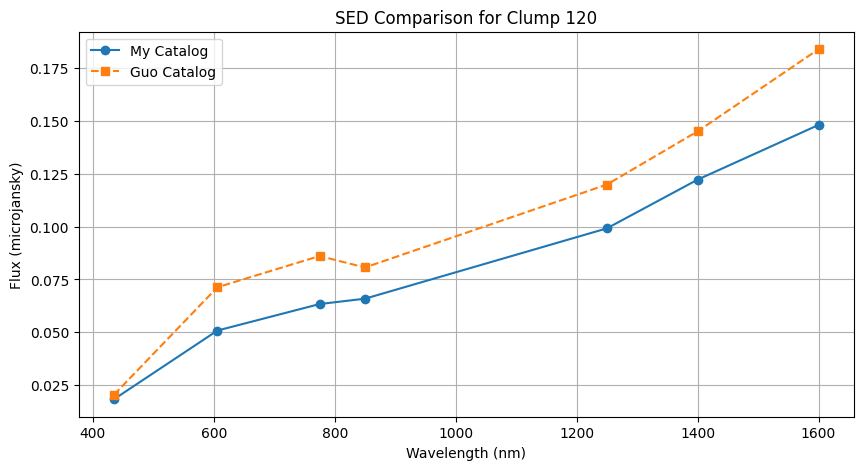

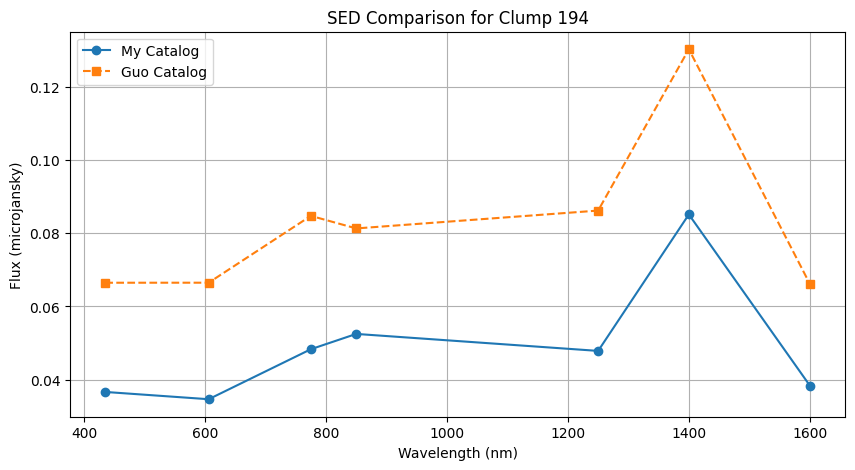

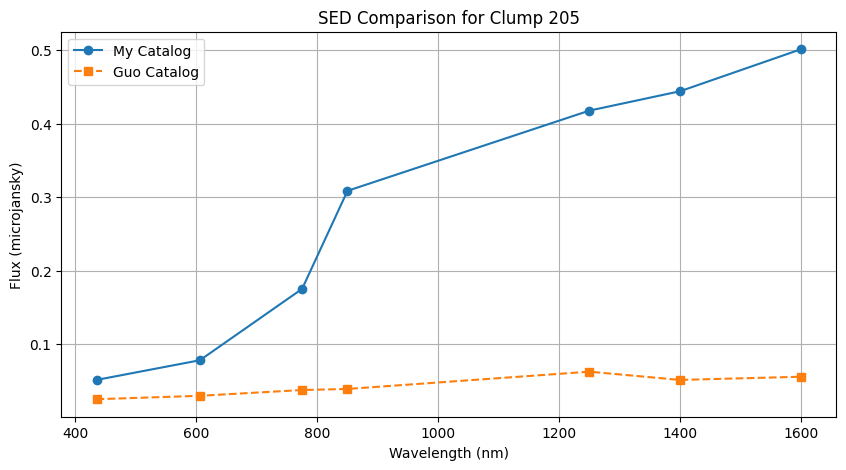

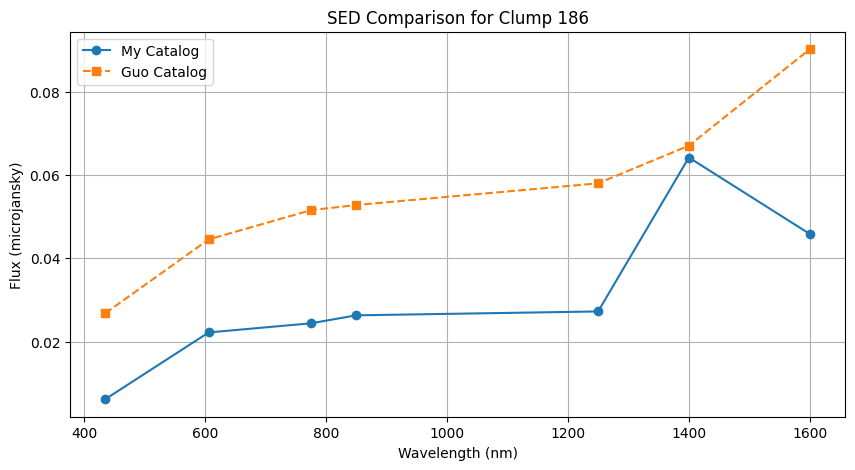

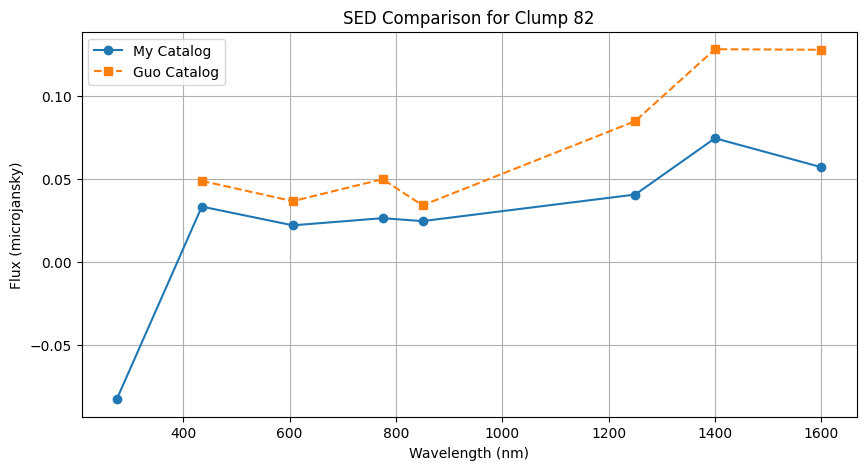

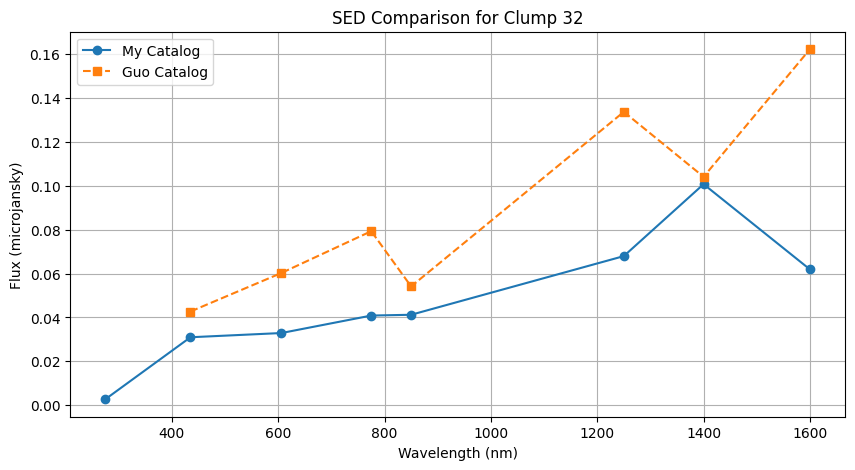

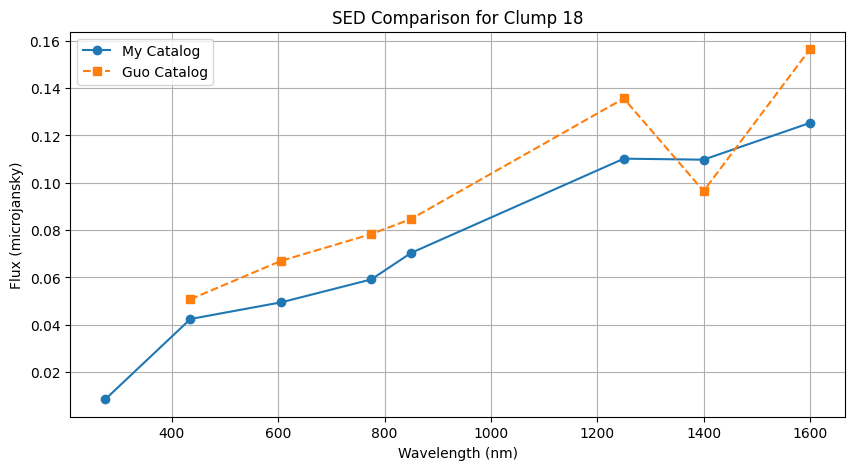

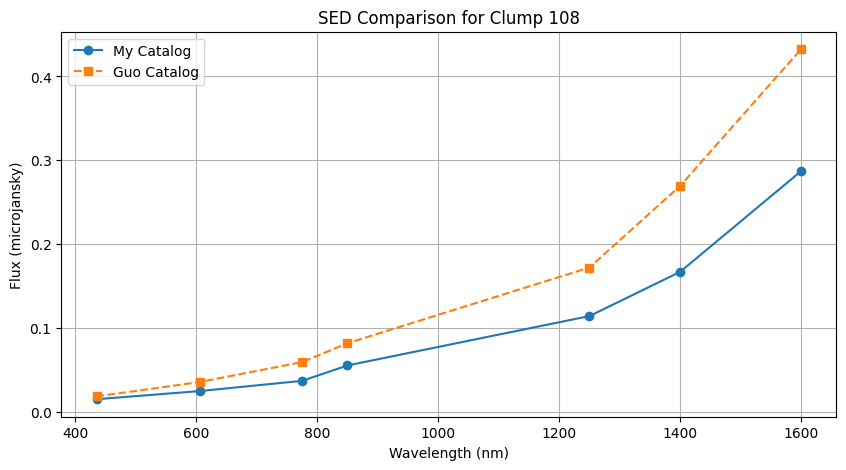

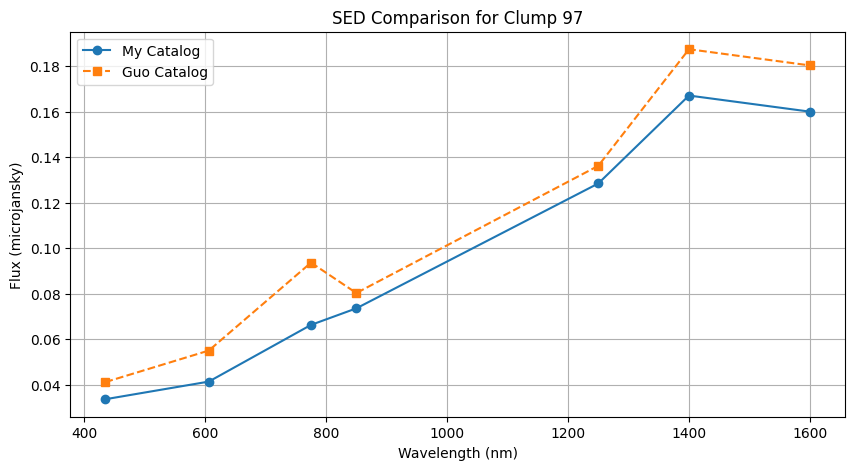

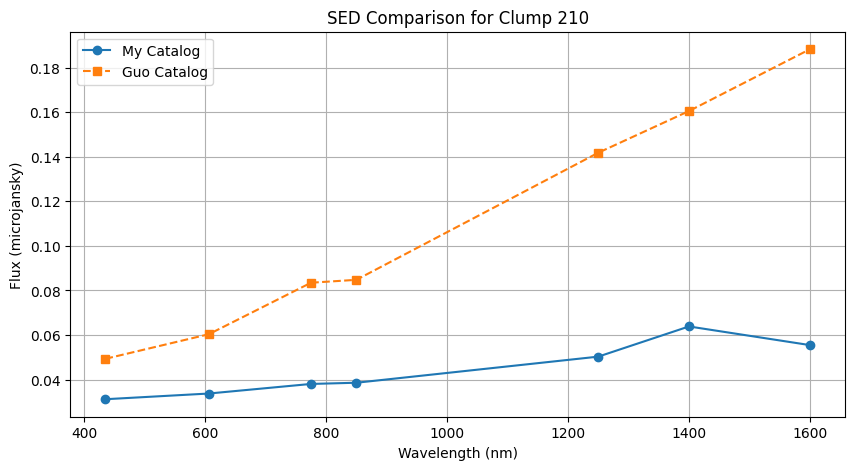

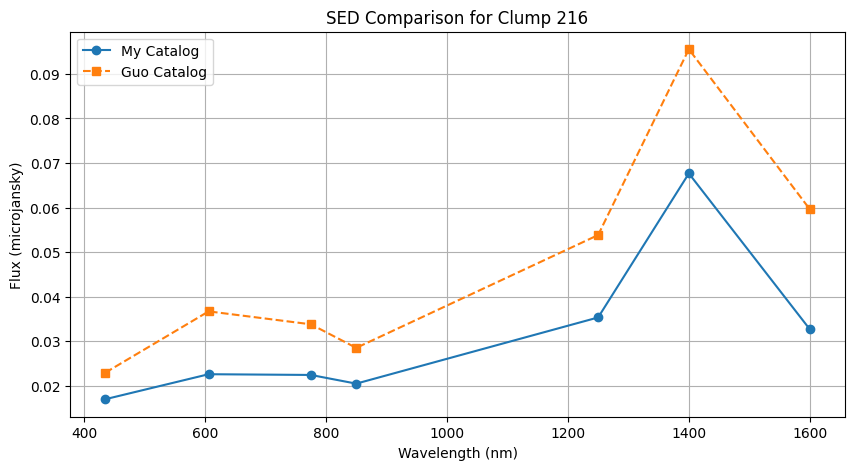

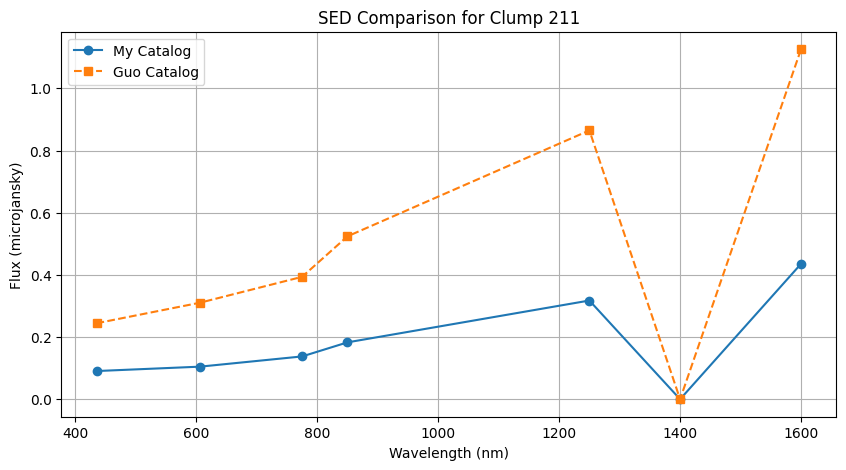

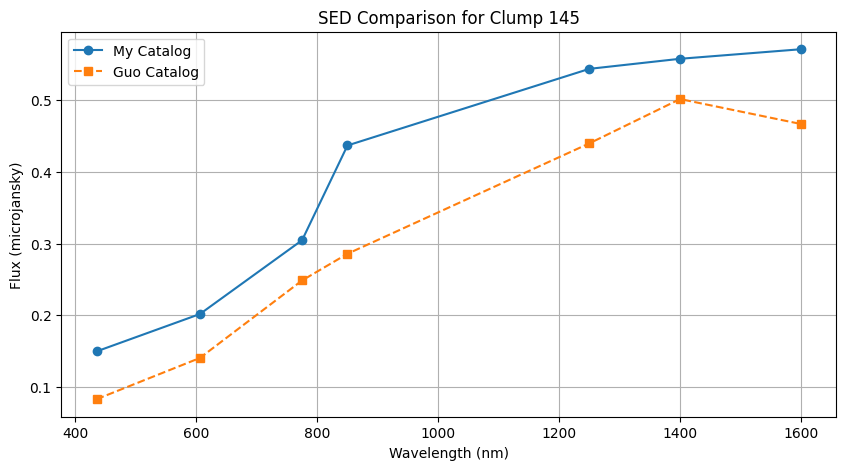

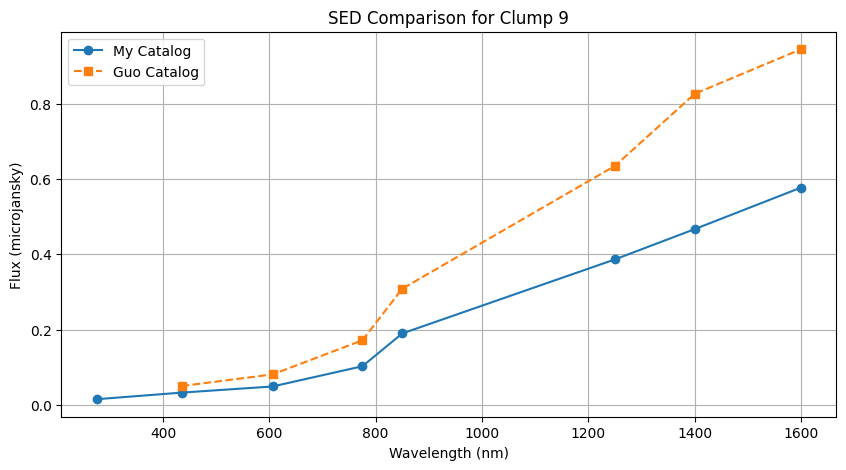

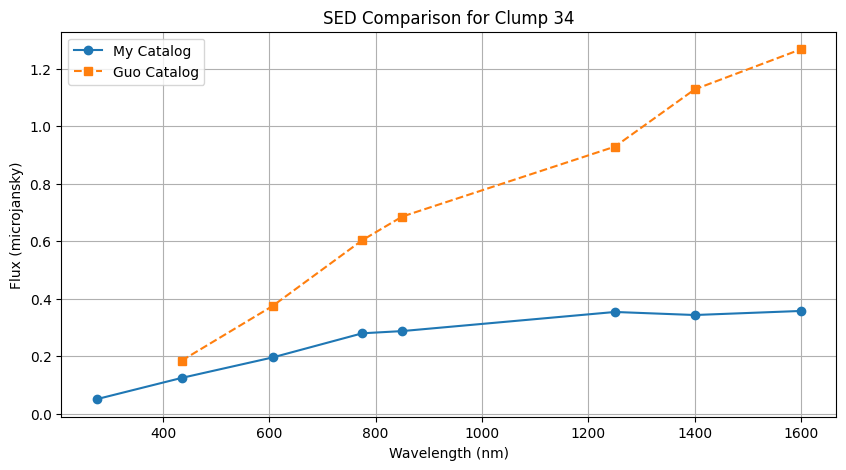

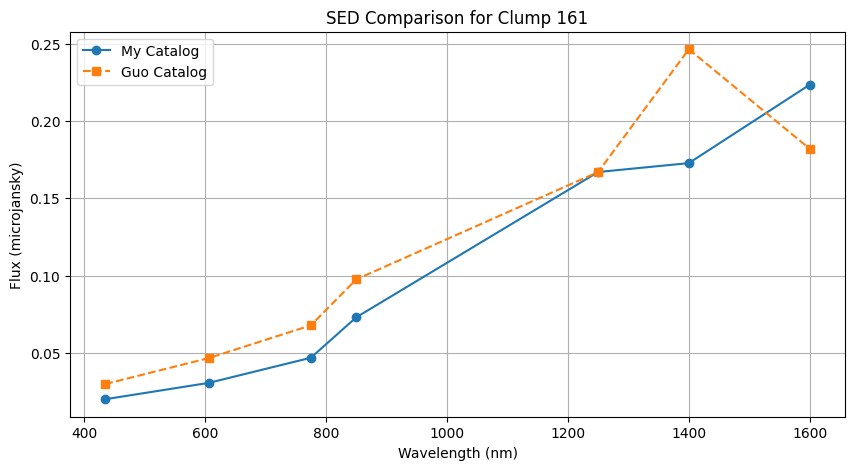

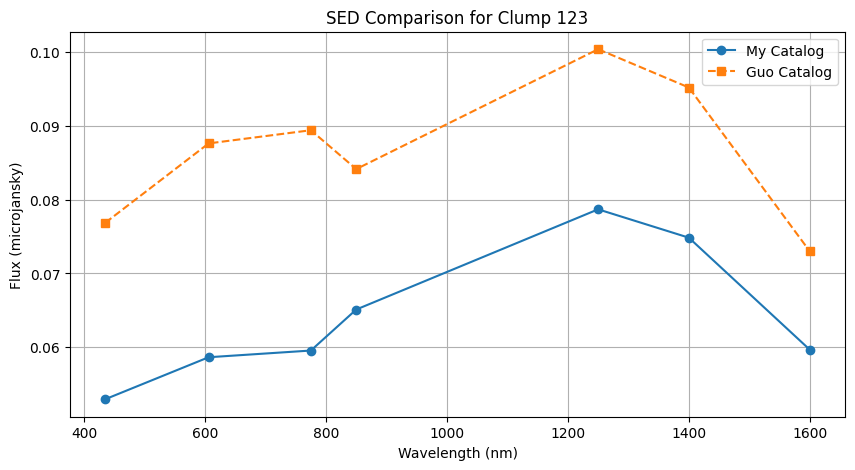

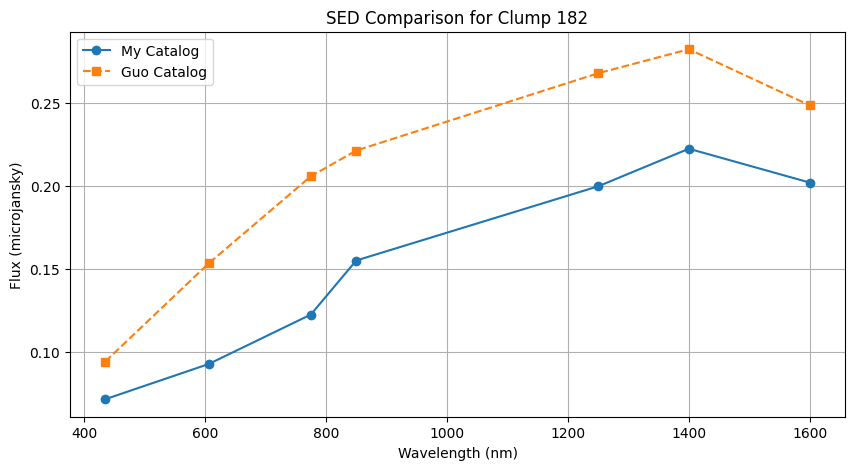

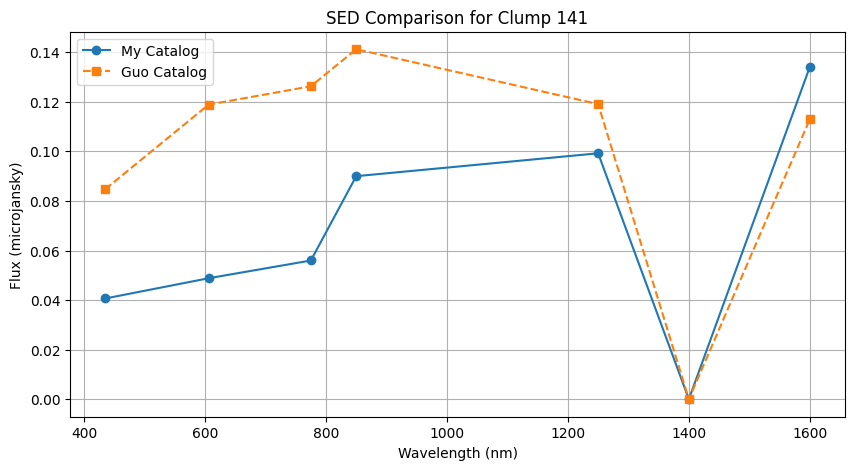

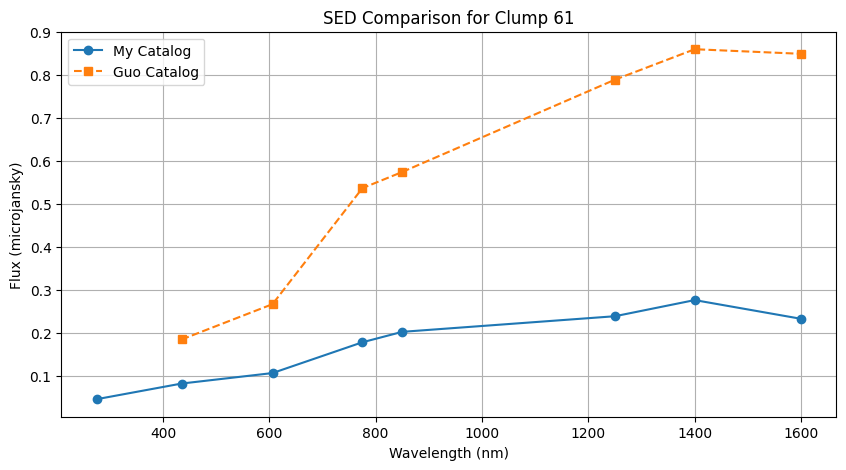

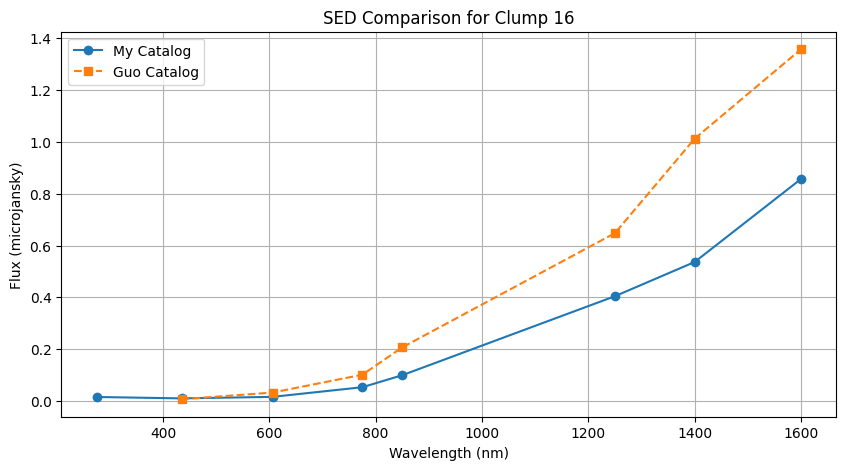

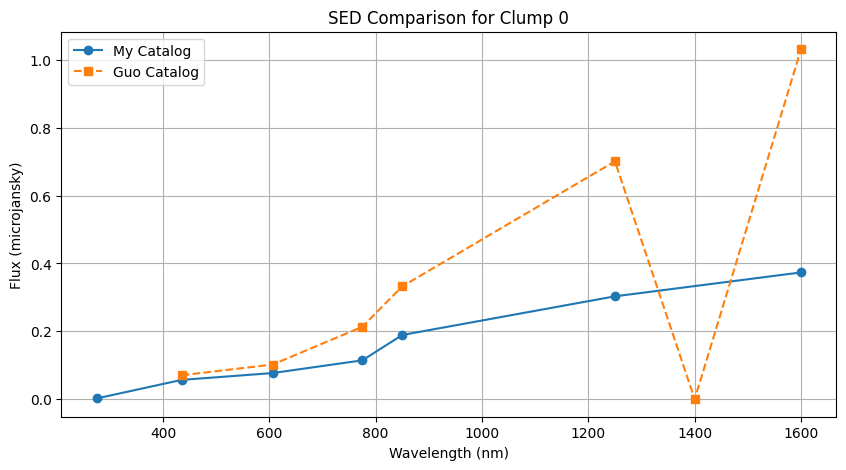

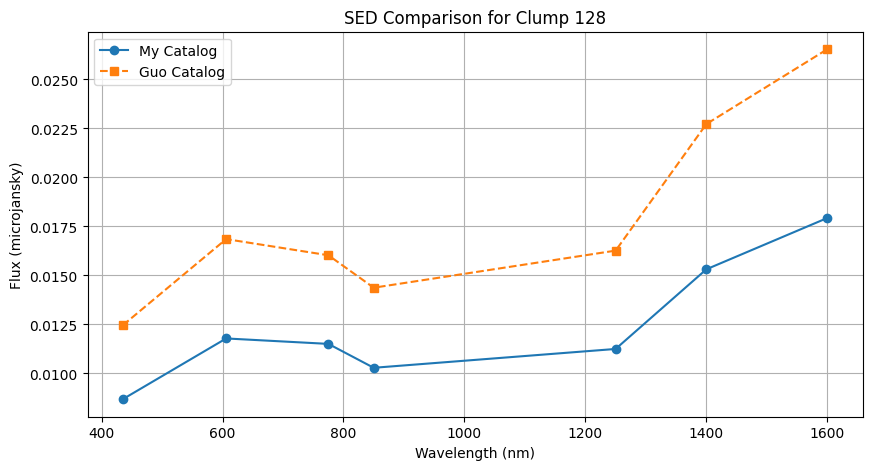

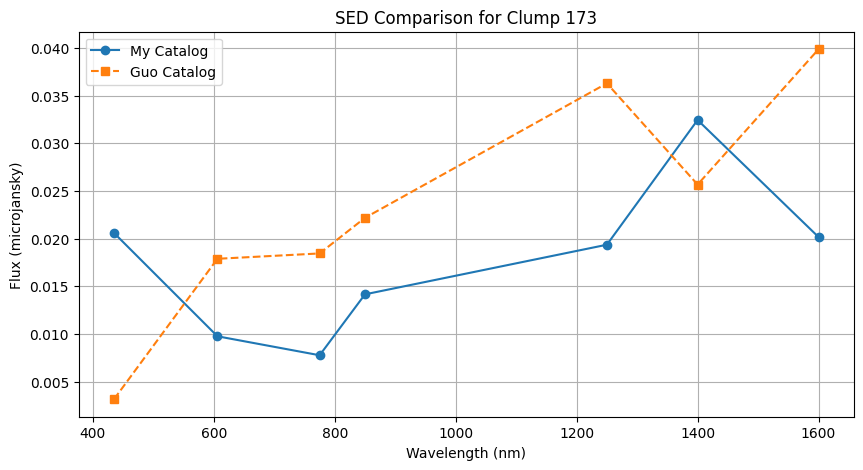

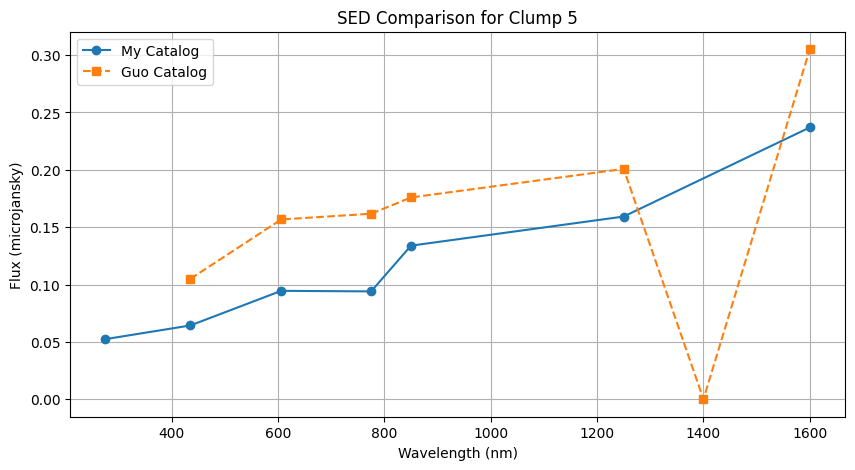

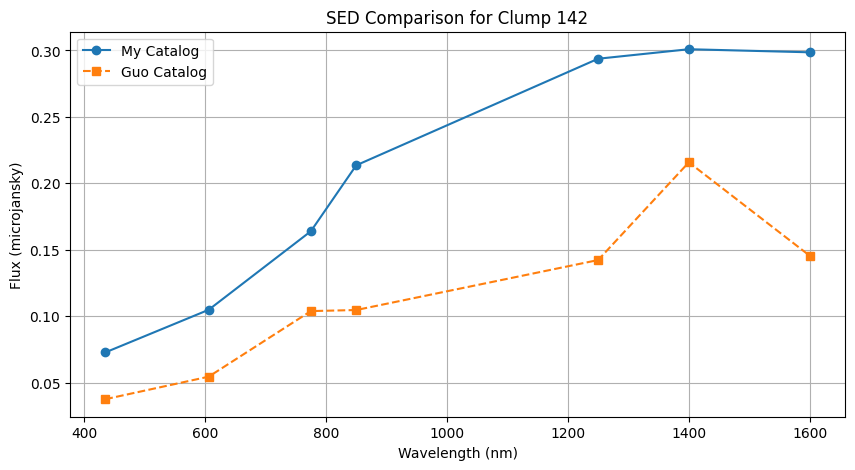

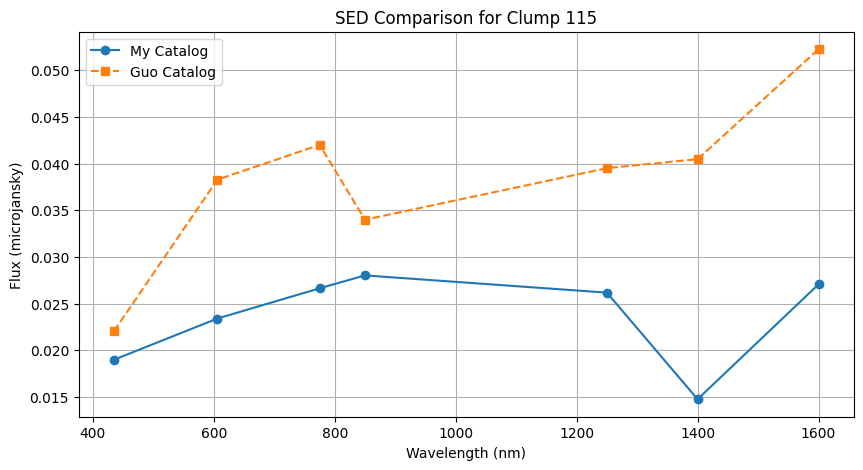

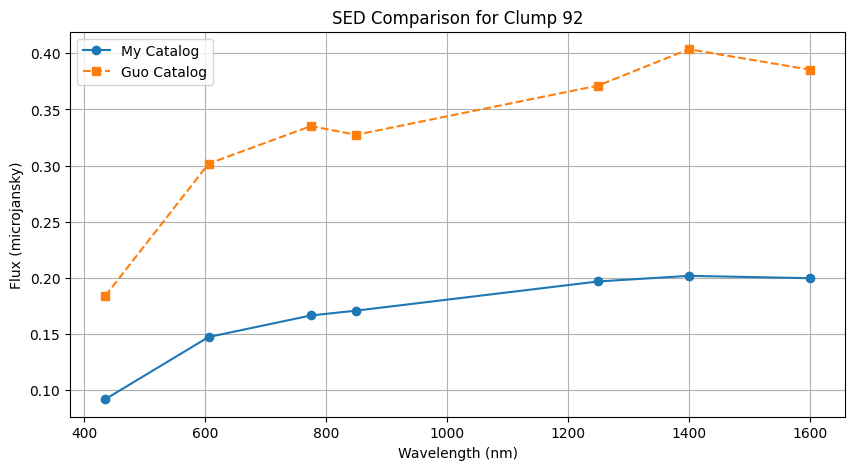

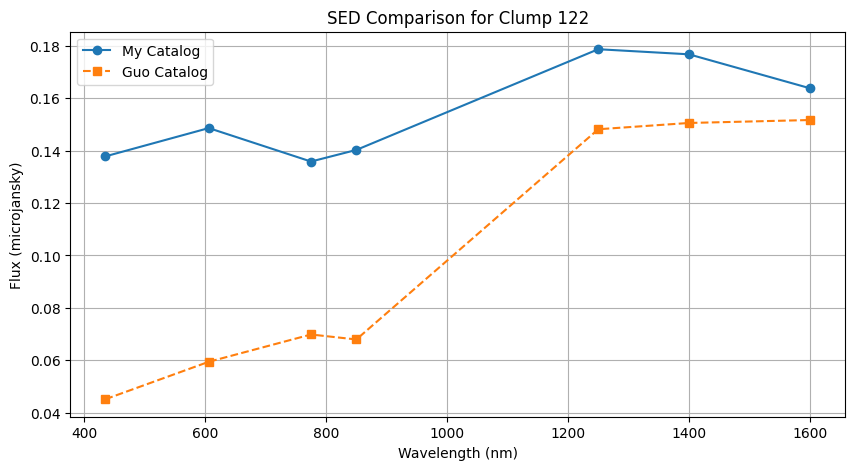

In [44]:
import random
import matplotlib.pyplot as plt
import pandas as pd


guo_band_wavelengths = {
    'F435W': 435,
    'F606W': 606,
    'F775W': 775,
    'F850LP': 850,
    'F125W': 1250,
    'F140W': 1400,
    'F160W': 1600,
    # ... other bands
}

# Define a separate dictionary for my catalog 
my_band_wavelengths = {
    'f125w': 1250,
    'f160w': 1600,
    'f275w': 275,  # Add the 275 nm band here
    'f435w': 435,
    'f606w': 606,
    'f775w': 775,
    'f850lp': 850,
    'f140w': 1400,
    
}


# Sample 30 random clumps ensuring they are within the matched_fluxes index range
random_clumps_indices = random.sample(set(matched_fluxes.index), min(30, len(matched_fluxes)))
random_clumps = matched_fluxes.loc[random_clumps_indices]

# Loop over each random clump to plot SEDs
for idx in random_clumps_indices:
    clump = matched_fluxes.loc[idx]
    wavelengths_my = []
    fluxes_my = []
    wavelengths_guo = []
    fluxes_guo = []

    # Collect flux data for my catalog
    for band_suffix, wl in my_band_wavelengths.items():
        my_flux_col = f'Corrected_Flux_{band_suffix}_mjy'
        
        # Check if the column exists in my catalog and if the value is not NaN
        if my_flux_col in clump and not pd.isna(clump[my_flux_col]):
            wavelengths_my.append(wl)
            fluxes_my.append(clump[my_flux_col])

    # Collect flux data for Guo's catalog
    for guo_band, wl in guo_band_wavelengths.items():
        guo_flux_col = guo_band
        
        # Check if the column exists in Guo's catalog and if the value is not NaN
        if guo_flux_col in clump and not pd.isna(clump[guo_flux_col]):
            wavelengths_guo.append(wl)
            fluxes_guo.append(clump[guo_flux_col])

    # Sort the data by wavelength
    my_sorted_indices = np.argsort(wavelengths_my)
    guo_sorted_indices = np.argsort(wavelengths_guo)

    # Plot the SED for the clump if there is data
    plt.figure(figsize=(10, 5))
    if wavelengths_my:
        plt.plot(np.array(wavelengths_my)[my_sorted_indices], np.array(fluxes_my)[my_sorted_indices], 'o-', label='My Catalog')
    if wavelengths_guo:
        plt.plot(np.array(wavelengths_guo)[guo_sorted_indices], np.array(fluxes_guo)[guo_sorted_indices], 's--', label='Guo Catalog')

    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Flux (microjansky)')
    plt.title(f'SED Comparison for Clump {idx}')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Close the figure to free up memory
    plt.close()


In [45]:
my_flux_col

'Corrected_Flux_f140w_mjy'